In [1]:
#Library
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
import category_encoders as ce
#pip install category_encoders
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
#pip install xgboost
#pip install catboost
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from scipy.stats import randint, uniform
#pip install optuna
import optuna

# Start!

In [2]:
train_perf_df = pd.read_csv('C:/Users/jgong/OneDrive/MMA Smith/MMA 869/Project/Data/trainperf.csv')
test_perf_df = pd.read_csv('C:/Users/jgong/OneDrive/MMA Smith/MMA 869/Project/Data/testperf.csv')

train_demo_df = pd.read_csv('C:/Users/jgong/OneDrive/MMA Smith/MMA 869/Project/Data/traindemographics.csv')
test_demo_df = pd.read_csv('C:/Users/jgong/OneDrive/MMA Smith/MMA 869/Project/Data/testdemographics.csv')
demo_df = pd.concat([test_demo_df,train_demo_df])
demo_df=demo_df.reset_index(drop=True)

train_prev_df = pd.read_csv('C:/Users/jgong/OneDrive/MMA Smith/MMA 869/Project/Data/trainprevloans.csv')
test_prev_df = pd.read_csv('C:/Users/jgong/OneDrive/MMA Smith/MMA 869/Project/Data/testprevloans.csv')
prev_df = pd.concat([train_prev_df,test_prev_df])
prev_df=prev_df.reset_index(drop=True)

In [3]:
print("Demo: ", train_demo_df.shape,test_demo_df.shape,demo_df.shape)
print("Prev: ", train_prev_df.shape,test_prev_df.shape,prev_df.shape)
print("Perf: ", train_perf_df.shape,test_perf_df.shape)

Demo:  (4346, 9) (1487, 9) (5833, 9)
Prev:  (18183, 12) (5907, 12) (24090, 12)
Perf:  (4368, 10) (1450, 9)


# Demo

In [4]:
demo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5833 entries, 0 to 5832
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  5833 non-null   object 
 1   birthdate                   5833 non-null   object 
 2   bank_account_type           5833 non-null   object 
 3   longitude_gps               5833 non-null   float64
 4   latitude_gps                5833 non-null   float64
 5   bank_name_clients           5833 non-null   object 
 6   bank_branch_clients         65 non-null     object 
 7   employment_status_clients   4968 non-null   object 
 8   level_of_education_clients  797 non-null    object 
dtypes: float64(2), object(7)
memory usage: 410.3+ KB


In [5]:
#MissingValue
demo_missing= pd.DataFrame(demo_df.isnull().mean().sort_values(ascending=False)*100,columns=['Percentage'])
demo_missing
#Remove bank_branch_clients & level_of_education_clients (over 85%)
#Impute employment_status_clients later in pipeline

,Percentage
bank_branch_clients,98.885651
level_of_education_clients,86.336362
employment_status_clients,14.829419
customerid,0.000000
birthdate,0.000000
bank_account_type,0.000000
longitude_gps,0.000000
latitude_gps,0.000000
bank_name_clients,0.000000


In [6]:
demo_df.drop(demo_missing.index[0:2].tolist(),axis=1,inplace=True)

In [7]:
#Calculate Age using birthdate
from datetime import date
from datetime import datetime
s = []
days_in_year = 365.2425 
for i in demo_df['birthdate']:
    age = ((date.today() - datetime.strptime(i[:10],'%Y-%m-%d').date())/365.2425).days
    s.append(age)
demo_df['Age']=s
demo_df['Age']=demo_df['Age'].astype(int)
demo_df.drop('birthdate',axis=1,inplace=True)

In [8]:
demo_df.head(20)

,customerid,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,Age
0,8a858f305c8dd672015c93b1db645db4,Savings,5.296628,7.593965,Heritage Bank,Permanent,46
1,8a858f085a477386015a47fb049e49ca,Savings,3.294513,6.596602,UBA,Permanent,44
2,8a858e6f5cd5e874015cd6f5634c39ad,Savings,8.501912,7.729364,First Bank,Permanent,38
3,8a858e9d5bfd7037015bfdab79f61305,Savings,3.318904,6.681595,UBA,Permanent,39
4,8a858fde56eb02280156eb6dafc128ac,Savings,6.354624,4.949031,First Bank,Self-Employed,40
5,8a858e695775665c015779a1a5cc1192,Other,3.307558,7.112214,Access Bank,Self-Employed,34
6,8a858e225c404292015c4e2b42c67bbe,Savings,8.349746,4.964838,First Bank,Permanent,36
7,8a858fcf5b39c3ba015b3d9f215c3922,Savings,3.892932,7.408140,GT Bank,NaN,44
8,8a858edd5c8348c4015c8452bc364cd7,Savings,3.432870,6.837874,Stanbic IBTC,NaN,40
9,8a858ef25c8393f8015c86783932595b,Savings,7.527908,6.427476,Diamond Bank,Permanent,31


In [9]:
#Check if any duplicate customerid
print(len(demo_df['customerid'].unique()),demo_df.shape[0])
#15 duplicates

5818 5833


In [10]:
demo_df[demo_df.duplicated('customerid',keep=False)].sort_values('customerid')
#extactly same, just keep one record

,customerid,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,Age
497,8a8588b75438f49901544510041e0951,Other,3.342808,6.542411,Zenith Bank,Permanent,42
502,8a8588b75438f49901544510041e0951,Other,3.342808,6.542411,Zenith Bank,Permanent,42
3415,8a858e625c8d993a015c938f829f77ee,Savings,5.768333,5.561992,First Bank,Permanent,33
2901,8a858e625c8d993a015c938f829f77ee,Savings,5.768333,5.561992,First Bank,Permanent,33
2577,8a858e6c5c88d145015c8b9627cd5a48,Savings,3.367008,6.497313,Sterling Bank,Permanent,43
1932,8a858e6c5c88d145015c8b9627cd5a48,Savings,3.367008,6.497313,Sterling Bank,Permanent,43
248,8a858e885b68546c015b7238f22027ba,Savings,3.353123,6.587837,First Bank,Permanent,47
810,8a858e885b68546c015b7238f22027ba,Savings,3.353123,6.587837,First Bank,Permanent,47
3483,8a858ec65cc6352b015cc64525ea0763,Savings,3.845728,7.411737,GT Bank,Permanent,37
3007,8a858ec65cc6352b015cc64525ea0763,Savings,3.845728,7.411737,GT Bank,Permanent,37


In [11]:
#Drop duplicate
demo_df.drop_duplicates('customerid',inplace=True)

In [12]:
#pip install geopy

#s = []
#for i in range(0,train_perf_df.shape[0]):
#    duration = round((datetime.strptime(train_perf_df['approveddate'][i],"%Y-%m-%d %H:%M:%S.%f")-
#    datetime.strptime(train_perf_df['creationdate'][i],"%Y-%m-%d %H:%M:%S.%f")).seconds/3600,2)
#    s.append(duration)
#train_perf_df['ApproveDuration']=s


In [13]:
demo_df

,customerid,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,Age
0,8a858f305c8dd672015c93b1db645db4,Savings,5.296628,7.593965,Heritage Bank,Permanent,46
1,8a858f085a477386015a47fb049e49ca,Savings,3.294513,6.596602,UBA,Permanent,44
2,8a858e6f5cd5e874015cd6f5634c39ad,Savings,8.501912,7.729364,First Bank,Permanent,38
3,8a858e9d5bfd7037015bfdab79f61305,Savings,3.318904,6.681595,UBA,Permanent,39
4,8a858fde56eb02280156eb6dafc128ac,Savings,6.354624,4.949031,First Bank,Self-Employed,40
...,...,...,...,...,...,...,...
5828,8a858f155554552501555588ca2b3b40,Other,3.236753,7.030168,Stanbic IBTC,Permanent,36
5829,8a858fc65cf978f4015cf97cee3a02ce,Savings,7.013750,4.875662,GT Bank,NaN,40
5830,8a858f4f5b66de3a015b66fc83c61902,Savings,6.295530,7.092508,GT Bank,Permanent,33
5831,8aaae7a74400b28201441c8b62514150,Savings,3.354206,6.539070,GT Bank,Permanent,37


In [14]:
#Check Again!
print(len(demo_df['customerid'].unique()),demo_df.shape[0])

5818 5818


# Prev

In [15]:
prev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24090 entries, 0 to 24089
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       24090 non-null  object 
 1   systemloanid     24090 non-null  int64  
 2   loannumber       24090 non-null  int64  
 3   approveddate     24090 non-null  object 
 4   creationdate     24090 non-null  object 
 5   loanamount       24090 non-null  float64
 6   totaldue         24090 non-null  float64
 7   termdays         24090 non-null  int64  
 8   closeddate       24090 non-null  object 
 9   referredby       1351 non-null   object 
 10  firstduedate     24090 non-null  object 
 11  firstrepaiddate  24090 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 2.2+ MB


In [16]:
#MissingValue
prev_missing= pd.DataFrame(prev_df.isnull().mean().sort_values(ascending=False)*100,columns=['Percentage'])
prev_missing
#referredby: Yes - Not Null; No - Null

,Percentage
referredby,94.391864
customerid,0.000000
systemloanid,0.000000
loannumber,0.000000
approveddate,0.000000
creationdate,0.000000
loanamount,0.000000
totaldue,0.000000
termdays,0.000000
closeddate,0.000000


In [17]:
##Drop Refer_By
prev_df.drop('referredby',axis=1,inplace=True)

In [18]:
prev_df.head(50)

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000
5,8a858970548359cc0154883481981866,301832407,5,2017-03-06 13:25:17.000000,2017-03-06 12:25:10.000000,20000.0,23800.0,30,2017-04-04 15:46:56.000000,2017-04-05 00:00:00.000000,2017-04-04 15:31:47.000000
6,8a858970548359cc0154883481981866,301926513,8,2017-06-04 01:00:23.000000,2017-06-04 00:00:16.000000,30000.0,39000.0,60,2017-07-03 23:35:38.000000,2017-07-04 00:00:00.000000,2017-07-03 23:25:29.000000
7,8a8589f35451855401546b0738c42524,301912443,6,2017-05-18 09:42:18.000000,2017-05-18 08:41:12.000000,20000.0,24500.0,30,2017-06-19 10:10:35.000000,2017-06-19 00:00:00.000000,2017-06-19 10:00:21.000000
8,8a858e095c59b91b015c5e5cea3719bc,301936857,2,2017-06-13 08:26:31.000000,2017-06-13 07:26:24.000000,10000.0,13000.0,30,2017-07-10 13:32:03.000000,2017-07-13 00:00:00.000000,2017-07-10 13:21:53.000000
9,8a858e1158dc4d830158f7bde4f47ea7,301811291,3,2017-02-06 18:55:30.000000,2017-02-06 17:55:20.000000,10000.0,11500.0,15,2017-02-21 05:34:20.000000,2017-02-21 00:00:00.000000,2017-02-21 05:19:09.000000


In [19]:
#ApprovedDuration
s = []
for i in range(0,prev_df.shape[0]):
    duration = round((datetime.strptime(prev_df['approveddate'][i],"%Y-%m-%d %H:%M:%S.%f")-
    datetime.strptime(prev_df['creationdate'][i],"%Y-%m-%d %H:%M:%S.%f")).seconds/3600,2)
    s.append(duration)
prev_df['ApproveDuration']=s

#Pay1st_Duration
s = []
for i in range(0,prev_df.shape[0]):
    duration = round((datetime.strptime(prev_df['firstrepaiddate'][i][:10],'%Y-%m-%d')-
    datetime.strptime(prev_df['firstduedate'][i][:10],'%Y-%m-%d')).days)
    s.append(duration)
prev_df['Pay1st_Duration']=s

#Pay_Duration
s = []
for i in range(0,prev_df.shape[0]):
    duration = (datetime.strptime(prev_df['closeddate'][i][:10],'%Y-%m-%d')-
    datetime.strptime(prev_df['approveddate'][i][:10],'%Y-%m-%d')).days-prev_df['termdays'][i]
    s.append(duration)
prev_df['Pay_Duration']=s

In [20]:
#Pay_OnTime_1st: if firstduedate >= firstpaiddate then Yes, else No
s = []
for i in range(0,prev_df.shape[0]):
    OnTime = datetime.strptime(prev_df['firstduedate'][i][:10],'%Y-%m-%d')>=datetime.strptime(prev_df['firstrepaiddate'][i][:10],'%Y-%m-%d')
    s.append(OnTime)
prev_df['Pay_OnTime_1stPayment']=s
prev_df['Pay_OnTime_1stPayment']=prev_df['Pay_OnTime_1stPayment'].apply(lambda x: 1 if x == True else 0)

#Pay_OnTime: if closeddate - approveddate <= termdays then Yes, else No
s = []
for i in range(0,prev_df.shape[0]):
    Delta = datetime.strptime(prev_df['closeddate'][i][:10],'%Y-%m-%d')-datetime.strptime(prev_df['approveddate'][i][:10],'%Y-%m-%d')
    Diff = Delta.days - prev_df['termdays'][i]
    s.append(Diff)
prev_df['Pay_OnTime']=s
prev_df['Pay_OnTime']=prev_df['Pay_OnTime'].apply(lambda x: 1 if x <= 0 else 0)#

prev_df[['Pay_OnTime_1stPayment','Pay_OnTime']].describe()

#Drop firstduedate, firstpaiddate, closeddate & approveddate
#Also Drop systemloanid & loanamount (will use total due instead)
#prev_df.drop(['firstduedate','firstrepaiddate','closeddate', 'approveddate','creationdate',
#              'systemloanid','loanamount'],axis=1,inplace=True)

,Pay_OnTime_1stPayment,Pay_OnTime
count,24090.000000,24090.00000
mean,0.822623,0.75301
std,0.381995,0.43127
min,0.000000,0.00000
25%,1.000000,1.00000
50%,1.000000,1.00000
75%,1.000000,1.00000
max,1.000000,1.00000


In [21]:
#interest
prev_df['interest']=prev_df['totaldue']-prev_df['loanamount']

#termdays for Pay_OnTime_1stPayment=1
prev_df['termday_Pay_OnTime_1stPayment']=prev_df['termdays']*prev_df['Pay_OnTime_1stPayment']

#termdays for Pay_OnTime=1
prev_df['termday_Pay_OnTime']=prev_df['termdays']*prev_df['Pay_OnTime']

In [22]:
#Caluculate avg loan duation
lastloan=prev_df.sort_values("loannumber").drop_duplicates("customerid",keep="last")
lastloan=lastloan[['customerid','loannumber','approveddate','closeddate']]

firstloan=prev_df.sort_values("loannumber").drop_duplicates("customerid",keep="first")
firstloan=firstloan[['customerid','loannumber','approveddate','closeddate']]

loan_duration=pd.merge(firstloan, lastloan, how='left', on=['customerid', 'customerid'])
loan_duration.columns=['customerid','loannumber_1st','approveddate_1st','closeddate_1st','loannumber_last','approveddate_last',
                       'closeddate_last']

s = []
for i in range(0,loan_duration.shape[0]):
    duration = round((datetime.strptime(loan_duration['closeddate_last'][i][:10],'%Y-%m-%d')-
    datetime.strptime(loan_duration['approveddate_1st'][i][:10],'%Y-%m-%d')).days)
    s.append(duration)
loan_duration['loan_duration']=s

loan_duration['prev_avg_loan_duration']=loan_duration['loan_duration']/(loan_duration['loannumber_last']-loan_duration['loannumber_1st']+1)
loan_duration=loan_duration[['customerid','prev_avg_loan_duration']]
loan_duration

,customerid,prev_avg_loan_duration
0,8a858e6c5c88d145015c894de5001cce,29.000000
1,8a858feb55f82bbf0155f85225000130,36.600000
2,8a858eae5bb5beb8015bbb0a34bf0472,22.333333
3,8a858fa05908043801590ced4e786bd6,104.500000
4,8a858fcf5a192144015a1d262059287d,24.000000
...,...,...
5796,8a8589b953bc23f70153ccc3fd3519c7,25.000000
5797,8a399f284741b63b0147496a04db1eb4,49.000000
5798,8a688b474ed5e088014ed8b6c50c5f51,20.000000
5799,8a85895354be33300154c4e81edf0dd7,28.000000


In [23]:
prev_df=prev_df.groupby('customerid',as_index=False).agg({'totaldue': ['mean'],
                                                  'loanamount': ['mean','sum'],
                                                  'interest': ['mean'],
                                                  'systemloanid': ['count'],
                                                  'termdays': ['mean'], 
                                                  'ApproveDuration': ['mean'],
                                                  'Pay1st_Duration': ['mean'],
                                                  'Pay_Duration': ['mean'],
                                                  'Pay_OnTime_1stPayment': ['sum'],
                                                  'Pay_OnTime': ['sum'],
                                                  'termday_Pay_OnTime_1stPayment': ['sum'],
                                                  'termday_Pay_OnTime': ['sum']
                                                    })

prev_df.columns=['customerid','prev_totaldue_mean','prev_loanamount_mean','prev_loanamount_sum','prev_interest_mean',
                 'prev_loan_number','prev_termdays_mean','prev_approveDuration_mean','prev_Pay1st_Duration_mean',
                 'prev_Pay_Duration_mean','prev_1stpayment_ontime','prev_ontime','termdays_Pay_OnTime_1stPayment_mean',
                'termdays_Pay_OnTime_mean'
                ]

In [24]:
prev_df = pd.merge(prev_df, loan_duration, how='left', on=['customerid', 'customerid'])

In [25]:
prev_df

,customerid,prev_totaldue_mean,prev_loanamount_mean,prev_loanamount_sum,prev_interest_mean,prev_loan_number,prev_termdays_mean,prev_approveDuration_mean,prev_Pay1st_Duration_mean,prev_Pay_Duration_mean,prev_1stpayment_ontime,prev_ontime,termdays_Pay_OnTime_1stPayment_mean,termdays_Pay_OnTime_mean,prev_avg_loan_duration
0,8a1088a0484472eb01484669e3ce4e0b,11500.000000,10000.000000,10000.0,1500.000000,1,15.000000,1.020000,6.000000,7.000000,0,0,0,0,22.000000
1,8a1a1e7e4f707f8b014f797718316cad,22375.000000,17500.000000,70000.0,4875.000000,4,37.500000,1.005000,-0.250000,-5.750000,3,3,120,120,109.750000
2,8a1a32fc49b632520149c3b8fdf85139,15214.285714,12857.142857,90000.0,2357.142857,7,19.285714,1.004286,-0.428571,-0.285714,6,6,120,120,68.142857
3,8a1eb5ba49a682300149c3c068b806c7,20300.000000,16250.000000,130000.0,4050.000000,8,33.750000,1.002500,-3.125000,-5.125000,7,8,210,270,31.500000
4,8a1edbf14734127f0147356fdb1b1eb2,12250.000000,10000.000000,20000.0,2250.000000,2,22.500000,1.010000,-4.000000,-4.000000,2,2,45,45,20.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5796,8a858fff5c79144c015c7bdbfc086ce1,13000.000000,10000.000000,10000.0,3000.000000,1,30.000000,1.000000,-5.000000,-1.000000,1,1,30,30,29.000000
5797,8aaae7a74400b28201441c8b62514150,12500.000000,10000.000000,30000.0,2500.000000,3,25.000000,1.003333,-0.666667,-0.333333,3,2,75,45,28.000000
5798,8aab10f748cf78ff0148d11fac1447a6,13000.000000,10000.000000,10000.0,3000.000000,1,30.000000,1.020000,2.000000,4.000000,0,0,0,0,34.000000
5799,8aab160f499477da014999ba2f0f578b,11750.000000,10000.000000,30000.0,1750.000000,3,20.000000,1.006667,0.333333,1.333333,2,1,45,15,143.666667


In [26]:
#Termday_mean for pay on time
prev_df['termday_1st_divisor']=prev_df['prev_1stpayment_ontime'].apply(lambda x: 1 if x == 0 else x)
prev_df['termday_divisor']=prev_df['prev_ontime'].apply(lambda x: 1 if x == 0 else x)

prev_df['termdays_Pay_OnTime_1stPayment_mean']=prev_df['termdays_Pay_OnTime_1stPayment_mean']/prev_df['termday_1st_divisor']
prev_df['termdays_Pay_OnTime_mean']=prev_df['termdays_Pay_OnTime_mean']/prev_df['termday_divisor']
prev_df.drop(['termday_1st_divisor','termday_divisor'],axis=1,inplace=True)

prev_df['termdays_Pay_OnTime_1stPayment_mean']=prev_df['termdays_Pay_OnTime_1stPayment_mean'].apply(lambda x: np.nan if x == 0 else x)
prev_df['termdays_Pay_OnTime_mean']=prev_df['termdays_Pay_OnTime_mean'].apply(lambda x: np.nan if x == 0 else x)
prev_df['termdays_Pay_OnTime_1stPayment_mean'].fillna(prev_df['termdays_Pay_OnTime_1stPayment_mean'].mean(),inplace=True)
prev_df['termdays_Pay_OnTime_mean'].fillna(prev_df['termdays_Pay_OnTime_mean'].mean(),inplace=True)

In [27]:
prev_df

,customerid,prev_totaldue_mean,prev_loanamount_mean,prev_loanamount_sum,prev_interest_mean,prev_loan_number,prev_termdays_mean,prev_approveDuration_mean,prev_Pay1st_Duration_mean,prev_Pay_Duration_mean,prev_1stpayment_ontime,prev_ontime,termdays_Pay_OnTime_1stPayment_mean,termdays_Pay_OnTime_mean,prev_avg_loan_duration
0,8a1088a0484472eb01484669e3ce4e0b,11500.000000,10000.000000,10000.0,1500.000000,1,15.000000,1.020000,6.000000,7.000000,0,0,25.274832,25.529267,22.000000
1,8a1a1e7e4f707f8b014f797718316cad,22375.000000,17500.000000,70000.0,4875.000000,4,37.500000,1.005000,-0.250000,-5.750000,3,3,40.000000,40.000000,109.750000
2,8a1a32fc49b632520149c3b8fdf85139,15214.285714,12857.142857,90000.0,2357.142857,7,19.285714,1.004286,-0.428571,-0.285714,6,6,20.000000,20.000000,68.142857
3,8a1eb5ba49a682300149c3c068b806c7,20300.000000,16250.000000,130000.0,4050.000000,8,33.750000,1.002500,-3.125000,-5.125000,7,8,30.000000,33.750000,31.500000
4,8a1edbf14734127f0147356fdb1b1eb2,12250.000000,10000.000000,20000.0,2250.000000,2,22.500000,1.010000,-4.000000,-4.000000,2,2,22.500000,22.500000,20.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5796,8a858fff5c79144c015c7bdbfc086ce1,13000.000000,10000.000000,10000.0,3000.000000,1,30.000000,1.000000,-5.000000,-1.000000,1,1,30.000000,30.000000,29.000000
5797,8aaae7a74400b28201441c8b62514150,12500.000000,10000.000000,30000.0,2500.000000,3,25.000000,1.003333,-0.666667,-0.333333,3,2,25.000000,22.500000,28.000000
5798,8aab10f748cf78ff0148d11fac1447a6,13000.000000,10000.000000,10000.0,3000.000000,1,30.000000,1.020000,2.000000,4.000000,0,0,25.274832,25.529267,34.000000
5799,8aab160f499477da014999ba2f0f578b,11750.000000,10000.000000,30000.0,1750.000000,3,20.000000,1.006667,0.333333,1.333333,2,1,22.500000,15.000000,143.666667


In [28]:
#Check duplicate
print(len(prev_df['customerid'].unique()),prev_df.shape[0])

5801 5801


# Perf

In [29]:
train_perf_df.info()
print('_'*40)
test_perf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customerid     4368 non-null   object 
 1   systemloanid   4368 non-null   int64  
 2   loannumber     4368 non-null   int64  
 3   approveddate   4368 non-null   object 
 4   creationdate   4368 non-null   object 
 5   loanamount     4368 non-null   float64
 6   totaldue       4368 non-null   float64
 7   termdays       4368 non-null   int64  
 8   referredby     587 non-null    object 
 9   good_bad_flag  4368 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 341.4+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   customerid    1450 non-null   object 
 1   systemloanid  1450 n

In [30]:
train_perf_df

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good
...,...,...,...,...,...,...,...,...,...,...
4363,8a858e6d58b0cc520158beeb14b22a5a,302003163,2,2017-07-30 09:19:42.000000,2017-07-30 08:18:30.000000,10000.0,13000.0,30,NaN,Bad
4364,8a858ee85cf400f5015cf44ab1c42d5c,301998967,2,2017-07-27 15:35:47.000000,2017-07-27 14:35:40.000000,10000.0,13000.0,30,NaN,Bad
4365,8a858f365b2547f3015b284597147c94,301995576,3,2017-07-25 16:25:57.000000,2017-07-25 15:24:47.000000,10000.0,11500.0,15,NaN,Bad
4366,8a858f935ca09667015ca0ee3bc63f51,301977679,2,2017-07-14 13:50:27.000000,2017-07-14 12:50:21.000000,10000.0,13000.0,30,8a858eda5c8863ff015c9dead65807bb,Bad


In [31]:
test_perf_df

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby
0,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,12250.0,30,NaN
1,8a858959537a097401537a4e316e25f7,301963615,10,43:40.0,42:34.0,40000,44000.0,30,NaN
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,24500.0,30,NaN
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,00:54.0,00:49.0,30000,34500.0,30,NaN
4,8a858e225a28c713015a30db5c48383d,301959177,4,04:33.0,04:27.0,20000,24500.0,30,NaN
...,...,...,...,...,...,...,...,...,...
1445,8a858fb45bb59c21015bb88a191f58f2,301991141,3,47:02.0,46:53.0,10000,11500.0,15,NaN
1446,8a858fcb5b00cc54015b0253ced26a5f,301963018,3,00:45.0,04:05.0,10000,13000.0,30,NaN
1447,8a858fde56eb02280156f59b976d46c0,301994653,9,09:40.0,09:33.0,40000,48000.0,60,NaN
1448,8a858e10570f2d65015717fcfec44996,301961483,14,47:54.0,46:49.0,60000,68100.0,90,NaN


In [32]:
#interest
train_perf_df['interest']=train_perf_df['totaldue']-train_perf_df['loanamount']
test_perf_df['interest']=test_perf_df['totaldue']-test_perf_df['loanamount']

In [33]:
#ApprovedDuration
#s = []
#for i in range(0,train_perf_df.shape[0]):
#    duration = round((datetime.strptime(train_perf_df['approveddate'][i],"%Y-%m-%d %H:%M:%S.%f")-
#    datetime.strptime(train_perf_df['creationdate'][i],"%Y-%m-%d %H:%M:%S.%f")).seconds/3600,2)
#    s.append(duration)
#train_perf_df['ApproveDuration']=s
#
#k = []
#for i in range(0,test_perf_df.shape[0]):
#    duration = round((datetime.strptime(test_perf_df['approveddate'][i],"%H:%M.%S")-
#    datetime.strptime(test_perf_df['creationdate'][i],"%H:%M.%S")).seconds/3600,2)
#    k.append(duration)
#test_perf_df['ApproveDuration']=k

In [34]:
#Referredby: if has value, then 1; else 0
#train_perf_df['referredby']=train_perf_df['referredby'].apply(lambda x: 0 if pd.isna(x) else 1)
#test_perf_df['referredby']=train_perf_df['referredby'].apply(lambda x: 0 if pd.isna(x) else 1)

In [35]:
#drop sysyemloanid, approveddate, creationdate & referredby
train_perf_df.drop(['systemloanid','approveddate','creationdate','referredby'],axis=1,inplace=True)
test_perf_df.drop(['systemloanid','approveddate','creationdate','referredby'],axis=1,inplace=True)

In [36]:
#Check duplicate
print(len(train_perf_df['customerid'].unique()),train_perf_df.shape[0])
print(len(test_perf_df['customerid'].unique()),test_perf_df.shape[0])

4368 4368
1450 1450


# Final Data

In [37]:
#Merging all 3 datasets based on pref using customerid as primary key
# first, perf & demo
train_df = pd.merge(train_perf_df, demo_df, how='left', on=['customerid', 'customerid'])
test_df = pd.merge(test_perf_df, demo_df, how='left', on=['customerid', 'customerid'])

#Second merge with prev
train_df = pd.merge(train_df, prev_df, how='left', on=['customerid', 'customerid'])
test_df = pd.merge(test_df, prev_df, how='left', on=['customerid', 'customerid'])

In [38]:
#Doule check number of instance for train & test
print(train_perf_df.shape,demo_df.shape,prev_df.shape,train_df.shape) #7+6+8=21
print(test_perf_df.shape,demo_df.shape,prev_df.shape,test_df.shape) #6+6+8=20
#All match, good to go!

(4368, 7) (5818, 7) (5801, 15) (4368, 27)
(1450, 6) (5818, 7) (5801, 15) (1450, 26)


In [39]:
train_df

,customerid,loannumber,loanamount,totaldue,termdays,good_bad_flag,interest,bank_account_type,longitude_gps,latitude_gps,...,prev_loan_number,prev_termdays_mean,prev_approveDuration_mean,prev_Pay1st_Duration_mean,prev_Pay_Duration_mean,prev_1stpayment_ontime,prev_ontime,termdays_Pay_OnTime_1stPayment_mean,termdays_Pay_OnTime_mean,prev_avg_loan_duration
0,8a2a81a74ce8c05d014cfb32a0da1049,12,30000.0,34500.0,30,Good,4500.0,Other,3.432010,6.433055,...,11.0,30.0,1.637273,-0.909091,0.000000,8.0,7.0,30.000000,30.000000,31.818182
1,8a85886e54beabf90154c0a29ae757c0,2,15000.0,17250.0,30,Good,2250.0,Savings,3.885298,7.320700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8a8588f35438fe12015444567666018e,7,20000.0,22250.0,15,Good,2250.0,Other,11.139350,10.292041,...,6.0,17.5,1.000000,0.833333,1.333333,5.0,5.0,18.000000,18.000000,26.666667
3,8a85890754145ace015429211b513e16,3,10000.0,11500.0,15,Good,1500.0,Savings,3.985770,7.491708,...,2.0,22.5,1.000000,7.500000,9.000000,0.0,0.0,25.274832,25.529267,32.000000
4,8a858970548359cc0154883481981866,9,40000.0,44000.0,30,Good,4000.0,Other,7.457913,9.076574,...,8.0,37.5,1.001250,-3.125000,-10.125000,8.0,8.0,37.500000,37.500000,39.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4363,8a858e6d58b0cc520158beeb14b22a5a,2,10000.0,13000.0,30,Bad,3000.0,Savings,6.981903,4.785397,...,1.0,30.0,1.000000,5.000000,6.000000,0.0,0.0,25.274832,25.529267,36.000000
4364,8a858ee85cf400f5015cf44ab1c42d5c,2,10000.0,13000.0,30,Bad,3000.0,Savings,4.607358,8.460608,...,1.0,30.0,1.020000,-4.000000,-3.000000,1.0,1.0,30.000000,30.000000,27.000000
4365,8a858f365b2547f3015b284597147c94,3,10000.0,11500.0,15,Bad,1500.0,Savings,3.976842,7.409129,...,2.0,15.0,1.000000,8.000000,8.500000,1.0,1.0,15.000000,15.000000,24.000000
4366,8a858f935ca09667015ca0ee3bc63f51,2,10000.0,13000.0,30,Bad,3000.0,Savings,3.986089,7.386796,...,1.0,30.0,1.020000,0.000000,0.000000,1.0,1.0,30.000000,30.000000,30.000000


In [40]:
#Drop loannumber
train_df.drop('loannumber',axis=1,inplace=True)
test_df.drop('loannumber',axis=1,inplace=True)

In [41]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4368 entries, 0 to 4367
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customerid                           4368 non-null   object 
 1   loanamount                           4368 non-null   float64
 2   totaldue                             4368 non-null   float64
 3   termdays                             4368 non-null   int64  
 4   good_bad_flag                        4368 non-null   object 
 5   interest                             4368 non-null   float64
 6   bank_account_type                    4368 non-null   object 
 7   longitude_gps                        4368 non-null   float64
 8   latitude_gps                         4368 non-null   float64
 9   bank_name_clients                    4368 non-null   object 
 10  employment_status_clients            3711 non-null   object 
 11  Age                           

In [42]:
#Check those null records if they are new customers
train_df[train_df['prev_ontime'].isnull()]
#seems like just missing prev records, fill NA with mean(do this in pipeline to aviod data leakerage)

,customerid,loanamount,totaldue,termdays,good_bad_flag,interest,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,...,prev_loan_number,prev_termdays_mean,prev_approveDuration_mean,prev_Pay1st_Duration_mean,prev_Pay_Duration_mean,prev_1stpayment_ontime,prev_ontime,termdays_Pay_OnTime_1stPayment_mean,termdays_Pay_OnTime_mean,prev_avg_loan_duration
1,8a85886e54beabf90154c0a29ae757c0,15000.0,17250.0,30,Good,2250.0,Savings,3.885298,7.320700,GT Bank,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303,8a76e7d443e6e97c0143ed0a13cb4f61,30000.0,39000.0,60,Bad,9000.0,Savings,3.323364,6.606437,GT Bank,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2221,8a858e4357be1daf0157c96f4c915ef0,10000.0,11500.0,15,Good,1500.0,Savings,5.226327,7.596272,Diamond Bank,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2949,8a858fda56562f8f01565f928f516cea,10000.0,13000.0,30,Bad,3000.0,Savings,3.386796,6.462141,UBA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3262,8a5cfa8345d40fb80145dc328532397a,10000.0,11000.0,30,Good,1000.0,Other,3.349754,6.574360,First Bank,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3389,8a858f6f57d2acb50157dca4f81540e2,10000.0,13000.0,30,Good,3000.0,Savings,3.334750,6.593899,GT Bank,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3686,8a858ecc57b9184b0157c4ffc1b80614,10000.0,13000.0,30,Bad,3000.0,Savings,3.235924,6.551645,First Bank,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3776,8a858f9d5668e3f1015679951579076f,10000.0,11500.0,15,Good,1500.0,Savings,3.383453,6.533672,Diamond Bank,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3849,8a858e69566ae5b801567ac352d84477,10000.0,13000.0,30,Good,3000.0,Savings,3.368366,7.121289,Wema Bank,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
print('*All categorical features in train and their distinct values* \n')
cat = train_df.columns[train_df.dtypes == 'object']
for c in cat:
    
    print(c , ' --> ',train_df[c].unique())
    print()

*All categorical features in train and their distinct values* 

customerid  -->  ['8a2a81a74ce8c05d014cfb32a0da1049' '8a85886e54beabf90154c0a29ae757c0'
 '8a8588f35438fe12015444567666018e' ... '8a858f365b2547f3015b284597147c94'
 '8a858f935ca09667015ca0ee3bc63f51' '8a858fd458639fcc015868eb14b542ad']

good_bad_flag  -->  ['Good' 'Bad']

bank_account_type  -->  ['Other' 'Savings' 'Current']

bank_name_clients  -->  ['Diamond Bank' 'GT Bank' 'EcoBank' 'First Bank' 'Access Bank' 'UBA'
 'Union Bank' 'FCMB' 'Zenith Bank' 'Stanbic IBTC' 'Fidelity Bank'
 'Skye Bank' 'Wema Bank' 'Sterling Bank' 'Keystone Bank' 'Heritage Bank'
 'Unity Bank' 'Standard Chartered']

employment_status_clients  -->  ['Permanent' nan 'Unemployed' 'Self-Employed' 'Student' 'Retired'
 'Contract']



In [44]:
print('*All categorical features in test and their distinct values* \n')
cat = train_df.columns[train_df.dtypes == 'object']
for c in cat:
    
    print(c , ' --> ',train_df[c].unique())
    print()

*All categorical features in test and their distinct values* 

customerid  -->  ['8a2a81a74ce8c05d014cfb32a0da1049' '8a85886e54beabf90154c0a29ae757c0'
 '8a8588f35438fe12015444567666018e' ... '8a858f365b2547f3015b284597147c94'
 '8a858f935ca09667015ca0ee3bc63f51' '8a858fd458639fcc015868eb14b542ad']

good_bad_flag  -->  ['Good' 'Bad']

bank_account_type  -->  ['Other' 'Savings' 'Current']

bank_name_clients  -->  ['Diamond Bank' 'GT Bank' 'EcoBank' 'First Bank' 'Access Bank' 'UBA'
 'Union Bank' 'FCMB' 'Zenith Bank' 'Stanbic IBTC' 'Fidelity Bank'
 'Skye Bank' 'Wema Bank' 'Sterling Bank' 'Keystone Bank' 'Heritage Bank'
 'Unity Bank' 'Standard Chartered']

employment_status_clients  -->  ['Permanent' nan 'Unemployed' 'Self-Employed' 'Student' 'Retired'
 'Contract']



In [45]:
print('*All numeric features and their infomation* \n')
train_df.describe()

*All numeric features and their infomation* 



,loanamount,totaldue,termdays,interest,longitude_gps,latitude_gps,Age,prev_totaldue_mean,prev_loanamount_mean,prev_loanamount_sum,...,prev_loan_number,prev_termdays_mean,prev_approveDuration_mean,prev_Pay1st_Duration_mean,prev_Pay_Duration_mean,prev_1stpayment_ontime,prev_ontime,termdays_Pay_OnTime_1stPayment_mean,termdays_Pay_OnTime_mean,prev_avg_loan_duration
count,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4359.000000,4359.000000,4359.000000,...,4359.000000,4359.000000,4359.000000,4359.000000,4359.000000,4359.000000,4359.000000,4359.000000,4359.000000,4359.000000
mean,17809.065934,21257.377679,29.261676,3448.311745,4.539944,7.253575,37.880952,15639.865651,12909.505679,68832.759807,...,4.171370,25.339400,1.040483,-2.448968,-2.094088,3.446203,3.152558,25.265667,25.523517,30.609308
std,10749.694571,11943.510416,11.512519,1692.694555,7.422612,2.988238,6.168426,5379.848948,4819.318228,88978.730980,...,3.654823,6.866877,0.295392,7.411134,7.758583,3.284894,3.171753,6.615977,6.765923,21.108224
min,10000.000000,10000.000000,15.000000,0.000000,-149.033700,-33.868818,26.000000,5750.000000,5000.000000,5000.000000,...,1.000000,15.000000,1.000000,-32.000000,-35.000000,0.000000,0.000000,15.000000,15.000000,0.000000
25%,10000.000000,13000.000000,30.000000,3000.000000,3.354974,6.474631,33.000000,12250.000000,10000.000000,10000.000000,...,1.000000,20.000000,1.000000,-5.500000,-5.333333,1.000000,1.000000,20.000000,21.000000,20.000000
50%,10000.000000,13000.000000,30.000000,3000.000000,3.583420,6.622692,37.000000,13000.000000,10000.000000,30000.000000,...,3.000000,27.857143,1.002222,-2.400000,-2.000000,2.000000,2.000000,26.250000,25.529267,27.500000
75%,20000.000000,24500.000000,30.000000,4500.000000,6.533464,7.429028,42.000000,17300.000000,14285.714286,90000.000000,...,6.000000,30.000000,1.020000,0.000000,0.500000,5.000000,5.000000,30.000000,30.000000,33.866071
max,60000.000000,68100.000000,90.000000,9000.000000,151.209290,71.228069,61.000000,41252.380952,36666.666667,770000.000000,...,26.000000,60.000000,13.120000,121.000000,121.333333,25.000000,26.000000,60.000000,60.000000,233.000000


# EDA - Featuring

In [46]:
#Convert target to binary variable: 1 - Bad, 0 - Good
train_df['good_bad_flag']=train_df['good_bad_flag'].apply(lambda x: 0 if x == 'Bad' else 1)

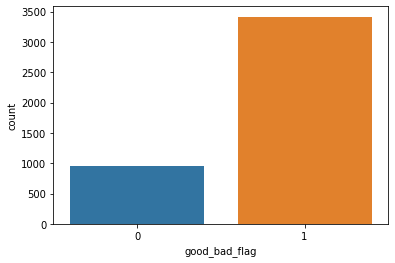

In [47]:
#Distrubute of target variable
sns.countplot(train_df['good_bad_flag'])
#Imbalance Data ->  only 22% raised flag

In [48]:
#Termdays
a=train_df[['termdays', 'good_bad_flag','customerid']].groupby(['termdays'], as_index=False).agg({'good_bad_flag':['mean'],'customerid':['count']})
a.columns=['termdays','good_bad_flag','sample_size']
a.sort_values(by='good_bad_flag',ascending=False)
#90 termdays is showing best; 15 termdays is the lowest

,termdays,good_bad_flag,sample_size
3,90,0.812500,32
1,30,0.784915,3129
2,60,0.774306,288
0,15,0.773667,919


In [49]:
#bank_account_type
b=train_df[['bank_account_type', 'good_bad_flag','customerid']].groupby(['bank_account_type'], as_index=False).agg({'good_bad_flag':['mean'],'customerid':['count']})
b.columns=['bank_account_type','good_bad_flag','sample_size']
b.sort_values(by='good_bad_flag',ascending=False)
#Saving account has the higheat chance of default

,bank_account_type,good_bad_flag,sample_size
0,Current,0.890625,64
1,Other,0.852311,887
2,Savings,0.761779,3417


In [50]:
#employment_status_clients
d=train_df[['employment_status_clients', 'good_bad_flag','customerid']].groupby(['employment_status_clients'], as_index=False).agg({'good_bad_flag':['mean'],'customerid':['count']})
d.columns=['employment_status_clients','good_bad_flag','sample_size']
d.sort_values(by='good_bad_flag',ascending=False)
#Group Contract, Unemployed, Retired and Student as Other

,employment_status_clients,good_bad_flag,sample_size
0,Contract,1.000000,2
5,Unemployed,0.822581,62
3,Self-Employed,0.817935,368
1,Permanent,0.795847,3130
2,Retired,0.714286,7
4,Student,0.711268,142


In [51]:
#other=['Contract','Retired','Unemployed']
#train_df['employment_status_clients']=train_df['employment_status_clients'].apply(lambda x: 'Other' if x in other else x)
#test_df['employment_status_clients']=test_df['employment_status_clients'].apply(lambda x: 'Other' if x in other else x)

#fill NA with Mode
train_df['employment_status_clients'].fillna('Permanent',inplace=True)
test_df['employment_status_clients'].fillna('Permanent',inplace=True)

In [52]:
#new employment_status_clients
d=train_df[['employment_status_clients', 'good_bad_flag','customerid']].groupby(['employment_status_clients'], as_index=False).agg({'good_bad_flag':['mean'],'customerid':['count']})
d.columns=['employment_status_clients','good_bad_flag','sample_size']
d.sort_values(by='good_bad_flag',ascending=False)

,employment_status_clients,good_bad_flag,sample_size
0,Contract,1.000000,2
5,Unemployed,0.822581,62
3,Self-Employed,0.817935,368
1,Permanent,0.780565,3787
2,Retired,0.714286,7
4,Student,0.711268,142


In [53]:
#bank_name_clients
c=train_df[['bank_name_clients', 'good_bad_flag','customerid']].groupby(['bank_name_clients'], as_index=False).agg({'good_bad_flag':['mean'],'customerid':['count']})
c.columns=['bank_name_clients','good_bad_flag','sample_size']
c.sort_values(by='good_bad_flag',ascending=False)

,bank_name_clients,good_bad_flag,sample_size
11,Standard Chartered,0.941176,17
16,Wema Bank,0.920000,25
7,Heritage Bank,0.863636,22
1,Diamond Bank,0.859060,298
15,Unity Bank,0.833333,6
10,Stanbic IBTC,0.831169,154
8,Keystone Bank,0.800000,20
17,Zenith Bank,0.796774,310
6,GT Bank,0.783042,1604
14,Union Bank,0.782609,23


In [54]:
other=['Unity Bank','Standard Chartered','Keystone Bank','Heritage Bank','Union Bank','Wema Bank','Sterling Bank']
train_df['bank_name_clients']=train_df['bank_name_clients'].apply(lambda x: 'Other' if x in other else x)
test_df['bank_name_clients']=test_df['bank_name_clients'].apply(lambda x: 'Other' if x in other else x)

In [55]:
#new bank_name_clients
c=train_df[['bank_name_clients', 'good_bad_flag','customerid']].groupby(['bank_name_clients'], as_index=False).agg({'good_bad_flag':['mean'],'customerid':['count']})
c.columns=['bank_name_clients','good_bad_flag','sample_size']
c.sort_values(by='good_bad_flag',ascending=False)

,bank_name_clients,good_bad_flag,sample_size
1,Diamond Bank,0.859060,298
9,Stanbic IBTC,0.831169,154
11,Zenith Bank,0.796774,310
7,Other,0.787879,165
6,GT Bank,0.783042,1604
10,UBA,0.781341,343
5,First Bank,0.768696,575
0,Access Bank,0.764569,429
3,FCMB,0.754237,118
2,EcoBank,0.740506,158


In [56]:
#Drop 'bank_name_clients'
train_df.drop(['bank_name_clients'],axis=1,inplace=True)
test_df.drop(['bank_name_clients'],axis=1,inplace=True)

In [57]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4368 entries, 0 to 4367
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customerid                           4368 non-null   object 
 1   loanamount                           4368 non-null   float64
 2   totaldue                             4368 non-null   float64
 3   termdays                             4368 non-null   int64  
 4   good_bad_flag                        4368 non-null   int64  
 5   interest                             4368 non-null   float64
 6   bank_account_type                    4368 non-null   object 
 7   longitude_gps                        4368 non-null   float64
 8   latitude_gps                         4368 non-null   float64
 9   employment_status_clients            4368 non-null   object 
 10  Age                                  4368 non-null   int32  
 11  prev_totaldue_mean            

In [58]:
#Todolist in pipieline for transmation & imputation
#Numeric variables: fill missingvalue with mean
#Category: targeting encoding

#Before fit into model, remove customerid and store customerid of test
train_df.drop('customerid',axis=1,inplace=True)
submit_customerid = test_df['customerid']
submit_df=test_df.drop('customerid',axis=1)

In [59]:
train_df.head()

,loanamount,totaldue,termdays,good_bad_flag,interest,bank_account_type,longitude_gps,latitude_gps,employment_status_clients,Age,...,prev_loan_number,prev_termdays_mean,prev_approveDuration_mean,prev_Pay1st_Duration_mean,prev_Pay_Duration_mean,prev_1stpayment_ontime,prev_ontime,termdays_Pay_OnTime_1stPayment_mean,termdays_Pay_OnTime_mean,prev_avg_loan_duration
0,30000.0,34500.0,30,1,4500.0,Other,3.432010,6.433055,Permanent,50,...,11.0,30.0,1.637273,-0.909091,0.000000,8.0,7.0,30.000000,30.000000,31.818182
1,15000.0,17250.0,30,1,2250.0,Savings,3.885298,7.320700,Permanent,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20000.0,22250.0,15,1,2250.0,Other,11.139350,10.292041,Permanent,38,...,6.0,17.5,1.000000,0.833333,1.333333,5.0,5.0,18.000000,18.000000,26.666667
3,10000.0,11500.0,15,1,1500.0,Savings,3.985770,7.491708,Permanent,45,...,2.0,22.5,1.000000,7.500000,9.000000,0.0,0.0,25.274832,25.529267,32.000000
4,40000.0,44000.0,30,1,4000.0,Other,7.457913,9.076574,Permanent,36,...,8.0,37.5,1.001250,-3.125000,-10.125000,8.0,8.0,37.500000,37.500000,39.000000


# Fitting Model - CrossValidation

In [60]:
from sklearn.model_selection import train_test_split

x = train_df.drop(['good_bad_flag'], axis=1)
y = train_df['good_bad_flag']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=23)

In [61]:
x.columns[x.dtypes != 'object']

Index(['loanamount', 'totaldue', 'termdays', 'interest', 'longitude_gps',
       'latitude_gps', 'Age', 'prev_totaldue_mean', 'prev_loanamount_mean',
       'prev_loanamount_sum', 'prev_interest_mean', 'prev_loan_number',
       'prev_termdays_mean', 'prev_approveDuration_mean',
       'prev_Pay1st_Duration_mean', 'prev_Pay_Duration_mean',
       'prev_1stpayment_ontime', 'prev_ontime',
       'termdays_Pay_OnTime_1stPayment_mean', 'termdays_Pay_OnTime_mean',
       'prev_avg_loan_duration'],
      dtype='object')

In [62]:
x.columns[x.dtypes == 'object']

Index(['bank_account_type', 'employment_status_clients'], dtype='object')

# Logistic Regression

In [63]:
numeric_features = x.columns[x.dtypes != 'object']

categorical_features = x.columns[x.dtypes == 'object']

#drop_features = []

log = LogisticRegression(class_weight='balanced',random_state=23,solver='saga')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline(steps=[
      ('encoder', OneHotEncoder(handle_unknown='ignore')),
      ])

preprocessor = Pipeline(steps=[
      ('ct', ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            #('drop', 'drop', drop_features),
            #('log1p', FunctionTransformer(np.log1p, validate=False), numeric_features.tolist())
            ],
            remainder = 'drop', 
            sparse_threshold=0))
    ])

pipe = Pipeline(steps=[('preprocessor', preprocessor),  ('log', log)])

log_cv_scores = cross_val_score(pipe, x_train, y_train, scoring="accuracy", cv=10)
print(log_cv_scores)
print("Estimated Score: {:0.3f} +/- {:0.2f}".format(np.mean(log_cv_scores), np.std(log_cv_scores)))

C:\Users\jgong\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\jgong\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\jgong\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\jgong\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\jgong\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\jgong\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:354: Converge

[0.60285714 0.62571429 0.62285714 0.62285714 0.63037249 0.68481375
 0.66189112 0.64756447 0.63323782 0.63323782]
Estimated Score: 0.637 +/- 0.02


# KNN

In [64]:
numeric_features = x.columns[x.dtypes != 'object']

categorical_features = x.columns[x.dtypes == 'object']

#drop_features = []

knn = KNeighborsClassifier()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline(steps=[
      ('encoder', OneHotEncoder(handle_unknown='ignore')),
      ])

preprocessor = Pipeline(steps=[
      ('ct', ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            #('drop', 'drop', drop_features),
            #('log1p', FunctionTransformer(np.log1p, validate=False), numeric_features.tolist())
            ],
            remainder = 'drop', 
            sparse_threshold=0))
    ])

pipe = Pipeline(steps=[('preprocessor', preprocessor),  ('knn', knn)])

knn_cv_scores = cross_val_score(pipe, x_train, y_train, scoring="accuracy", cv=10)
print(knn_cv_scores)
print("Estimated Score: {:0.3f} +/- {:0.2f}".format(np.mean(knn_cv_scores), np.std(knn_cv_scores)))

[0.77142857 0.75714286 0.75714286 0.74857143 0.79369628 0.75644699
 0.81088825 0.76790831 0.75644699 0.73638968]
Estimated Score: 0.766 +/- 0.02


# SVM - linear

In [65]:
numeric_features = x.columns[x.dtypes != 'object']

categorical_features = x.columns[x.dtypes == 'object']

#drop_features = []

svm = SVC(kernel="rbf",random_state=23)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline(steps=[
      ('encoder', OneHotEncoder(handle_unknown='ignore')),
      ])

preprocessor = Pipeline(steps=[
      ('ct', ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            #('drop', 'drop', drop_features),
            #('log1p', FunctionTransformer(np.log1p, validate=False), numeric_features.tolist())
            ],
            remainder = 'drop', 
            sparse_threshold=0))
    ])

pipe = Pipeline(steps=[('preprocessor', preprocessor),  ('svm', svm)])

svm_cv_scores = cross_val_score(pipe, x_train, y_train, scoring="accuracy", cv=10)
print(svm_cv_scores)
print("Estimated Score: {:0.3f} +/- {:0.2f}".format(np.mean(svm_cv_scores), np.std(svm_cv_scores)))

[0.78285714 0.78571429 0.78857143 0.77714286 0.80229226 0.79942693
 0.80802292 0.7765043  0.7965616  0.78223496]
Estimated Score: 0.790 +/- 0.01


# Decision Tree

In [66]:
numeric_features = x.columns[x.dtypes != 'object']

categorical_features = x.columns[x.dtypes == 'object']

#drop_features = []

dt = DecisionTreeClassifier(random_state=23, criterion="entropy")

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline(steps=[
      ('encoder', OneHotEncoder(handle_unknown='ignore')),
      ])

preprocessor = Pipeline(steps=[
      ('ct', ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            #('drop', 'drop', drop_features)
            ],
            remainder = 'drop', 
            sparse_threshold=0)),
      #('feature_selector', SelectKBest(k=10)),
    ])

pipe = Pipeline(steps=[('preprocessor', preprocessor),  ('dt', dt)])

dt_cv_scores = cross_val_score(pipe, x_train, y_train, scoring="accuracy", cv=10)
print(dt_cv_scores)
print("Estimated Score: {:0.3f} +/- {:0.2f}".format(np.mean(dt_cv_scores), np.std(dt_cv_scores)))

[0.67142857 0.66       0.64       0.70285714 0.72492837 0.70200573
 0.6991404  0.69054441 0.7277937  0.67908309]
Estimated Score: 0.690 +/- 0.03


# Random Forests

In [67]:
numeric_features = x.columns[x.dtypes != 'object']

categorical_features = x.columns[x.dtypes == 'object']

#drop_features = []

rf = RandomForestClassifier(random_state=23, n_estimators=2000, n_jobs=-1)
#rf = RandomForestClassifier(random_state=23, n_estimators=2000, n_jobs=-1)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline(steps=[
      ('encoder', OneHotEncoder(handle_unknown='ignore')),
      ])

preprocessor = Pipeline(steps=[
      ('ct', ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            #('drop', 'drop', drop_features)
            ],
            remainder = 'drop', 
            sparse_threshold=0))
    ])

pipe = Pipeline(steps=[('preprocessor', preprocessor),  ('rf', rf)])

rf_cv_scores = cross_val_score(pipe, x_train, y_train, scoring="accuracy", cv=10)
print(rf_cv_scores)
print("Estimated Score: {:0.3f} +/- {:0.2f}".format(np.mean(rf_cv_scores), np.std(rf_cv_scores)))

[0.79714286 0.77142857 0.78571429 0.77142857 0.79083095 0.79942693
 0.80802292 0.78796562 0.77936963 0.77936963]
Estimated Score: 0.787 +/- 0.01


# Adaboost

In [68]:
numeric_features = x.columns[x.dtypes != 'object']

categorical_features = x.columns[x.dtypes == 'object']

#drop_features = []

#ab = AdaBoostClassifier(
#    base_estimator=DecisionTreeClassifier(criterion="entropy",class_weight='balanced'), 
#    n_estimators=2000, random_state=23)

ab = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(criterion="entropy"), 
    n_estimators=2000, random_state=23)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline(steps=[
      ('encoder', OneHotEncoder(handle_unknown='ignore')),
      ])

preprocessor = Pipeline(steps=[
      ('ct', ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            #('drop', 'drop', drop_features)
            ],
            remainder = 'drop', 
            sparse_threshold=0)),
      #('feature_selector', SelectKBest(k=10)),
    ])

pipe = Pipeline(steps=[('preprocessor', preprocessor),  ('ab', ab)])

ab_cv_scores = cross_val_score(pipe, x_train, y_train, scoring="accuracy", cv=10)
print(ab_cv_scores)
print("Estimated Score: {:0.3f} +/- {:0.2f}".format(np.mean(ab_cv_scores), np.std(ab_cv_scores)))

[0.66285714 0.67142857 0.65714286 0.72       0.71633238 0.70773639
 0.71060172 0.71060172 0.71919771 0.69340974]
Estimated Score: 0.697 +/- 0.02


# XGBoost

In [69]:
numeric_features = x.columns[x.dtypes != 'object']

categorical_features = x.columns[x.dtypes == 'object']

#drop_features = []

xg = XGBClassifier(n_estimators=2000, random_state=23)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline(steps=[
      ('encoder', OneHotEncoder(handle_unknown='ignore')),
      ])

preprocessor = Pipeline(steps=[
      ('ct', ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            #('drop', 'drop', drop_features)
            ],
            remainder = 'drop', 
            sparse_threshold=0)),
      #('feature_selector', SelectKBest(k=10)),
    ])

pipe = Pipeline(steps=[('preprocessor', preprocessor),  ('xg', xg)])

xg_cv_scores = cross_val_score(pipe, x_train, y_train, scoring="accuracy", cv=10)
print(xg_cv_scores)
print("Estimated Score: {:0.3f} +/- {:0.2f}".format(np.mean(xg_cv_scores), np.std(xg_cv_scores)))

[01:28:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jgong\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\jgong\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:28:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jgong\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:28:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jgong\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:28:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jgong\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:28:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jgong\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:28:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jgong\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:28:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jgong\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:28:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jgong\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:28:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jgong\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:28:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.76285714 0.74857143 0.75142857 0.77142857 0.7765043  0.75931232
 0.78223496 0.78223496 0.75644699 0.75071633]
Estimated Score: 0.764 +/- 0.01


# CatBoost

In [70]:
#pip install catboost

numeric_features = x.columns[x.dtypes != 'object']

categorical_features = x.columns[x.dtypes == 'object']

#drop_features = []

#CatB = CatBoostClassifier(n_estimators=2000,random_state=0,auto_class_weights='Balanced')


CatB = CatBoostClassifier(n_estimators=2000,random_state=55)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline(steps=[
      ('encoder', OneHotEncoder(handle_unknown='ignore')),
      ])

preprocessor = Pipeline(steps=[
      ('ct', ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            #('drop', 'drop', drop_features)
            ],
            remainder = 'drop', 
            sparse_threshold=0)),
      #('feature_selector', SelectKBest(k=10)),
    ])

pipe = Pipeline(steps=[('preprocessor', preprocessor),  ('CatB', CatB)])

CatB_cv_scores = cross_val_score(pipe, x_train, y_train, scoring="accuracy", cv=10)
print(CatB_cv_scores)
print("Estimated Score: {:0.3f} +/- {:0.2f}".format(np.mean(CatB_cv_scores), np.std(CatB_cv_scores)))

Learning rate set to 0.008898
0:	learn: 0.6891762	total: 142ms	remaining: 4m 44s
1:	learn: 0.6851804	total: 145ms	remaining: 2m 25s
2:	learn: 0.6813456	total: 148ms	remaining: 1m 38s
3:	learn: 0.6775894	total: 151ms	remaining: 1m 15s
4:	learn: 0.6738688	total: 154ms	remaining: 1m 1s
5:	learn: 0.6702311	total: 156ms	remaining: 52s
6:	learn: 0.6665295	total: 159ms	remaining: 45.3s
7:	learn: 0.6629758	total: 162ms	remaining: 40.2s
8:	learn: 0.6592160	total: 164ms	remaining: 36.3s
9:	learn: 0.6557284	total: 167ms	remaining: 33.2s
10:	learn: 0.6525269	total: 169ms	remaining: 30.6s
11:	learn: 0.6491282	total: 172ms	remaining: 28.5s
12:	learn: 0.6458939	total: 175ms	remaining: 26.7s
13:	learn: 0.6428728	total: 177ms	remaining: 25.2s
14:	learn: 0.6397415	total: 180ms	remaining: 23.8s
15:	learn: 0.6366617	total: 183ms	remaining: 22.7s
16:	learn: 0.6336424	total: 186ms	remaining: 21.7s
17:	learn: 0.6308433	total: 189ms	remaining: 20.8s
18:	learn: 0.6278449	total: 191ms	remaining: 19.9s
19:	learn

170:	learn: 0.4736464	total: 530ms	remaining: 5.67s
171:	learn: 0.4734668	total: 533ms	remaining: 5.66s
172:	learn: 0.4732645	total: 535ms	remaining: 5.64s
173:	learn: 0.4730042	total: 537ms	remaining: 5.63s
174:	learn: 0.4727550	total: 539ms	remaining: 5.62s
175:	learn: 0.4724830	total: 541ms	remaining: 5.61s
176:	learn: 0.4722501	total: 543ms	remaining: 5.59s
177:	learn: 0.4720435	total: 545ms	remaining: 5.58s
178:	learn: 0.4718329	total: 547ms	remaining: 5.57s
179:	learn: 0.4715263	total: 550ms	remaining: 5.56s
180:	learn: 0.4713184	total: 552ms	remaining: 5.55s
181:	learn: 0.4711113	total: 554ms	remaining: 5.53s
182:	learn: 0.4710250	total: 555ms	remaining: 5.51s
183:	learn: 0.4708384	total: 558ms	remaining: 5.51s
184:	learn: 0.4705780	total: 560ms	remaining: 5.5s
185:	learn: 0.4701946	total: 562ms	remaining: 5.48s
186:	learn: 0.4699471	total: 564ms	remaining: 5.47s
187:	learn: 0.4697123	total: 566ms	remaining: 5.46s
188:	learn: 0.4695784	total: 569ms	remaining: 5.45s
189:	learn: 0

372:	learn: 0.4415965	total: 1.01s	remaining: 4.4s
373:	learn: 0.4414481	total: 1.01s	remaining: 4.39s
374:	learn: 0.4413003	total: 1.01s	remaining: 4.39s
375:	learn: 0.4411682	total: 1.01s	remaining: 4.39s
376:	learn: 0.4411092	total: 1.02s	remaining: 4.38s
377:	learn: 0.4409598	total: 1.02s	remaining: 4.38s
378:	learn: 0.4408974	total: 1.02s	remaining: 4.38s
379:	learn: 0.4407582	total: 1.02s	remaining: 4.37s
380:	learn: 0.4406725	total: 1.03s	remaining: 4.37s
381:	learn: 0.4405195	total: 1.03s	remaining: 4.36s
382:	learn: 0.4403929	total: 1.03s	remaining: 4.36s
383:	learn: 0.4403204	total: 1.03s	remaining: 4.36s
384:	learn: 0.4401367	total: 1.04s	remaining: 4.35s
385:	learn: 0.4400307	total: 1.04s	remaining: 4.35s
386:	learn: 0.4398759	total: 1.04s	remaining: 4.34s
387:	learn: 0.4398159	total: 1.04s	remaining: 4.34s
388:	learn: 0.4396013	total: 1.05s	remaining: 4.34s
389:	learn: 0.4395064	total: 1.05s	remaining: 4.33s
390:	learn: 0.4393260	total: 1.05s	remaining: 4.33s
391:	learn: 0

535:	learn: 0.4262899	total: 1.4s	remaining: 3.81s
536:	learn: 0.4262213	total: 1.4s	remaining: 3.81s
537:	learn: 0.4261114	total: 1.4s	remaining: 3.81s
538:	learn: 0.4259934	total: 1.4s	remaining: 3.81s
539:	learn: 0.4258620	total: 1.41s	remaining: 3.8s
540:	learn: 0.4257652	total: 1.41s	remaining: 3.8s
541:	learn: 0.4256807	total: 1.41s	remaining: 3.8s
542:	learn: 0.4255894	total: 1.41s	remaining: 3.8s
543:	learn: 0.4255121	total: 1.42s	remaining: 3.79s
544:	learn: 0.4254007	total: 1.42s	remaining: 3.79s
545:	learn: 0.4252743	total: 1.42s	remaining: 3.79s
546:	learn: 0.4251413	total: 1.42s	remaining: 3.78s
547:	learn: 0.4250887	total: 1.43s	remaining: 3.78s
548:	learn: 0.4249958	total: 1.43s	remaining: 3.78s
549:	learn: 0.4248941	total: 1.43s	remaining: 3.77s
550:	learn: 0.4247974	total: 1.43s	remaining: 3.77s
551:	learn: 0.4246966	total: 1.44s	remaining: 3.77s
552:	learn: 0.4245192	total: 1.44s	remaining: 3.77s
553:	learn: 0.4244131	total: 1.44s	remaining: 3.76s
554:	learn: 0.424327

737:	learn: 0.4101679	total: 1.88s	remaining: 3.22s
738:	learn: 0.4101138	total: 1.89s	remaining: 3.22s
739:	learn: 0.4100005	total: 1.89s	remaining: 3.22s
740:	learn: 0.4098871	total: 1.89s	remaining: 3.21s
741:	learn: 0.4097415	total: 1.89s	remaining: 3.21s
742:	learn: 0.4096891	total: 1.9s	remaining: 3.21s
743:	learn: 0.4096102	total: 1.9s	remaining: 3.21s
744:	learn: 0.4095335	total: 1.9s	remaining: 3.2s
745:	learn: 0.4093836	total: 1.9s	remaining: 3.2s
746:	learn: 0.4092804	total: 1.91s	remaining: 3.2s
747:	learn: 0.4091882	total: 1.91s	remaining: 3.19s
748:	learn: 0.4091432	total: 1.91s	remaining: 3.19s
749:	learn: 0.4090576	total: 1.91s	remaining: 3.19s
750:	learn: 0.4089981	total: 1.92s	remaining: 3.19s
751:	learn: 0.4089102	total: 1.92s	remaining: 3.19s
752:	learn: 0.4088518	total: 1.92s	remaining: 3.18s
753:	learn: 0.4087769	total: 1.92s	remaining: 3.18s
754:	learn: 0.4087376	total: 1.93s	remaining: 3.18s
755:	learn: 0.4087091	total: 1.93s	remaining: 3.17s
756:	learn: 0.40866

952:	learn: 0.3933543	total: 2.41s	remaining: 2.64s
953:	learn: 0.3932374	total: 2.41s	remaining: 2.64s
954:	learn: 0.3931352	total: 2.41s	remaining: 2.64s
955:	learn: 0.3930059	total: 2.41s	remaining: 2.64s
956:	learn: 0.3929138	total: 2.42s	remaining: 2.63s
957:	learn: 0.3928529	total: 2.42s	remaining: 2.63s
958:	learn: 0.3928022	total: 2.42s	remaining: 2.63s
959:	learn: 0.3927353	total: 2.42s	remaining: 2.63s
960:	learn: 0.3926533	total: 2.42s	remaining: 2.62s
961:	learn: 0.3925480	total: 2.43s	remaining: 2.62s
962:	learn: 0.3924988	total: 2.43s	remaining: 2.62s
963:	learn: 0.3923965	total: 2.43s	remaining: 2.61s
964:	learn: 0.3923275	total: 2.44s	remaining: 2.61s
965:	learn: 0.3922464	total: 2.44s	remaining: 2.61s
966:	learn: 0.3922037	total: 2.44s	remaining: 2.61s
967:	learn: 0.3921164	total: 2.45s	remaining: 2.61s
968:	learn: 0.3920758	total: 2.45s	remaining: 2.61s
969:	learn: 0.3920228	total: 2.46s	remaining: 2.61s
970:	learn: 0.3919596	total: 2.46s	remaining: 2.61s
971:	learn: 

1112:	learn: 0.3815089	total: 2.79s	remaining: 2.22s
1113:	learn: 0.3813428	total: 2.79s	remaining: 2.22s
1114:	learn: 0.3812359	total: 2.79s	remaining: 2.21s
1115:	learn: 0.3811819	total: 2.79s	remaining: 2.21s
1116:	learn: 0.3811473	total: 2.79s	remaining: 2.21s
1117:	learn: 0.3810686	total: 2.8s	remaining: 2.21s
1118:	learn: 0.3810224	total: 2.8s	remaining: 2.2s
1119:	learn: 0.3809457	total: 2.8s	remaining: 2.2s
1120:	learn: 0.3808468	total: 2.8s	remaining: 2.2s
1121:	learn: 0.3808174	total: 2.81s	remaining: 2.19s
1122:	learn: 0.3807762	total: 2.81s	remaining: 2.19s
1123:	learn: 0.3807392	total: 2.81s	remaining: 2.19s
1124:	learn: 0.3805647	total: 2.81s	remaining: 2.19s
1125:	learn: 0.3804811	total: 2.81s	remaining: 2.19s
1126:	learn: 0.3803922	total: 2.82s	remaining: 2.18s
1127:	learn: 0.3803608	total: 2.82s	remaining: 2.18s
1128:	learn: 0.3802635	total: 2.82s	remaining: 2.18s
1129:	learn: 0.3801914	total: 2.82s	remaining: 2.17s
1130:	learn: 0.3801136	total: 2.83s	remaining: 2.17s


1330:	learn: 0.3639887	total: 3.27s	remaining: 1.65s
1331:	learn: 0.3638910	total: 3.28s	remaining: 1.64s
1332:	learn: 0.3637757	total: 3.28s	remaining: 1.64s
1333:	learn: 0.3637076	total: 3.28s	remaining: 1.64s
1334:	learn: 0.3636423	total: 3.28s	remaining: 1.64s
1335:	learn: 0.3635344	total: 3.29s	remaining: 1.63s
1336:	learn: 0.3634697	total: 3.29s	remaining: 1.63s
1337:	learn: 0.3634144	total: 3.29s	remaining: 1.63s
1338:	learn: 0.3632875	total: 3.29s	remaining: 1.63s
1339:	learn: 0.3632214	total: 3.29s	remaining: 1.62s
1340:	learn: 0.3631397	total: 3.3s	remaining: 1.62s
1341:	learn: 0.3630806	total: 3.3s	remaining: 1.62s
1342:	learn: 0.3629934	total: 3.3s	remaining: 1.61s
1343:	learn: 0.3629001	total: 3.3s	remaining: 1.61s
1344:	learn: 0.3628367	total: 3.31s	remaining: 1.61s
1345:	learn: 0.3627486	total: 3.31s	remaining: 1.61s
1346:	learn: 0.3626704	total: 3.31s	remaining: 1.6s
1347:	learn: 0.3625919	total: 3.31s	remaining: 1.6s
1348:	learn: 0.3624978	total: 3.31s	remaining: 1.6s


1502:	learn: 0.3505122	total: 3.66s	remaining: 1.21s
1503:	learn: 0.3504678	total: 3.66s	remaining: 1.21s
1504:	learn: 0.3503706	total: 3.66s	remaining: 1.2s
1505:	learn: 0.3503498	total: 3.66s	remaining: 1.2s
1506:	learn: 0.3502201	total: 3.67s	remaining: 1.2s
1507:	learn: 0.3501476	total: 3.67s	remaining: 1.2s
1508:	learn: 0.3500835	total: 3.67s	remaining: 1.19s
1509:	learn: 0.3499702	total: 3.67s	remaining: 1.19s
1510:	learn: 0.3499107	total: 3.68s	remaining: 1.19s
1511:	learn: 0.3497358	total: 3.68s	remaining: 1.19s
1512:	learn: 0.3496806	total: 3.68s	remaining: 1.18s
1513:	learn: 0.3496138	total: 3.68s	remaining: 1.18s
1514:	learn: 0.3495132	total: 3.68s	remaining: 1.18s
1515:	learn: 0.3494675	total: 3.69s	remaining: 1.18s
1516:	learn: 0.3494363	total: 3.69s	remaining: 1.17s
1517:	learn: 0.3493244	total: 3.69s	remaining: 1.17s
1518:	learn: 0.3492128	total: 3.69s	remaining: 1.17s
1519:	learn: 0.3491185	total: 3.7s	remaining: 1.17s
1520:	learn: 0.3490372	total: 3.7s	remaining: 1.16s

1697:	learn: 0.3365037	total: 4.14s	remaining: 736ms
1698:	learn: 0.3363902	total: 4.14s	remaining: 734ms
1699:	learn: 0.3363053	total: 4.14s	remaining: 732ms
1700:	learn: 0.3362163	total: 4.15s	remaining: 729ms
1701:	learn: 0.3361627	total: 4.15s	remaining: 727ms
1702:	learn: 0.3361031	total: 4.15s	remaining: 724ms
1703:	learn: 0.3359913	total: 4.16s	remaining: 722ms
1704:	learn: 0.3359173	total: 4.16s	remaining: 720ms
1705:	learn: 0.3358285	total: 4.16s	remaining: 717ms
1706:	learn: 0.3357356	total: 4.16s	remaining: 715ms
1707:	learn: 0.3356931	total: 4.17s	remaining: 712ms
1708:	learn: 0.3355638	total: 4.17s	remaining: 710ms
1709:	learn: 0.3355126	total: 4.17s	remaining: 708ms
1710:	learn: 0.3354260	total: 4.18s	remaining: 706ms
1711:	learn: 0.3353448	total: 4.19s	remaining: 705ms
1712:	learn: 0.3352721	total: 4.2s	remaining: 703ms
1713:	learn: 0.3351977	total: 4.2s	remaining: 701ms
1714:	learn: 0.3351350	total: 4.21s	remaining: 699ms
1715:	learn: 0.3350836	total: 4.21s	remaining: 6

1902:	learn: 0.3224155	total: 4.66s	remaining: 238ms
1903:	learn: 0.3223627	total: 4.67s	remaining: 235ms
1904:	learn: 0.3222911	total: 4.67s	remaining: 233ms
1905:	learn: 0.3221594	total: 4.67s	remaining: 230ms
1906:	learn: 0.3221092	total: 4.67s	remaining: 228ms
1907:	learn: 0.3220604	total: 4.67s	remaining: 225ms
1908:	learn: 0.3219999	total: 4.68s	remaining: 223ms
1909:	learn: 0.3219049	total: 4.68s	remaining: 220ms
1910:	learn: 0.3218509	total: 4.68s	remaining: 218ms
1911:	learn: 0.3217627	total: 4.68s	remaining: 216ms
1912:	learn: 0.3217456	total: 4.68s	remaining: 213ms
1913:	learn: 0.3216828	total: 4.69s	remaining: 211ms
1914:	learn: 0.3216208	total: 4.69s	remaining: 208ms
1915:	learn: 0.3215926	total: 4.69s	remaining: 206ms
1916:	learn: 0.3215043	total: 4.69s	remaining: 203ms
1917:	learn: 0.3214127	total: 4.7s	remaining: 201ms
1918:	learn: 0.3213471	total: 4.7s	remaining: 198ms
1919:	learn: 0.3212964	total: 4.7s	remaining: 196ms
1920:	learn: 0.3212108	total: 4.7s	remaining: 193

97:	learn: 0.5060179	total: 216ms	remaining: 4.19s
98:	learn: 0.5054093	total: 218ms	remaining: 4.19s
99:	learn: 0.5047398	total: 220ms	remaining: 4.18s
100:	learn: 0.5040541	total: 222ms	remaining: 4.18s
101:	learn: 0.5033722	total: 224ms	remaining: 4.17s
102:	learn: 0.5028144	total: 226ms	remaining: 4.17s
103:	learn: 0.5021188	total: 228ms	remaining: 4.16s
104:	learn: 0.5014061	total: 230ms	remaining: 4.16s
105:	learn: 0.5008311	total: 232ms	remaining: 4.15s
106:	learn: 0.5002556	total: 234ms	remaining: 4.15s
107:	learn: 0.4994845	total: 236ms	remaining: 4.14s
108:	learn: 0.4988766	total: 238ms	remaining: 4.14s
109:	learn: 0.4983315	total: 240ms	remaining: 4.13s
110:	learn: 0.4976354	total: 242ms	remaining: 4.13s
111:	learn: 0.4970155	total: 244ms	remaining: 4.12s
112:	learn: 0.4965064	total: 247ms	remaining: 4.12s
113:	learn: 0.4959239	total: 249ms	remaining: 4.12s
114:	learn: 0.4953203	total: 251ms	remaining: 4.11s
115:	learn: 0.4947357	total: 253ms	remaining: 4.11s
116:	learn: 0.4

264:	learn: 0.4546822	total: 561ms	remaining: 3.67s
265:	learn: 0.4545331	total: 563ms	remaining: 3.67s
266:	learn: 0.4543766	total: 565ms	remaining: 3.67s
267:	learn: 0.4542455	total: 568ms	remaining: 3.67s
268:	learn: 0.4541150	total: 570ms	remaining: 3.67s
269:	learn: 0.4539322	total: 572ms	remaining: 3.67s
270:	learn: 0.4537966	total: 574ms	remaining: 3.67s
271:	learn: 0.4536505	total: 577ms	remaining: 3.66s
272:	learn: 0.4535117	total: 579ms	remaining: 3.66s
273:	learn: 0.4533524	total: 581ms	remaining: 3.66s
274:	learn: 0.4532509	total: 583ms	remaining: 3.66s
275:	learn: 0.4531319	total: 585ms	remaining: 3.65s
276:	learn: 0.4530503	total: 587ms	remaining: 3.65s
277:	learn: 0.4529046	total: 589ms	remaining: 3.65s
278:	learn: 0.4528077	total: 591ms	remaining: 3.65s
279:	learn: 0.4526663	total: 594ms	remaining: 3.65s
280:	learn: 0.4525932	total: 596ms	remaining: 3.64s
281:	learn: 0.4524537	total: 598ms	remaining: 3.64s
282:	learn: 0.4523112	total: 600ms	remaining: 3.64s
283:	learn: 

426:	learn: 0.4344547	total: 926ms	remaining: 3.41s
427:	learn: 0.4343674	total: 931ms	remaining: 3.42s
428:	learn: 0.4342707	total: 935ms	remaining: 3.42s
429:	learn: 0.4340998	total: 938ms	remaining: 3.42s
430:	learn: 0.4339576	total: 941ms	remaining: 3.43s
431:	learn: 0.4338678	total: 944ms	remaining: 3.43s
432:	learn: 0.4337016	total: 948ms	remaining: 3.43s
433:	learn: 0.4335934	total: 951ms	remaining: 3.43s
434:	learn: 0.4335662	total: 954ms	remaining: 3.43s
435:	learn: 0.4334408	total: 957ms	remaining: 3.43s
436:	learn: 0.4333279	total: 960ms	remaining: 3.43s
437:	learn: 0.4332258	total: 962ms	remaining: 3.43s
438:	learn: 0.4330997	total: 965ms	remaining: 3.43s
439:	learn: 0.4330058	total: 967ms	remaining: 3.43s
440:	learn: 0.4329424	total: 969ms	remaining: 3.43s
441:	learn: 0.4328225	total: 972ms	remaining: 3.42s
442:	learn: 0.4327309	total: 974ms	remaining: 3.42s
443:	learn: 0.4326570	total: 976ms	remaining: 3.42s
444:	learn: 0.4325237	total: 979ms	remaining: 3.42s
445:	learn: 

589:	learn: 0.4192527	total: 1.3s	remaining: 3.1s
590:	learn: 0.4191613	total: 1.3s	remaining: 3.1s
591:	learn: 0.4190279	total: 1.3s	remaining: 3.1s
592:	learn: 0.4189630	total: 1.3s	remaining: 3.09s
593:	learn: 0.4188755	total: 1.31s	remaining: 3.09s
594:	learn: 0.4188037	total: 1.31s	remaining: 3.09s
595:	learn: 0.4186878	total: 1.31s	remaining: 3.09s
596:	learn: 0.4185789	total: 1.31s	remaining: 3.08s
597:	learn: 0.4185255	total: 1.31s	remaining: 3.08s
598:	learn: 0.4184007	total: 1.32s	remaining: 3.08s
599:	learn: 0.4183283	total: 1.32s	remaining: 3.08s
600:	learn: 0.4182692	total: 1.32s	remaining: 3.08s
601:	learn: 0.4182398	total: 1.32s	remaining: 3.07s
602:	learn: 0.4181319	total: 1.33s	remaining: 3.07s
603:	learn: 0.4180620	total: 1.33s	remaining: 3.07s
604:	learn: 0.4180243	total: 1.33s	remaining: 3.07s
605:	learn: 0.4179490	total: 1.33s	remaining: 3.06s
606:	learn: 0.4179233	total: 1.33s	remaining: 3.06s
607:	learn: 0.4178204	total: 1.34s	remaining: 3.06s
608:	learn: 0.41778

749:	learn: 0.4066718	total: 1.65s	remaining: 2.74s
750:	learn: 0.4066278	total: 1.65s	remaining: 2.74s
751:	learn: 0.4065811	total: 1.65s	remaining: 2.74s
752:	learn: 0.4065372	total: 1.65s	remaining: 2.74s
753:	learn: 0.4064238	total: 1.66s	remaining: 2.74s
754:	learn: 0.4063800	total: 1.66s	remaining: 2.73s
755:	learn: 0.4063158	total: 1.66s	remaining: 2.73s
756:	learn: 0.4062518	total: 1.66s	remaining: 2.73s
757:	learn: 0.4061515	total: 1.66s	remaining: 2.73s
758:	learn: 0.4060413	total: 1.67s	remaining: 2.73s
759:	learn: 0.4059445	total: 1.67s	remaining: 2.72s
760:	learn: 0.4058638	total: 1.67s	remaining: 2.72s
761:	learn: 0.4058243	total: 1.67s	remaining: 2.72s
762:	learn: 0.4057865	total: 1.68s	remaining: 2.71s
763:	learn: 0.4057154	total: 1.68s	remaining: 2.71s
764:	learn: 0.4056727	total: 1.68s	remaining: 2.71s
765:	learn: 0.4056344	total: 1.68s	remaining: 2.71s
766:	learn: 0.4055454	total: 1.68s	remaining: 2.71s
767:	learn: 0.4054916	total: 1.69s	remaining: 2.7s
768:	learn: 0

960:	learn: 0.3909924	total: 2.13s	remaining: 2.3s
961:	learn: 0.3908950	total: 2.13s	remaining: 2.3s
962:	learn: 0.3908306	total: 2.13s	remaining: 2.29s
963:	learn: 0.3907268	total: 2.13s	remaining: 2.29s
964:	learn: 0.3906372	total: 2.14s	remaining: 2.29s
965:	learn: 0.3905041	total: 2.14s	remaining: 2.29s
966:	learn: 0.3904824	total: 2.14s	remaining: 2.29s
967:	learn: 0.3904588	total: 2.14s	remaining: 2.28s
968:	learn: 0.3903948	total: 2.15s	remaining: 2.28s
969:	learn: 0.3903276	total: 2.15s	remaining: 2.28s
970:	learn: 0.3902303	total: 2.15s	remaining: 2.28s
971:	learn: 0.3901108	total: 2.15s	remaining: 2.27s
972:	learn: 0.3900672	total: 2.15s	remaining: 2.27s
973:	learn: 0.3899666	total: 2.15s	remaining: 2.27s
974:	learn: 0.3898881	total: 2.16s	remaining: 2.27s
975:	learn: 0.3898003	total: 2.16s	remaining: 2.27s
976:	learn: 0.3896213	total: 2.16s	remaining: 2.26s
977:	learn: 0.3895650	total: 2.16s	remaining: 2.26s
978:	learn: 0.3894854	total: 2.17s	remaining: 2.26s
979:	learn: 0.

1124:	learn: 0.3773487	total: 2.48s	remaining: 1.93s
1125:	learn: 0.3772638	total: 2.49s	remaining: 1.93s
1126:	learn: 0.3771629	total: 2.49s	remaining: 1.93s
1127:	learn: 0.3770642	total: 2.49s	remaining: 1.93s
1128:	learn: 0.3769753	total: 2.5s	remaining: 1.92s
1129:	learn: 0.3769504	total: 2.5s	remaining: 1.92s
1130:	learn: 0.3768659	total: 2.5s	remaining: 1.92s
1131:	learn: 0.3767848	total: 2.5s	remaining: 1.92s
1132:	learn: 0.3765929	total: 2.5s	remaining: 1.92s
1133:	learn: 0.3764822	total: 2.51s	remaining: 1.91s
1134:	learn: 0.3763953	total: 2.51s	remaining: 1.91s
1135:	learn: 0.3763253	total: 2.51s	remaining: 1.91s
1136:	learn: 0.3762157	total: 2.51s	remaining: 1.91s
1137:	learn: 0.3760571	total: 2.51s	remaining: 1.9s
1138:	learn: 0.3759853	total: 2.52s	remaining: 1.9s
1139:	learn: 0.3758921	total: 2.52s	remaining: 1.9s
1140:	learn: 0.3757669	total: 2.52s	remaining: 1.9s
1141:	learn: 0.3756411	total: 2.52s	remaining: 1.9s
1142:	learn: 0.3755346	total: 2.53s	remaining: 1.89s
114

1280:	learn: 0.3644694	total: 2.83s	remaining: 1.59s
1281:	learn: 0.3643916	total: 2.83s	remaining: 1.58s
1282:	learn: 0.3642921	total: 2.83s	remaining: 1.58s
1283:	learn: 0.3642082	total: 2.83s	remaining: 1.58s
1284:	learn: 0.3641425	total: 2.84s	remaining: 1.58s
1285:	learn: 0.3640950	total: 2.84s	remaining: 1.58s
1286:	learn: 0.3640057	total: 2.84s	remaining: 1.57s
1287:	learn: 0.3639286	total: 2.84s	remaining: 1.57s
1288:	learn: 0.3639017	total: 2.85s	remaining: 1.57s
1289:	learn: 0.3637992	total: 2.85s	remaining: 1.57s
1290:	learn: 0.3637329	total: 2.85s	remaining: 1.56s
1291:	learn: 0.3636752	total: 2.85s	remaining: 1.56s
1292:	learn: 0.3636350	total: 2.85s	remaining: 1.56s
1293:	learn: 0.3635216	total: 2.86s	remaining: 1.56s
1294:	learn: 0.3634412	total: 2.86s	remaining: 1.56s
1295:	learn: 0.3634102	total: 2.86s	remaining: 1.55s
1296:	learn: 0.3633443	total: 2.86s	remaining: 1.55s
1297:	learn: 0.3632206	total: 2.87s	remaining: 1.55s
1298:	learn: 0.3630988	total: 2.87s	remaining:

1449:	learn: 0.3503758	total: 3.22s	remaining: 1.22s
1450:	learn: 0.3503242	total: 3.22s	remaining: 1.22s
1451:	learn: 0.3502283	total: 3.22s	remaining: 1.22s
1452:	learn: 0.3501776	total: 3.22s	remaining: 1.21s
1453:	learn: 0.3501480	total: 3.23s	remaining: 1.21s
1454:	learn: 0.3500921	total: 3.23s	remaining: 1.21s
1455:	learn: 0.3500352	total: 3.23s	remaining: 1.21s
1456:	learn: 0.3499962	total: 3.23s	remaining: 1.2s
1457:	learn: 0.3499323	total: 3.23s	remaining: 1.2s
1458:	learn: 0.3498823	total: 3.24s	remaining: 1.2s
1459:	learn: 0.3498260	total: 3.24s	remaining: 1.2s
1460:	learn: 0.3498072	total: 3.24s	remaining: 1.2s
1461:	learn: 0.3497457	total: 3.24s	remaining: 1.19s
1462:	learn: 0.3496447	total: 3.25s	remaining: 1.19s
1463:	learn: 0.3495466	total: 3.25s	remaining: 1.19s
1464:	learn: 0.3493652	total: 3.25s	remaining: 1.19s
1465:	learn: 0.3492760	total: 3.25s	remaining: 1.18s
1466:	learn: 0.3492217	total: 3.25s	remaining: 1.18s
1467:	learn: 0.3491609	total: 3.26s	remaining: 1.18

1669:	learn: 0.3344083	total: 3.71s	remaining: 734ms
1670:	learn: 0.3343715	total: 3.71s	remaining: 731ms
1671:	learn: 0.3343058	total: 3.72s	remaining: 729ms
1672:	learn: 0.3341979	total: 3.72s	remaining: 727ms
1673:	learn: 0.3341332	total: 3.72s	remaining: 725ms
1674:	learn: 0.3340918	total: 3.72s	remaining: 723ms
1675:	learn: 0.3340428	total: 3.73s	remaining: 720ms
1676:	learn: 0.3339862	total: 3.73s	remaining: 718ms
1677:	learn: 0.3338868	total: 3.73s	remaining: 716ms
1678:	learn: 0.3338455	total: 3.73s	remaining: 714ms
1679:	learn: 0.3337582	total: 3.73s	remaining: 711ms
1680:	learn: 0.3336972	total: 3.74s	remaining: 709ms
1681:	learn: 0.3336198	total: 3.74s	remaining: 707ms
1682:	learn: 0.3335598	total: 3.74s	remaining: 705ms
1683:	learn: 0.3334775	total: 3.74s	remaining: 702ms
1684:	learn: 0.3333747	total: 3.75s	remaining: 700ms
1685:	learn: 0.3333058	total: 3.75s	remaining: 698ms
1686:	learn: 0.3331537	total: 3.75s	remaining: 696ms
1687:	learn: 0.3330198	total: 3.75s	remaining:

1826:	learn: 0.3238437	total: 4.05s	remaining: 384ms
1827:	learn: 0.3237535	total: 4.06s	remaining: 382ms
1828:	learn: 0.3236826	total: 4.06s	remaining: 380ms
1829:	learn: 0.3235805	total: 4.06s	remaining: 377ms
1830:	learn: 0.3235199	total: 4.06s	remaining: 375ms
1831:	learn: 0.3234405	total: 4.07s	remaining: 373ms
1832:	learn: 0.3233811	total: 4.07s	remaining: 371ms
1833:	learn: 0.3232642	total: 4.07s	remaining: 368ms
1834:	learn: 0.3231526	total: 4.07s	remaining: 366ms
1835:	learn: 0.3230856	total: 4.07s	remaining: 364ms
1836:	learn: 0.3229947	total: 4.08s	remaining: 362ms
1837:	learn: 0.3229552	total: 4.08s	remaining: 360ms
1838:	learn: 0.3228940	total: 4.08s	remaining: 357ms
1839:	learn: 0.3227775	total: 4.08s	remaining: 355ms
1840:	learn: 0.3227447	total: 4.08s	remaining: 353ms
1841:	learn: 0.3226352	total: 4.09s	remaining: 351ms
1842:	learn: 0.3225731	total: 4.09s	remaining: 348ms
1843:	learn: 0.3224802	total: 4.09s	remaining: 346ms
1844:	learn: 0.3224126	total: 4.09s	remaining:

1988:	learn: 0.3128754	total: 4.41s	remaining: 24.4ms
1989:	learn: 0.3128370	total: 4.41s	remaining: 22.2ms
1990:	learn: 0.3127285	total: 4.42s	remaining: 20ms
1991:	learn: 0.3126692	total: 4.42s	remaining: 17.7ms
1992:	learn: 0.3126253	total: 4.42s	remaining: 15.5ms
1993:	learn: 0.3124911	total: 4.42s	remaining: 13.3ms
1994:	learn: 0.3124763	total: 4.42s	remaining: 11.1ms
1995:	learn: 0.3124033	total: 4.43s	remaining: 8.87ms
1996:	learn: 0.3123271	total: 4.43s	remaining: 6.66ms
1997:	learn: 0.3122927	total: 4.43s	remaining: 4.44ms
1998:	learn: 0.3122168	total: 4.43s	remaining: 2.22ms
1999:	learn: 0.3121881	total: 4.44s	remaining: 0us
Learning rate set to 0.008898
0:	learn: 0.6891336	total: 2.42ms	remaining: 4.84s
1:	learn: 0.6850893	total: 4.85ms	remaining: 4.84s
2:	learn: 0.6812041	total: 7.02ms	remaining: 4.67s
3:	learn: 0.6774358	total: 9.13ms	remaining: 4.55s
4:	learn: 0.6736557	total: 11.3ms	remaining: 4.5s
5:	learn: 0.6703528	total: 13.3ms	remaining: 4.44s
6:	learn: 0.6667411	to

172:	learn: 0.4722760	total: 364ms	remaining: 3.84s
173:	learn: 0.4720143	total: 366ms	remaining: 3.84s
174:	learn: 0.4716969	total: 369ms	remaining: 3.84s
175:	learn: 0.4714066	total: 371ms	remaining: 3.84s
176:	learn: 0.4710628	total: 373ms	remaining: 3.84s
177:	learn: 0.4708420	total: 375ms	remaining: 3.84s
178:	learn: 0.4704054	total: 378ms	remaining: 3.84s
179:	learn: 0.4702155	total: 380ms	remaining: 3.84s
180:	learn: 0.4699614	total: 382ms	remaining: 3.84s
181:	learn: 0.4697103	total: 384ms	remaining: 3.84s
182:	learn: 0.4695270	total: 387ms	remaining: 3.84s
183:	learn: 0.4692843	total: 389ms	remaining: 3.84s
184:	learn: 0.4690127	total: 391ms	remaining: 3.83s
185:	learn: 0.4687996	total: 393ms	remaining: 3.83s
186:	learn: 0.4685463	total: 395ms	remaining: 3.83s
187:	learn: 0.4683311	total: 397ms	remaining: 3.83s
188:	learn: 0.4680651	total: 399ms	remaining: 3.83s
189:	learn: 0.4677945	total: 402ms	remaining: 3.83s
190:	learn: 0.4675246	total: 404ms	remaining: 3.82s
191:	learn: 

330:	learn: 0.4446267	total: 705ms	remaining: 3.55s
331:	learn: 0.4444761	total: 707ms	remaining: 3.55s
332:	learn: 0.4443581	total: 710ms	remaining: 3.55s
333:	learn: 0.4442021	total: 712ms	remaining: 3.55s
334:	learn: 0.4440923	total: 714ms	remaining: 3.55s
335:	learn: 0.4439983	total: 716ms	remaining: 3.55s
336:	learn: 0.4438786	total: 719ms	remaining: 3.55s
337:	learn: 0.4437843	total: 721ms	remaining: 3.54s
338:	learn: 0.4436574	total: 723ms	remaining: 3.54s
339:	learn: 0.4435059	total: 725ms	remaining: 3.54s
340:	learn: 0.4434167	total: 727ms	remaining: 3.54s
341:	learn: 0.4431705	total: 729ms	remaining: 3.54s
342:	learn: 0.4429434	total: 732ms	remaining: 3.53s
343:	learn: 0.4428740	total: 734ms	remaining: 3.53s
344:	learn: 0.4426878	total: 736ms	remaining: 3.53s
345:	learn: 0.4425603	total: 738ms	remaining: 3.53s
346:	learn: 0.4424153	total: 740ms	remaining: 3.52s
347:	learn: 0.4422957	total: 742ms	remaining: 3.52s
348:	learn: 0.4422053	total: 744ms	remaining: 3.52s
349:	learn: 

493:	learn: 0.4274931	total: 1.06s	remaining: 3.23s
494:	learn: 0.4273793	total: 1.06s	remaining: 3.23s
495:	learn: 0.4272855	total: 1.06s	remaining: 3.23s
496:	learn: 0.4271383	total: 1.07s	remaining: 3.23s
497:	learn: 0.4270301	total: 1.07s	remaining: 3.23s
498:	learn: 0.4269718	total: 1.07s	remaining: 3.23s
499:	learn: 0.4269056	total: 1.07s	remaining: 3.22s
500:	learn: 0.4268182	total: 1.08s	remaining: 3.22s
501:	learn: 0.4266986	total: 1.08s	remaining: 3.22s
502:	learn: 0.4265905	total: 1.08s	remaining: 3.22s
503:	learn: 0.4265572	total: 1.08s	remaining: 3.21s
504:	learn: 0.4264693	total: 1.08s	remaining: 3.21s
505:	learn: 0.4263259	total: 1.09s	remaining: 3.21s
506:	learn: 0.4262328	total: 1.09s	remaining: 3.21s
507:	learn: 0.4261037	total: 1.09s	remaining: 3.21s
508:	learn: 0.4260251	total: 1.09s	remaining: 3.2s
509:	learn: 0.4259811	total: 1.09s	remaining: 3.2s
510:	learn: 0.4259349	total: 1.1s	remaining: 3.2s
511:	learn: 0.4259051	total: 1.1s	remaining: 3.2s
512:	learn: 0.4258

672:	learn: 0.4120293	total: 1.47s	remaining: 2.9s
673:	learn: 0.4118506	total: 1.47s	remaining: 2.9s
674:	learn: 0.4117969	total: 1.48s	remaining: 2.9s
675:	learn: 0.4116805	total: 1.48s	remaining: 2.89s
676:	learn: 0.4115958	total: 1.48s	remaining: 2.89s
677:	learn: 0.4115361	total: 1.48s	remaining: 2.89s
678:	learn: 0.4114867	total: 1.48s	remaining: 2.89s
679:	learn: 0.4114154	total: 1.49s	remaining: 2.88s
680:	learn: 0.4112773	total: 1.49s	remaining: 2.88s
681:	learn: 0.4112300	total: 1.49s	remaining: 2.88s
682:	learn: 0.4111560	total: 1.49s	remaining: 2.88s
683:	learn: 0.4110669	total: 1.5s	remaining: 2.88s
684:	learn: 0.4110400	total: 1.5s	remaining: 2.87s
685:	learn: 0.4109697	total: 1.5s	remaining: 2.87s
686:	learn: 0.4108428	total: 1.5s	remaining: 2.87s
687:	learn: 0.4107663	total: 1.5s	remaining: 2.87s
688:	learn: 0.4106591	total: 1.51s	remaining: 2.87s
689:	learn: 0.4105441	total: 1.51s	remaining: 2.86s
690:	learn: 0.4103871	total: 1.51s	remaining: 2.86s
691:	learn: 0.410320

883:	learn: 0.3943386	total: 1.93s	remaining: 2.44s
884:	learn: 0.3942196	total: 1.93s	remaining: 2.44s
885:	learn: 0.3941390	total: 1.94s	remaining: 2.43s
886:	learn: 0.3940491	total: 1.94s	remaining: 2.43s
887:	learn: 0.3938943	total: 1.94s	remaining: 2.43s
888:	learn: 0.3938006	total: 1.94s	remaining: 2.43s
889:	learn: 0.3937194	total: 1.94s	remaining: 2.42s
890:	learn: 0.3936836	total: 1.95s	remaining: 2.42s
891:	learn: 0.3936176	total: 1.95s	remaining: 2.42s
892:	learn: 0.3935059	total: 1.95s	remaining: 2.42s
893:	learn: 0.3934509	total: 1.95s	remaining: 2.42s
894:	learn: 0.3933945	total: 1.95s	remaining: 2.41s
895:	learn: 0.3933050	total: 1.96s	remaining: 2.41s
896:	learn: 0.3932403	total: 1.96s	remaining: 2.41s
897:	learn: 0.3931540	total: 1.96s	remaining: 2.41s
898:	learn: 0.3931302	total: 1.96s	remaining: 2.4s
899:	learn: 0.3930626	total: 1.97s	remaining: 2.4s
900:	learn: 0.3929206	total: 1.97s	remaining: 2.4s
901:	learn: 0.3928502	total: 1.97s	remaining: 2.4s
902:	learn: 0.39

1042:	learn: 0.3810979	total: 2.27s	remaining: 2.09s
1043:	learn: 0.3810134	total: 2.28s	remaining: 2.08s
1044:	learn: 0.3809405	total: 2.28s	remaining: 2.08s
1045:	learn: 0.3808751	total: 2.28s	remaining: 2.08s
1046:	learn: 0.3807768	total: 2.28s	remaining: 2.08s
1047:	learn: 0.3806879	total: 2.29s	remaining: 2.08s
1048:	learn: 0.3806128	total: 2.29s	remaining: 2.07s
1049:	learn: 0.3805040	total: 2.29s	remaining: 2.07s
1050:	learn: 0.3804421	total: 2.29s	remaining: 2.07s
1051:	learn: 0.3803796	total: 2.29s	remaining: 2.07s
1052:	learn: 0.3803076	total: 2.3s	remaining: 2.07s
1053:	learn: 0.3801657	total: 2.3s	remaining: 2.06s
1054:	learn: 0.3800852	total: 2.3s	remaining: 2.06s
1055:	learn: 0.3799600	total: 2.3s	remaining: 2.06s
1056:	learn: 0.3798527	total: 2.31s	remaining: 2.06s
1057:	learn: 0.3797313	total: 2.31s	remaining: 2.05s
1058:	learn: 0.3796767	total: 2.31s	remaining: 2.05s
1059:	learn: 0.3795988	total: 2.31s	remaining: 2.05s
1060:	learn: 0.3795340	total: 2.31s	remaining: 2.0

1208:	learn: 0.3682122	total: 2.63s	remaining: 1.72s
1209:	learn: 0.3681406	total: 2.63s	remaining: 1.72s
1210:	learn: 0.3681161	total: 2.64s	remaining: 1.72s
1211:	learn: 0.3679532	total: 2.64s	remaining: 1.72s
1212:	learn: 0.3678947	total: 2.64s	remaining: 1.71s
1213:	learn: 0.3678065	total: 2.64s	remaining: 1.71s
1214:	learn: 0.3676479	total: 2.65s	remaining: 1.71s
1215:	learn: 0.3675907	total: 2.65s	remaining: 1.71s
1216:	learn: 0.3675602	total: 2.65s	remaining: 1.71s
1217:	learn: 0.3674724	total: 2.65s	remaining: 1.7s
1218:	learn: 0.3673903	total: 2.65s	remaining: 1.7s
1219:	learn: 0.3672950	total: 2.66s	remaining: 1.7s
1220:	learn: 0.3671719	total: 2.66s	remaining: 1.7s
1221:	learn: 0.3671329	total: 2.66s	remaining: 1.7s
1222:	learn: 0.3670351	total: 2.66s	remaining: 1.69s
1223:	learn: 0.3669055	total: 2.67s	remaining: 1.69s
1224:	learn: 0.3667700	total: 2.67s	remaining: 1.69s
1225:	learn: 0.3666750	total: 2.67s	remaining: 1.69s
1226:	learn: 0.3665847	total: 2.67s	remaining: 1.68

1392:	learn: 0.3536371	total: 3.04s	remaining: 1.32s
1393:	learn: 0.3536143	total: 3.04s	remaining: 1.32s
1394:	learn: 0.3535114	total: 3.04s	remaining: 1.32s
1395:	learn: 0.3534142	total: 3.04s	remaining: 1.32s
1396:	learn: 0.3533870	total: 3.05s	remaining: 1.31s
1397:	learn: 0.3533632	total: 3.05s	remaining: 1.31s
1398:	learn: 0.3532424	total: 3.05s	remaining: 1.31s
1399:	learn: 0.3531277	total: 3.05s	remaining: 1.31s
1400:	learn: 0.3530228	total: 3.06s	remaining: 1.31s
1401:	learn: 0.3529398	total: 3.06s	remaining: 1.3s
1402:	learn: 0.3528564	total: 3.06s	remaining: 1.3s
1403:	learn: 0.3527681	total: 3.06s	remaining: 1.3s
1404:	learn: 0.3526833	total: 3.06s	remaining: 1.3s
1405:	learn: 0.3526691	total: 3.07s	remaining: 1.3s
1406:	learn: 0.3525636	total: 3.07s	remaining: 1.29s
1407:	learn: 0.3524928	total: 3.07s	remaining: 1.29s
1408:	learn: 0.3524303	total: 3.07s	remaining: 1.29s
1409:	learn: 0.3523388	total: 3.08s	remaining: 1.29s
1410:	learn: 0.3522175	total: 3.08s	remaining: 1.28

1591:	learn: 0.3386944	total: 3.5s	remaining: 897ms
1592:	learn: 0.3385647	total: 3.5s	remaining: 895ms
1593:	learn: 0.3384066	total: 3.5s	remaining: 893ms
1594:	learn: 0.3383494	total: 3.51s	remaining: 891ms
1595:	learn: 0.3382639	total: 3.51s	remaining: 888ms
1596:	learn: 0.3382265	total: 3.51s	remaining: 886ms
1597:	learn: 0.3381443	total: 3.51s	remaining: 884ms
1598:	learn: 0.3380670	total: 3.52s	remaining: 882ms
1599:	learn: 0.3380012	total: 3.52s	remaining: 880ms
1600:	learn: 0.3378374	total: 3.52s	remaining: 877ms
1601:	learn: 0.3377607	total: 3.52s	remaining: 875ms
1602:	learn: 0.3376912	total: 3.52s	remaining: 873ms
1603:	learn: 0.3375778	total: 3.53s	remaining: 871ms
1604:	learn: 0.3375125	total: 3.53s	remaining: 869ms
1605:	learn: 0.3374162	total: 3.53s	remaining: 866ms
1606:	learn: 0.3374072	total: 3.53s	remaining: 864ms
1607:	learn: 0.3373394	total: 3.54s	remaining: 862ms
1608:	learn: 0.3372826	total: 3.54s	remaining: 860ms
1609:	learn: 0.3371391	total: 3.54s	remaining: 85

1771:	learn: 0.3250909	total: 3.91s	remaining: 503ms
1772:	learn: 0.3249785	total: 3.91s	remaining: 501ms
1773:	learn: 0.3249502	total: 3.91s	remaining: 498ms
1774:	learn: 0.3248732	total: 3.91s	remaining: 496ms
1775:	learn: 0.3248122	total: 3.92s	remaining: 494ms
1776:	learn: 0.3247402	total: 3.92s	remaining: 492ms
1777:	learn: 0.3246538	total: 3.92s	remaining: 490ms
1778:	learn: 0.3245632	total: 3.92s	remaining: 487ms
1779:	learn: 0.3245288	total: 3.92s	remaining: 485ms
1780:	learn: 0.3245076	total: 3.93s	remaining: 483ms
1781:	learn: 0.3243977	total: 3.93s	remaining: 481ms
1782:	learn: 0.3243207	total: 3.93s	remaining: 479ms
1783:	learn: 0.3243052	total: 3.93s	remaining: 476ms
1784:	learn: 0.3242168	total: 3.94s	remaining: 474ms
1785:	learn: 0.3241631	total: 3.94s	remaining: 472ms
1786:	learn: 0.3240832	total: 3.94s	remaining: 470ms
1787:	learn: 0.3240227	total: 3.94s	remaining: 468ms
1788:	learn: 0.3239277	total: 3.94s	remaining: 465ms
1789:	learn: 0.3238446	total: 3.95s	remaining:

1934:	learn: 0.3144680	total: 4.26s	remaining: 143ms
1935:	learn: 0.3143815	total: 4.26s	remaining: 141ms
1936:	learn: 0.3142658	total: 4.27s	remaining: 139ms
1937:	learn: 0.3141822	total: 4.27s	remaining: 137ms
1938:	learn: 0.3140974	total: 4.27s	remaining: 134ms
1939:	learn: 0.3140604	total: 4.27s	remaining: 132ms
1940:	learn: 0.3140180	total: 4.28s	remaining: 130ms
1941:	learn: 0.3139557	total: 4.28s	remaining: 128ms
1942:	learn: 0.3138991	total: 4.28s	remaining: 126ms
1943:	learn: 0.3138053	total: 4.28s	remaining: 123ms
1944:	learn: 0.3137666	total: 4.28s	remaining: 121ms
1945:	learn: 0.3137225	total: 4.29s	remaining: 119ms
1946:	learn: 0.3136337	total: 4.29s	remaining: 117ms
1947:	learn: 0.3135781	total: 4.29s	remaining: 115ms
1948:	learn: 0.3135029	total: 4.29s	remaining: 112ms
1949:	learn: 0.3134217	total: 4.3s	remaining: 110ms
1950:	learn: 0.3133381	total: 4.3s	remaining: 108ms
1951:	learn: 0.3132709	total: 4.3s	remaining: 106ms
1952:	learn: 0.3132330	total: 4.3s	remaining: 104

123:	learn: 0.4893735	total: 343ms	remaining: 5.2s
124:	learn: 0.4889351	total: 346ms	remaining: 5.18s
125:	learn: 0.4884772	total: 348ms	remaining: 5.17s
126:	learn: 0.4879769	total: 350ms	remaining: 5.16s
127:	learn: 0.4875665	total: 352ms	remaining: 5.15s
128:	learn: 0.4871474	total: 354ms	remaining: 5.14s
129:	learn: 0.4866503	total: 356ms	remaining: 5.13s
130:	learn: 0.4861351	total: 358ms	remaining: 5.11s
131:	learn: 0.4857145	total: 361ms	remaining: 5.1s
132:	learn: 0.4852704	total: 363ms	remaining: 5.09s
133:	learn: 0.4847801	total: 365ms	remaining: 5.08s
134:	learn: 0.4844264	total: 367ms	remaining: 5.07s
135:	learn: 0.4841099	total: 369ms	remaining: 5.05s
136:	learn: 0.4837443	total: 371ms	remaining: 5.04s
137:	learn: 0.4833131	total: 373ms	remaining: 5.03s
138:	learn: 0.4828860	total: 375ms	remaining: 5.02s
139:	learn: 0.4824445	total: 377ms	remaining: 5.01s
140:	learn: 0.4820130	total: 379ms	remaining: 5s
141:	learn: 0.4816532	total: 381ms	remaining: 4.99s
142:	learn: 0.481

289:	learn: 0.4495204	total: 733ms	remaining: 4.32s
290:	learn: 0.4493931	total: 735ms	remaining: 4.32s
291:	learn: 0.4493268	total: 738ms	remaining: 4.32s
292:	learn: 0.4491429	total: 740ms	remaining: 4.31s
293:	learn: 0.4489183	total: 742ms	remaining: 4.31s
294:	learn: 0.4487179	total: 744ms	remaining: 4.3s
295:	learn: 0.4486339	total: 746ms	remaining: 4.3s
296:	learn: 0.4484385	total: 749ms	remaining: 4.29s
297:	learn: 0.4483283	total: 751ms	remaining: 4.29s
298:	learn: 0.4480922	total: 753ms	remaining: 4.28s
299:	learn: 0.4479356	total: 755ms	remaining: 4.28s
300:	learn: 0.4477025	total: 757ms	remaining: 4.27s
301:	learn: 0.4474967	total: 759ms	remaining: 4.27s
302:	learn: 0.4473166	total: 761ms	remaining: 4.26s
303:	learn: 0.4471856	total: 764ms	remaining: 4.26s
304:	learn: 0.4470401	total: 766ms	remaining: 4.25s
305:	learn: 0.4467891	total: 768ms	remaining: 4.25s
306:	learn: 0.4467012	total: 770ms	remaining: 4.25s
307:	learn: 0.4465893	total: 772ms	remaining: 4.24s
308:	learn: 0.

452:	learn: 0.4308886	total: 1.08s	remaining: 3.7s
453:	learn: 0.4308087	total: 1.08s	remaining: 3.69s
454:	learn: 0.4307441	total: 1.09s	remaining: 3.69s
455:	learn: 0.4306557	total: 1.09s	remaining: 3.69s
456:	learn: 0.4305830	total: 1.09s	remaining: 3.68s
457:	learn: 0.4304722	total: 1.09s	remaining: 3.68s
458:	learn: 0.4303537	total: 1.09s	remaining: 3.68s
459:	learn: 0.4302221	total: 1.1s	remaining: 3.68s
460:	learn: 0.4301157	total: 1.1s	remaining: 3.68s
461:	learn: 0.4300607	total: 1.1s	remaining: 3.68s
462:	learn: 0.4300164	total: 1.11s	remaining: 3.68s
463:	learn: 0.4299175	total: 1.11s	remaining: 3.69s
464:	learn: 0.4298396	total: 1.12s	remaining: 3.69s
465:	learn: 0.4296717	total: 1.12s	remaining: 3.69s
466:	learn: 0.4295137	total: 1.13s	remaining: 3.7s
467:	learn: 0.4294335	total: 1.13s	remaining: 3.7s
468:	learn: 0.4293520	total: 1.13s	remaining: 3.7s
469:	learn: 0.4292250	total: 1.14s	remaining: 3.7s
470:	learn: 0.4290861	total: 1.14s	remaining: 3.7s
471:	learn: 0.4290128

665:	learn: 0.4117335	total: 1.57s	remaining: 3.14s
666:	learn: 0.4116835	total: 1.57s	remaining: 3.14s
667:	learn: 0.4116047	total: 1.57s	remaining: 3.14s
668:	learn: 0.4115223	total: 1.58s	remaining: 3.13s
669:	learn: 0.4114884	total: 1.58s	remaining: 3.13s
670:	learn: 0.4114145	total: 1.58s	remaining: 3.13s
671:	learn: 0.4113269	total: 1.58s	remaining: 3.13s
672:	learn: 0.4111899	total: 1.58s	remaining: 3.12s
673:	learn: 0.4110905	total: 1.59s	remaining: 3.12s
674:	learn: 0.4110196	total: 1.59s	remaining: 3.12s
675:	learn: 0.4109534	total: 1.59s	remaining: 3.12s
676:	learn: 0.4109044	total: 1.59s	remaining: 3.11s
677:	learn: 0.4107735	total: 1.59s	remaining: 3.11s
678:	learn: 0.4106942	total: 1.6s	remaining: 3.11s
679:	learn: 0.4106155	total: 1.6s	remaining: 3.11s
680:	learn: 0.4105199	total: 1.6s	remaining: 3.1s
681:	learn: 0.4104228	total: 1.6s	remaining: 3.1s
682:	learn: 0.4103211	total: 1.61s	remaining: 3.1s
683:	learn: 0.4102935	total: 1.61s	remaining: 3.1s
684:	learn: 0.410200

839:	learn: 0.3974549	total: 1.96s	remaining: 2.7s
840:	learn: 0.3973814	total: 1.96s	remaining: 2.7s
841:	learn: 0.3973033	total: 1.96s	remaining: 2.69s
842:	learn: 0.3972098	total: 1.96s	remaining: 2.69s
843:	learn: 0.3971813	total: 1.96s	remaining: 2.69s
844:	learn: 0.3971398	total: 1.97s	remaining: 2.69s
845:	learn: 0.3971179	total: 1.97s	remaining: 2.69s
846:	learn: 0.3970203	total: 1.97s	remaining: 2.68s
847:	learn: 0.3968797	total: 1.97s	remaining: 2.68s
848:	learn: 0.3968521	total: 1.98s	remaining: 2.68s
849:	learn: 0.3967008	total: 1.98s	remaining: 2.68s
850:	learn: 0.3965526	total: 1.98s	remaining: 2.67s
851:	learn: 0.3964723	total: 1.98s	remaining: 2.67s
852:	learn: 0.3964174	total: 1.98s	remaining: 2.67s
853:	learn: 0.3963615	total: 1.99s	remaining: 2.67s
854:	learn: 0.3962710	total: 1.99s	remaining: 2.66s
855:	learn: 0.3961968	total: 1.99s	remaining: 2.66s
856:	learn: 0.3961478	total: 1.99s	remaining: 2.66s
857:	learn: 0.3960463	total: 2s	remaining: 2.65s
858:	learn: 0.395

998:	learn: 0.3846793	total: 2.3s	remaining: 2.31s
999:	learn: 0.3845826	total: 2.31s	remaining: 2.31s
1000:	learn: 0.3844847	total: 2.31s	remaining: 2.3s
1001:	learn: 0.3843389	total: 2.31s	remaining: 2.3s
1002:	learn: 0.3843031	total: 2.31s	remaining: 2.3s
1003:	learn: 0.3842225	total: 2.31s	remaining: 2.29s
1004:	learn: 0.3841190	total: 2.32s	remaining: 2.29s
1005:	learn: 0.3840353	total: 2.32s	remaining: 2.29s
1006:	learn: 0.3840069	total: 2.32s	remaining: 2.29s
1007:	learn: 0.3839062	total: 2.32s	remaining: 2.29s
1008:	learn: 0.3837578	total: 2.33s	remaining: 2.28s
1009:	learn: 0.3836557	total: 2.33s	remaining: 2.28s
1010:	learn: 0.3835791	total: 2.33s	remaining: 2.28s
1011:	learn: 0.3835537	total: 2.33s	remaining: 2.28s
1012:	learn: 0.3834792	total: 2.33s	remaining: 2.27s
1013:	learn: 0.3834176	total: 2.34s	remaining: 2.27s
1014:	learn: 0.3833735	total: 2.34s	remaining: 2.27s
1015:	learn: 0.3832300	total: 2.34s	remaining: 2.27s
1016:	learn: 0.3831452	total: 2.34s	remaining: 2.26s

1158:	learn: 0.3716080	total: 2.65s	remaining: 1.93s
1159:	learn: 0.3715298	total: 2.65s	remaining: 1.92s
1160:	learn: 0.3714613	total: 2.66s	remaining: 1.92s
1161:	learn: 0.3713688	total: 2.66s	remaining: 1.92s
1162:	learn: 0.3713227	total: 2.66s	remaining: 1.92s
1163:	learn: 0.3712039	total: 2.66s	remaining: 1.91s
1164:	learn: 0.3711678	total: 2.67s	remaining: 1.91s
1165:	learn: 0.3710466	total: 2.67s	remaining: 1.91s
1166:	learn: 0.3709371	total: 2.67s	remaining: 1.91s
1167:	learn: 0.3708114	total: 2.67s	remaining: 1.9s
1168:	learn: 0.3707520	total: 2.67s	remaining: 1.9s
1169:	learn: 0.3706670	total: 2.68s	remaining: 1.9s
1170:	learn: 0.3706340	total: 2.68s	remaining: 1.9s
1171:	learn: 0.3705712	total: 2.68s	remaining: 1.89s
1172:	learn: 0.3705242	total: 2.68s	remaining: 1.89s
1173:	learn: 0.3704375	total: 2.69s	remaining: 1.89s
1174:	learn: 0.3703723	total: 2.69s	remaining: 1.89s
1175:	learn: 0.3703038	total: 2.69s	remaining: 1.89s
1176:	learn: 0.3702479	total: 2.69s	remaining: 1.8

1316:	learn: 0.3590035	total: 3s	remaining: 1.56s
1317:	learn: 0.3589569	total: 3s	remaining: 1.55s
1318:	learn: 0.3588816	total: 3.01s	remaining: 1.55s
1319:	learn: 0.3587681	total: 3.01s	remaining: 1.55s
1320:	learn: 0.3586944	total: 3.01s	remaining: 1.55s
1321:	learn: 0.3586206	total: 3.01s	remaining: 1.55s
1322:	learn: 0.3585059	total: 3.02s	remaining: 1.54s
1323:	learn: 0.3584404	total: 3.02s	remaining: 1.54s
1324:	learn: 0.3583641	total: 3.02s	remaining: 1.54s
1325:	learn: 0.3583120	total: 3.02s	remaining: 1.54s
1326:	learn: 0.3581657	total: 3.02s	remaining: 1.53s
1327:	learn: 0.3580893	total: 3.03s	remaining: 1.53s
1328:	learn: 0.3579198	total: 3.03s	remaining: 1.53s
1329:	learn: 0.3578351	total: 3.03s	remaining: 1.53s
1330:	learn: 0.3577667	total: 3.03s	remaining: 1.52s
1331:	learn: 0.3576405	total: 3.04s	remaining: 1.52s
1332:	learn: 0.3574593	total: 3.04s	remaining: 1.52s
1333:	learn: 0.3573527	total: 3.04s	remaining: 1.52s
1334:	learn: 0.3572638	total: 3.04s	remaining: 1.51s

1527:	learn: 0.3425501	total: 3.49s	remaining: 1.08s
1528:	learn: 0.3424902	total: 3.49s	remaining: 1.07s
1529:	learn: 0.3424475	total: 3.49s	remaining: 1.07s
1530:	learn: 0.3423946	total: 3.5s	remaining: 1.07s
1531:	learn: 0.3423825	total: 3.5s	remaining: 1.07s
1532:	learn: 0.3423102	total: 3.5s	remaining: 1.07s
1533:	learn: 0.3422495	total: 3.5s	remaining: 1.06s
1534:	learn: 0.3421662	total: 3.5s	remaining: 1.06s
1535:	learn: 0.3420711	total: 3.51s	remaining: 1.06s
1536:	learn: 0.3420101	total: 3.51s	remaining: 1.06s
1537:	learn: 0.3419236	total: 3.51s	remaining: 1.05s
1538:	learn: 0.3418735	total: 3.51s	remaining: 1.05s
1539:	learn: 0.3417653	total: 3.52s	remaining: 1.05s
1540:	learn: 0.3416774	total: 3.52s	remaining: 1.05s
1541:	learn: 0.3416362	total: 3.52s	remaining: 1.04s
1542:	learn: 0.3415339	total: 3.52s	remaining: 1.04s
1543:	learn: 0.3414933	total: 3.52s	remaining: 1.04s
1544:	learn: 0.3413861	total: 3.53s	remaining: 1.04s
1545:	learn: 0.3413200	total: 3.53s	remaining: 1.04

1696:	learn: 0.3300996	total: 3.87s	remaining: 692ms
1697:	learn: 0.3300279	total: 3.88s	remaining: 689ms
1698:	learn: 0.3299847	total: 3.88s	remaining: 687ms
1699:	learn: 0.3298732	total: 3.88s	remaining: 685ms
1700:	learn: 0.3297787	total: 3.88s	remaining: 682ms
1701:	learn: 0.3297217	total: 3.88s	remaining: 680ms
1702:	learn: 0.3297174	total: 3.89s	remaining: 678ms
1703:	learn: 0.3296155	total: 3.89s	remaining: 676ms
1704:	learn: 0.3295601	total: 3.89s	remaining: 673ms
1705:	learn: 0.3295090	total: 3.89s	remaining: 671ms
1706:	learn: 0.3294495	total: 3.9s	remaining: 669ms
1707:	learn: 0.3294046	total: 3.9s	remaining: 666ms
1708:	learn: 0.3293471	total: 3.9s	remaining: 664ms
1709:	learn: 0.3292841	total: 3.9s	remaining: 662ms
1710:	learn: 0.3292280	total: 3.9s	remaining: 660ms
1711:	learn: 0.3291725	total: 3.91s	remaining: 657ms
1712:	learn: 0.3290947	total: 3.91s	remaining: 655ms
1713:	learn: 0.3289997	total: 3.91s	remaining: 653ms
1714:	learn: 0.3289278	total: 3.91s	remaining: 650m

1855:	learn: 0.3186077	total: 4.22s	remaining: 328ms
1856:	learn: 0.3185353	total: 4.23s	remaining: 325ms
1857:	learn: 0.3184757	total: 4.23s	remaining: 323ms
1858:	learn: 0.3184297	total: 4.23s	remaining: 321ms
1859:	learn: 0.3183763	total: 4.23s	remaining: 319ms
1860:	learn: 0.3182435	total: 4.24s	remaining: 316ms
1861:	learn: 0.3181618	total: 4.24s	remaining: 314ms
1862:	learn: 0.3180571	total: 4.24s	remaining: 312ms
1863:	learn: 0.3179831	total: 4.24s	remaining: 309ms
1864:	learn: 0.3179405	total: 4.24s	remaining: 307ms
1865:	learn: 0.3179007	total: 4.25s	remaining: 305ms
1866:	learn: 0.3178640	total: 4.25s	remaining: 303ms
1867:	learn: 0.3177894	total: 4.25s	remaining: 300ms
1868:	learn: 0.3177212	total: 4.25s	remaining: 298ms
1869:	learn: 0.3177113	total: 4.25s	remaining: 296ms
1870:	learn: 0.3176794	total: 4.26s	remaining: 294ms
1871:	learn: 0.3176007	total: 4.26s	remaining: 291ms
1872:	learn: 0.3175101	total: 4.26s	remaining: 289ms
1873:	learn: 0.3174188	total: 4.26s	remaining:

42:	learn: 0.5730355	total: 93.4ms	remaining: 4.25s
43:	learn: 0.5712614	total: 96ms	remaining: 4.27s
44:	learn: 0.5694640	total: 98.7ms	remaining: 4.29s
45:	learn: 0.5676797	total: 102ms	remaining: 4.32s
46:	learn: 0.5658909	total: 104ms	remaining: 4.33s
47:	learn: 0.5641203	total: 107ms	remaining: 4.34s
48:	learn: 0.5624129	total: 109ms	remaining: 4.35s
49:	learn: 0.5609880	total: 112ms	remaining: 4.36s
50:	learn: 0.5594376	total: 114ms	remaining: 4.37s
51:	learn: 0.5579005	total: 117ms	remaining: 4.38s
52:	learn: 0.5563025	total: 120ms	remaining: 4.4s
53:	learn: 0.5547938	total: 122ms	remaining: 4.41s
54:	learn: 0.5532370	total: 125ms	remaining: 4.41s
55:	learn: 0.5517680	total: 127ms	remaining: 4.42s
56:	learn: 0.5504041	total: 130ms	remaining: 4.42s
57:	learn: 0.5489164	total: 132ms	remaining: 4.43s
58:	learn: 0.5475038	total: 135ms	remaining: 4.44s
59:	learn: 0.5460979	total: 138ms	remaining: 4.45s
60:	learn: 0.5446328	total: 140ms	remaining: 4.45s
61:	learn: 0.5433681	total: 143

240:	learn: 0.4610485	total: 613ms	remaining: 4.48s
241:	learn: 0.4609091	total: 616ms	remaining: 4.47s
242:	learn: 0.4606795	total: 619ms	remaining: 4.47s
243:	learn: 0.4605042	total: 621ms	remaining: 4.47s
244:	learn: 0.4603826	total: 624ms	remaining: 4.47s
245:	learn: 0.4601902	total: 626ms	remaining: 4.46s
246:	learn: 0.4600038	total: 628ms	remaining: 4.46s
247:	learn: 0.4598782	total: 630ms	remaining: 4.45s
248:	learn: 0.4596201	total: 633ms	remaining: 4.45s
249:	learn: 0.4594537	total: 635ms	remaining: 4.45s
250:	learn: 0.4593034	total: 637ms	remaining: 4.44s
251:	learn: 0.4590495	total: 640ms	remaining: 4.44s
252:	learn: 0.4588246	total: 642ms	remaining: 4.43s
253:	learn: 0.4586937	total: 644ms	remaining: 4.43s
254:	learn: 0.4586230	total: 646ms	remaining: 4.42s
255:	learn: 0.4584168	total: 649ms	remaining: 4.42s
256:	learn: 0.4582475	total: 651ms	remaining: 4.41s
257:	learn: 0.4580545	total: 653ms	remaining: 4.41s
258:	learn: 0.4578388	total: 656ms	remaining: 4.41s
259:	learn: 

426:	learn: 0.4387554	total: 1.03s	remaining: 3.8s
427:	learn: 0.4386659	total: 1.03s	remaining: 3.8s
428:	learn: 0.4385900	total: 1.04s	remaining: 3.79s
429:	learn: 0.4385351	total: 1.04s	remaining: 3.79s
430:	learn: 0.4384288	total: 1.04s	remaining: 3.79s
431:	learn: 0.4383862	total: 1.04s	remaining: 3.79s
432:	learn: 0.4382446	total: 1.04s	remaining: 3.78s
433:	learn: 0.4381542	total: 1.05s	remaining: 3.78s
434:	learn: 0.4381046	total: 1.05s	remaining: 3.78s
435:	learn: 0.4380248	total: 1.05s	remaining: 3.77s
436:	learn: 0.4379103	total: 1.05s	remaining: 3.77s
437:	learn: 0.4377919	total: 1.06s	remaining: 3.77s
438:	learn: 0.4377030	total: 1.06s	remaining: 3.76s
439:	learn: 0.4375776	total: 1.06s	remaining: 3.76s
440:	learn: 0.4375068	total: 1.06s	remaining: 3.76s
441:	learn: 0.4373746	total: 1.06s	remaining: 3.76s
442:	learn: 0.4371920	total: 1.07s	remaining: 3.75s
443:	learn: 0.4370723	total: 1.07s	remaining: 3.75s
444:	learn: 0.4370140	total: 1.07s	remaining: 3.75s
445:	learn: 0.

607:	learn: 0.4226818	total: 1.48s	remaining: 3.39s
608:	learn: 0.4226059	total: 1.48s	remaining: 3.38s
609:	learn: 0.4225448	total: 1.48s	remaining: 3.38s
610:	learn: 0.4224695	total: 1.49s	remaining: 3.38s
611:	learn: 0.4223952	total: 1.49s	remaining: 3.38s
612:	learn: 0.4222744	total: 1.49s	remaining: 3.37s
613:	learn: 0.4221792	total: 1.49s	remaining: 3.37s
614:	learn: 0.4221230	total: 1.5s	remaining: 3.37s
615:	learn: 0.4220221	total: 1.5s	remaining: 3.36s
616:	learn: 0.4219916	total: 1.5s	remaining: 3.36s
617:	learn: 0.4219547	total: 1.5s	remaining: 3.36s
618:	learn: 0.4218843	total: 1.5s	remaining: 3.35s
619:	learn: 0.4218037	total: 1.5s	remaining: 3.35s
620:	learn: 0.4217400	total: 1.51s	remaining: 3.35s
621:	learn: 0.4216746	total: 1.51s	remaining: 3.34s
622:	learn: 0.4216279	total: 1.51s	remaining: 3.34s
623:	learn: 0.4214839	total: 1.51s	remaining: 3.34s
624:	learn: 0.4214144	total: 1.51s	remaining: 3.33s
625:	learn: 0.4213740	total: 1.52s	remaining: 3.33s
626:	learn: 0.4212

778:	learn: 0.4090306	total: 1.9s	remaining: 2.98s
779:	learn: 0.4089455	total: 1.9s	remaining: 2.98s
780:	learn: 0.4088206	total: 1.91s	remaining: 2.97s
781:	learn: 0.4087412	total: 1.91s	remaining: 2.97s
782:	learn: 0.4086255	total: 1.91s	remaining: 2.97s
783:	learn: 0.4085727	total: 1.91s	remaining: 2.96s
784:	learn: 0.4084985	total: 1.91s	remaining: 2.96s
785:	learn: 0.4084011	total: 1.92s	remaining: 2.96s
786:	learn: 0.4083261	total: 1.92s	remaining: 2.96s
787:	learn: 0.4082909	total: 1.92s	remaining: 2.95s
788:	learn: 0.4081604	total: 1.92s	remaining: 2.95s
789:	learn: 0.4080851	total: 1.92s	remaining: 2.95s
790:	learn: 0.4079678	total: 1.93s	remaining: 2.94s
791:	learn: 0.4079060	total: 1.93s	remaining: 2.94s
792:	learn: 0.4077668	total: 1.93s	remaining: 2.94s
793:	learn: 0.4076926	total: 1.93s	remaining: 2.94s
794:	learn: 0.4075772	total: 1.93s	remaining: 2.93s
795:	learn: 0.4075393	total: 1.94s	remaining: 2.93s
796:	learn: 0.4074324	total: 1.94s	remaining: 2.93s
797:	learn: 0.

948:	learn: 0.3951588	total: 2.26s	remaining: 2.5s
949:	learn: 0.3950784	total: 2.26s	remaining: 2.5s
950:	learn: 0.3949990	total: 2.26s	remaining: 2.5s
951:	learn: 0.3949433	total: 2.26s	remaining: 2.49s
952:	learn: 0.3947730	total: 2.27s	remaining: 2.49s
953:	learn: 0.3947098	total: 2.27s	remaining: 2.49s
954:	learn: 0.3945537	total: 2.27s	remaining: 2.49s
955:	learn: 0.3944449	total: 2.27s	remaining: 2.48s
956:	learn: 0.3943969	total: 2.28s	remaining: 2.48s
957:	learn: 0.3943158	total: 2.28s	remaining: 2.48s
958:	learn: 0.3942151	total: 2.28s	remaining: 2.48s
959:	learn: 0.3941465	total: 2.28s	remaining: 2.47s
960:	learn: 0.3940103	total: 2.28s	remaining: 2.47s
961:	learn: 0.3939659	total: 2.29s	remaining: 2.47s
962:	learn: 0.3939059	total: 2.29s	remaining: 2.46s
963:	learn: 0.3938115	total: 2.29s	remaining: 2.46s
964:	learn: 0.3937625	total: 2.29s	remaining: 2.46s
965:	learn: 0.3936901	total: 2.29s	remaining: 2.46s
966:	learn: 0.3936479	total: 2.3s	remaining: 2.45s
967:	learn: 0.39

1105:	learn: 0.3823585	total: 2.62s	remaining: 2.12s
1106:	learn: 0.3823098	total: 2.63s	remaining: 2.12s
1107:	learn: 0.3822568	total: 2.64s	remaining: 2.13s
1108:	learn: 0.3821794	total: 2.65s	remaining: 2.13s
1109:	learn: 0.3820649	total: 2.65s	remaining: 2.13s
1110:	learn: 0.3820110	total: 2.65s	remaining: 2.12s
1111:	learn: 0.3819473	total: 2.66s	remaining: 2.12s
1112:	learn: 0.3818879	total: 2.66s	remaining: 2.12s
1113:	learn: 0.3818590	total: 2.67s	remaining: 2.12s
1114:	learn: 0.3818007	total: 2.67s	remaining: 2.12s
1115:	learn: 0.3817212	total: 2.67s	remaining: 2.12s
1116:	learn: 0.3816780	total: 2.67s	remaining: 2.11s
1117:	learn: 0.3815741	total: 2.68s	remaining: 2.11s
1118:	learn: 0.3814056	total: 2.68s	remaining: 2.11s
1119:	learn: 0.3813389	total: 2.68s	remaining: 2.11s
1120:	learn: 0.3812687	total: 2.68s	remaining: 2.1s
1121:	learn: 0.3811656	total: 2.69s	remaining: 2.1s
1122:	learn: 0.3811188	total: 2.69s	remaining: 2.1s
1123:	learn: 0.3810290	total: 2.69s	remaining: 2.

1296:	learn: 0.3667442	total: 3.06s	remaining: 1.66s
1297:	learn: 0.3667223	total: 3.06s	remaining: 1.66s
1298:	learn: 0.3666502	total: 3.07s	remaining: 1.66s
1299:	learn: 0.3665605	total: 3.07s	remaining: 1.65s
1300:	learn: 0.3665369	total: 3.07s	remaining: 1.65s
1301:	learn: 0.3664378	total: 3.07s	remaining: 1.65s
1302:	learn: 0.3663668	total: 3.08s	remaining: 1.65s
1303:	learn: 0.3662076	total: 3.08s	remaining: 1.64s
1304:	learn: 0.3661194	total: 3.08s	remaining: 1.64s
1305:	learn: 0.3660262	total: 3.08s	remaining: 1.64s
1306:	learn: 0.3659288	total: 3.08s	remaining: 1.64s
1307:	learn: 0.3658143	total: 3.09s	remaining: 1.63s
1308:	learn: 0.3657126	total: 3.09s	remaining: 1.63s
1309:	learn: 0.3656192	total: 3.09s	remaining: 1.63s
1310:	learn: 0.3654814	total: 3.09s	remaining: 1.63s
1311:	learn: 0.3653868	total: 3.1s	remaining: 1.62s
1312:	learn: 0.3652850	total: 3.1s	remaining: 1.62s
1313:	learn: 0.3652083	total: 3.1s	remaining: 1.62s
1314:	learn: 0.3651232	total: 3.1s	remaining: 1.6

1483:	learn: 0.3519153	total: 3.5s	remaining: 1.22s
1484:	learn: 0.3518234	total: 3.5s	remaining: 1.21s
1485:	learn: 0.3517412	total: 3.5s	remaining: 1.21s
1486:	learn: 0.3516618	total: 3.5s	remaining: 1.21s
1487:	learn: 0.3515464	total: 3.51s	remaining: 1.21s
1488:	learn: 0.3514738	total: 3.51s	remaining: 1.2s
1489:	learn: 0.3514384	total: 3.51s	remaining: 1.2s
1490:	learn: 0.3513677	total: 3.51s	remaining: 1.2s
1491:	learn: 0.3513253	total: 3.52s	remaining: 1.2s
1492:	learn: 0.3512475	total: 3.52s	remaining: 1.19s
1493:	learn: 0.3511504	total: 3.52s	remaining: 1.19s
1494:	learn: 0.3510887	total: 3.52s	remaining: 1.19s
1495:	learn: 0.3510211	total: 3.52s	remaining: 1.19s
1496:	learn: 0.3509512	total: 3.53s	remaining: 1.18s
1497:	learn: 0.3508519	total: 3.53s	remaining: 1.18s
1498:	learn: 0.3508006	total: 3.53s	remaining: 1.18s
1499:	learn: 0.3507221	total: 3.53s	remaining: 1.18s
1500:	learn: 0.3506382	total: 3.54s	remaining: 1.18s
1501:	learn: 0.3506185	total: 3.54s	remaining: 1.17s
1

1680:	learn: 0.3366747	total: 3.93s	remaining: 746ms
1681:	learn: 0.3365578	total: 3.94s	remaining: 744ms
1682:	learn: 0.3364848	total: 3.94s	remaining: 742ms
1683:	learn: 0.3364306	total: 3.94s	remaining: 739ms
1684:	learn: 0.3363605	total: 3.94s	remaining: 737ms
1685:	learn: 0.3363079	total: 3.94s	remaining: 735ms
1686:	learn: 0.3361405	total: 3.95s	remaining: 732ms
1687:	learn: 0.3360598	total: 3.95s	remaining: 730ms
1688:	learn: 0.3359936	total: 3.95s	remaining: 727ms
1689:	learn: 0.3359452	total: 3.95s	remaining: 725ms
1690:	learn: 0.3358850	total: 3.95s	remaining: 723ms
1691:	learn: 0.3358161	total: 3.96s	remaining: 720ms
1692:	learn: 0.3357527	total: 3.96s	remaining: 718ms
1693:	learn: 0.3356626	total: 3.96s	remaining: 716ms
1694:	learn: 0.3355930	total: 3.96s	remaining: 713ms
1695:	learn: 0.3355214	total: 3.96s	remaining: 711ms
1696:	learn: 0.3353900	total: 3.97s	remaining: 708ms
1697:	learn: 0.3352993	total: 3.97s	remaining: 706ms
1698:	learn: 0.3352007	total: 3.97s	remaining:

1837:	learn: 0.3263600	total: 4.27s	remaining: 377ms
1838:	learn: 0.3263348	total: 4.28s	remaining: 374ms
1839:	learn: 0.3262568	total: 4.28s	remaining: 372ms
1840:	learn: 0.3261766	total: 4.28s	remaining: 370ms
1841:	learn: 0.3260939	total: 4.28s	remaining: 367ms
1842:	learn: 0.3259854	total: 4.29s	remaining: 365ms
1843:	learn: 0.3259421	total: 4.29s	remaining: 363ms
1844:	learn: 0.3258739	total: 4.29s	remaining: 360ms
1845:	learn: 0.3257790	total: 4.29s	remaining: 358ms
1846:	learn: 0.3256910	total: 4.29s	remaining: 356ms
1847:	learn: 0.3256765	total: 4.3s	remaining: 353ms
1848:	learn: 0.3256360	total: 4.3s	remaining: 351ms
1849:	learn: 0.3255629	total: 4.3s	remaining: 349ms
1850:	learn: 0.3254707	total: 4.3s	remaining: 346ms
1851:	learn: 0.3254220	total: 4.3s	remaining: 344ms
1852:	learn: 0.3253460	total: 4.31s	remaining: 342ms
1853:	learn: 0.3252675	total: 4.31s	remaining: 339ms
1854:	learn: 0.3251704	total: 4.31s	remaining: 337ms
1855:	learn: 0.3251323	total: 4.31s	remaining: 335m

1998:	learn: 0.3158950	total: 4.63s	remaining: 2.31ms
1999:	learn: 0.3158314	total: 4.63s	remaining: 0us
Learning rate set to 0.0089
0:	learn: 0.6892016	total: 6.86ms	remaining: 13.7s
1:	learn: 0.6852275	total: 12.2ms	remaining: 12.1s
2:	learn: 0.6813512	total: 16.5ms	remaining: 11s
3:	learn: 0.6776337	total: 20.3ms	remaining: 10.1s
4:	learn: 0.6738573	total: 24.1ms	remaining: 9.61s
5:	learn: 0.6705657	total: 27.3ms	remaining: 9.06s
6:	learn: 0.6668889	total: 30.6ms	remaining: 8.71s
7:	learn: 0.6633343	total: 33.5ms	remaining: 8.33s
8:	learn: 0.6597012	total: 36.2ms	remaining: 8.02s
9:	learn: 0.6562347	total: 38.9ms	remaining: 7.73s
10:	learn: 0.6529104	total: 41.1ms	remaining: 7.43s
11:	learn: 0.6495587	total: 43.4ms	remaining: 7.2s
12:	learn: 0.6466722	total: 45.6ms	remaining: 6.98s
13:	learn: 0.6435732	total: 47.9ms	remaining: 6.8s
14:	learn: 0.6404860	total: 50.3ms	remaining: 6.65s
15:	learn: 0.6374534	total: 52.5ms	remaining: 6.5s
16:	learn: 0.6343980	total: 54.6ms	remaining: 6.37

157:	learn: 0.4798138	total: 352ms	remaining: 4.1s
158:	learn: 0.4795603	total: 354ms	remaining: 4.1s
159:	learn: 0.4793304	total: 356ms	remaining: 4.09s
160:	learn: 0.4790297	total: 358ms	remaining: 4.09s
161:	learn: 0.4787731	total: 361ms	remaining: 4.09s
162:	learn: 0.4783458	total: 363ms	remaining: 4.09s
163:	learn: 0.4778600	total: 365ms	remaining: 4.08s
164:	learn: 0.4776500	total: 367ms	remaining: 4.08s
165:	learn: 0.4773726	total: 369ms	remaining: 4.08s
166:	learn: 0.4770340	total: 371ms	remaining: 4.07s
167:	learn: 0.4765707	total: 373ms	remaining: 4.07s
168:	learn: 0.4763646	total: 375ms	remaining: 4.07s
169:	learn: 0.4761002	total: 378ms	remaining: 4.06s
170:	learn: 0.4758278	total: 380ms	remaining: 4.06s
171:	learn: 0.4756388	total: 382ms	remaining: 4.06s
172:	learn: 0.4754442	total: 384ms	remaining: 4.05s
173:	learn: 0.4751839	total: 386ms	remaining: 4.05s
174:	learn: 0.4749638	total: 388ms	remaining: 4.05s
175:	learn: 0.4747399	total: 390ms	remaining: 4.04s
176:	learn: 0.

318:	learn: 0.4508512	total: 695ms	remaining: 3.66s
319:	learn: 0.4507867	total: 697ms	remaining: 3.66s
320:	learn: 0.4507239	total: 699ms	remaining: 3.65s
321:	learn: 0.4505463	total: 701ms	remaining: 3.65s
322:	learn: 0.4504898	total: 703ms	remaining: 3.65s
323:	learn: 0.4503321	total: 706ms	remaining: 3.65s
324:	learn: 0.4501958	total: 708ms	remaining: 3.65s
325:	learn: 0.4500129	total: 710ms	remaining: 3.64s
326:	learn: 0.4498508	total: 712ms	remaining: 3.64s
327:	learn: 0.4497389	total: 714ms	remaining: 3.64s
328:	learn: 0.4495672	total: 716ms	remaining: 3.64s
329:	learn: 0.4493989	total: 718ms	remaining: 3.63s
330:	learn: 0.4493659	total: 720ms	remaining: 3.63s
331:	learn: 0.4492964	total: 723ms	remaining: 3.63s
332:	learn: 0.4492254	total: 725ms	remaining: 3.63s
333:	learn: 0.4490768	total: 727ms	remaining: 3.62s
334:	learn: 0.4489809	total: 729ms	remaining: 3.62s
335:	learn: 0.4488818	total: 731ms	remaining: 3.62s
336:	learn: 0.4488232	total: 733ms	remaining: 3.62s
337:	learn: 

483:	learn: 0.4336983	total: 1.05s	remaining: 3.29s
484:	learn: 0.4335973	total: 1.05s	remaining: 3.29s
485:	learn: 0.4335232	total: 1.05s	remaining: 3.29s
486:	learn: 0.4334051	total: 1.06s	remaining: 3.29s
487:	learn: 0.4333330	total: 1.06s	remaining: 3.29s
488:	learn: 0.4332123	total: 1.06s	remaining: 3.28s
489:	learn: 0.4329759	total: 1.06s	remaining: 3.28s
490:	learn: 0.4328548	total: 1.07s	remaining: 3.28s
491:	learn: 0.4327895	total: 1.07s	remaining: 3.28s
492:	learn: 0.4326938	total: 1.07s	remaining: 3.27s
493:	learn: 0.4325477	total: 1.07s	remaining: 3.27s
494:	learn: 0.4325029	total: 1.07s	remaining: 3.27s
495:	learn: 0.4323724	total: 1.08s	remaining: 3.27s
496:	learn: 0.4322186	total: 1.08s	remaining: 3.27s
497:	learn: 0.4321562	total: 1.08s	remaining: 3.26s
498:	learn: 0.4320278	total: 1.08s	remaining: 3.26s
499:	learn: 0.4318583	total: 1.09s	remaining: 3.26s
500:	learn: 0.4317864	total: 1.09s	remaining: 3.26s
501:	learn: 0.4317196	total: 1.09s	remaining: 3.25s
502:	learn: 

671:	learn: 0.4172524	total: 1.49s	remaining: 2.94s
672:	learn: 0.4171692	total: 1.49s	remaining: 2.93s
673:	learn: 0.4170635	total: 1.49s	remaining: 2.93s
674:	learn: 0.4169041	total: 1.49s	remaining: 2.93s
675:	learn: 0.4168141	total: 1.5s	remaining: 2.93s
676:	learn: 0.4167526	total: 1.5s	remaining: 2.93s
677:	learn: 0.4166396	total: 1.5s	remaining: 2.92s
678:	learn: 0.4165960	total: 1.5s	remaining: 2.92s
679:	learn: 0.4164923	total: 1.5s	remaining: 2.92s
680:	learn: 0.4164236	total: 1.5s	remaining: 2.92s
681:	learn: 0.4163599	total: 1.51s	remaining: 2.91s
682:	learn: 0.4162628	total: 1.51s	remaining: 2.91s
683:	learn: 0.4161703	total: 1.51s	remaining: 2.91s
684:	learn: 0.4160992	total: 1.51s	remaining: 2.91s
685:	learn: 0.4159436	total: 1.52s	remaining: 2.9s
686:	learn: 0.4158946	total: 1.52s	remaining: 2.9s
687:	learn: 0.4157937	total: 1.52s	remaining: 2.9s
688:	learn: 0.4156672	total: 1.52s	remaining: 2.9s
689:	learn: 0.4156017	total: 1.52s	remaining: 2.9s
690:	learn: 0.4155429	t

834:	learn: 0.4038598	total: 1.84s	remaining: 2.57s
835:	learn: 0.4037874	total: 1.84s	remaining: 2.57s
836:	learn: 0.4036892	total: 1.85s	remaining: 2.57s
837:	learn: 0.4036214	total: 1.85s	remaining: 2.56s
838:	learn: 0.4034664	total: 1.85s	remaining: 2.56s
839:	learn: 0.4034085	total: 1.85s	remaining: 2.56s
840:	learn: 0.4033073	total: 1.86s	remaining: 2.56s
841:	learn: 0.4031671	total: 1.86s	remaining: 2.56s
842:	learn: 0.4030805	total: 1.86s	remaining: 2.55s
843:	learn: 0.4030497	total: 1.86s	remaining: 2.55s
844:	learn: 0.4029635	total: 1.86s	remaining: 2.55s
845:	learn: 0.4029197	total: 1.87s	remaining: 2.55s
846:	learn: 0.4028586	total: 1.87s	remaining: 2.54s
847:	learn: 0.4027725	total: 1.87s	remaining: 2.54s
848:	learn: 0.4027462	total: 1.87s	remaining: 2.54s
849:	learn: 0.4026158	total: 1.88s	remaining: 2.54s
850:	learn: 0.4025699	total: 1.88s	remaining: 2.54s
851:	learn: 0.4024792	total: 1.88s	remaining: 2.53s
852:	learn: 0.4024302	total: 1.88s	remaining: 2.53s
853:	learn: 

1034:	learn: 0.3877743	total: 2.28s	remaining: 2.12s
1035:	learn: 0.3876991	total: 2.28s	remaining: 2.12s
1036:	learn: 0.3876378	total: 2.29s	remaining: 2.13s
1037:	learn: 0.3875901	total: 2.29s	remaining: 2.13s
1038:	learn: 0.3874601	total: 2.3s	remaining: 2.13s
1039:	learn: 0.3873487	total: 2.3s	remaining: 2.13s
1040:	learn: 0.3872332	total: 2.31s	remaining: 2.13s
1041:	learn: 0.3871498	total: 2.31s	remaining: 2.12s
1042:	learn: 0.3871031	total: 2.31s	remaining: 2.12s
1043:	learn: 0.3869761	total: 2.31s	remaining: 2.12s
1044:	learn: 0.3869246	total: 2.32s	remaining: 2.12s
1045:	learn: 0.3868520	total: 2.32s	remaining: 2.12s
1046:	learn: 0.3867645	total: 2.32s	remaining: 2.12s
1047:	learn: 0.3866992	total: 2.33s	remaining: 2.11s
1048:	learn: 0.3866232	total: 2.33s	remaining: 2.11s
1049:	learn: 0.3865201	total: 2.33s	remaining: 2.11s
1050:	learn: 0.3864230	total: 2.33s	remaining: 2.11s
1051:	learn: 0.3863445	total: 2.34s	remaining: 2.1s
1052:	learn: 0.3862835	total: 2.34s	remaining: 2.

1219:	learn: 0.3728881	total: 2.71s	remaining: 1.73s
1220:	learn: 0.3727865	total: 2.71s	remaining: 1.73s
1221:	learn: 0.3727095	total: 2.71s	remaining: 1.73s
1222:	learn: 0.3726243	total: 2.72s	remaining: 1.73s
1223:	learn: 0.3725150	total: 2.72s	remaining: 1.72s
1224:	learn: 0.3724148	total: 2.72s	remaining: 1.72s
1225:	learn: 0.3723656	total: 2.72s	remaining: 1.72s
1226:	learn: 0.3722942	total: 2.73s	remaining: 1.72s
1227:	learn: 0.3722278	total: 2.73s	remaining: 1.71s
1228:	learn: 0.3720900	total: 2.73s	remaining: 1.71s
1229:	learn: 0.3720145	total: 2.73s	remaining: 1.71s
1230:	learn: 0.3719257	total: 2.73s	remaining: 1.71s
1231:	learn: 0.3718005	total: 2.74s	remaining: 1.71s
1232:	learn: 0.3717461	total: 2.74s	remaining: 1.7s
1233:	learn: 0.3717105	total: 2.74s	remaining: 1.7s
1234:	learn: 0.3716212	total: 2.74s	remaining: 1.7s
1235:	learn: 0.3715250	total: 2.74s	remaining: 1.7s
1236:	learn: 0.3713906	total: 2.75s	remaining: 1.69s
1237:	learn: 0.3712792	total: 2.75s	remaining: 1.6

1416:	learn: 0.3560669	total: 3.14s	remaining: 1.29s
1417:	learn: 0.3559656	total: 3.14s	remaining: 1.29s
1418:	learn: 0.3559116	total: 3.15s	remaining: 1.29s
1419:	learn: 0.3558752	total: 3.15s	remaining: 1.29s
1420:	learn: 0.3557277	total: 3.15s	remaining: 1.28s
1421:	learn: 0.3556608	total: 3.15s	remaining: 1.28s
1422:	learn: 0.3556209	total: 3.15s	remaining: 1.28s
1423:	learn: 0.3555293	total: 3.16s	remaining: 1.28s
1424:	learn: 0.3554920	total: 3.16s	remaining: 1.27s
1425:	learn: 0.3554309	total: 3.16s	remaining: 1.27s
1426:	learn: 0.3553409	total: 3.16s	remaining: 1.27s
1427:	learn: 0.3553088	total: 3.17s	remaining: 1.27s
1428:	learn: 0.3552194	total: 3.17s	remaining: 1.27s
1429:	learn: 0.3551643	total: 3.17s	remaining: 1.26s
1430:	learn: 0.3550682	total: 3.17s	remaining: 1.26s
1431:	learn: 0.3550291	total: 3.17s	remaining: 1.26s
1432:	learn: 0.3550045	total: 3.18s	remaining: 1.26s
1433:	learn: 0.3549970	total: 3.18s	remaining: 1.25s
1434:	learn: 0.3549656	total: 3.18s	remaining:

1573:	learn: 0.3445855	total: 3.48s	remaining: 943ms
1574:	learn: 0.3444674	total: 3.49s	remaining: 941ms
1575:	learn: 0.3443319	total: 3.49s	remaining: 939ms
1576:	learn: 0.3442150	total: 3.49s	remaining: 936ms
1577:	learn: 0.3441159	total: 3.49s	remaining: 934ms
1578:	learn: 0.3440332	total: 3.5s	remaining: 932ms
1579:	learn: 0.3438791	total: 3.5s	remaining: 930ms
1580:	learn: 0.3438087	total: 3.5s	remaining: 928ms
1581:	learn: 0.3437860	total: 3.5s	remaining: 925ms
1582:	learn: 0.3437244	total: 3.5s	remaining: 923ms
1583:	learn: 0.3436440	total: 3.51s	remaining: 921ms
1584:	learn: 0.3435375	total: 3.51s	remaining: 919ms
1585:	learn: 0.3434223	total: 3.51s	remaining: 916ms
1586:	learn: 0.3433933	total: 3.51s	remaining: 914ms
1587:	learn: 0.3433735	total: 3.51s	remaining: 912ms
1588:	learn: 0.3433275	total: 3.52s	remaining: 910ms
1589:	learn: 0.3432594	total: 3.52s	remaining: 907ms
1590:	learn: 0.3431563	total: 3.52s	remaining: 905ms
1591:	learn: 0.3430513	total: 3.52s	remaining: 903m

1735:	learn: 0.3326616	total: 3.84s	remaining: 584ms
1736:	learn: 0.3326167	total: 3.84s	remaining: 582ms
1737:	learn: 0.3325101	total: 3.85s	remaining: 580ms
1738:	learn: 0.3324496	total: 3.85s	remaining: 578ms
1739:	learn: 0.3323476	total: 3.85s	remaining: 575ms
1740:	learn: 0.3322703	total: 3.85s	remaining: 573ms
1741:	learn: 0.3321912	total: 3.85s	remaining: 571ms
1742:	learn: 0.3321243	total: 3.86s	remaining: 569ms
1743:	learn: 0.3320573	total: 3.86s	remaining: 566ms
1744:	learn: 0.3320043	total: 3.86s	remaining: 564ms
1745:	learn: 0.3319480	total: 3.86s	remaining: 562ms
1746:	learn: 0.3318389	total: 3.87s	remaining: 560ms
1747:	learn: 0.3317913	total: 3.87s	remaining: 558ms
1748:	learn: 0.3317363	total: 3.87s	remaining: 555ms
1749:	learn: 0.3316016	total: 3.87s	remaining: 553ms
1750:	learn: 0.3315173	total: 3.87s	remaining: 551ms
1751:	learn: 0.3314570	total: 3.88s	remaining: 549ms
1752:	learn: 0.3313943	total: 3.88s	remaining: 546ms
1753:	learn: 0.3313155	total: 3.88s	remaining:

1930:	learn: 0.3196412	total: 4.28s	remaining: 153ms
1931:	learn: 0.3195440	total: 4.28s	remaining: 151ms
1932:	learn: 0.3194575	total: 4.28s	remaining: 148ms
1933:	learn: 0.3194433	total: 4.28s	remaining: 146ms
1934:	learn: 0.3193639	total: 4.28s	remaining: 144ms
1935:	learn: 0.3193440	total: 4.29s	remaining: 142ms
1936:	learn: 0.3192738	total: 4.29s	remaining: 139ms
1937:	learn: 0.3192534	total: 4.29s	remaining: 137ms
1938:	learn: 0.3191893	total: 4.29s	remaining: 135ms
1939:	learn: 0.3191166	total: 4.29s	remaining: 133ms
1940:	learn: 0.3189993	total: 4.3s	remaining: 131ms
1941:	learn: 0.3189416	total: 4.3s	remaining: 128ms
1942:	learn: 0.3188412	total: 4.3s	remaining: 126ms
1943:	learn: 0.3187637	total: 4.3s	remaining: 124ms
1944:	learn: 0.3186582	total: 4.3s	remaining: 122ms
1945:	learn: 0.3185781	total: 4.31s	remaining: 120ms
1946:	learn: 0.3185132	total: 4.31s	remaining: 117ms
1947:	learn: 0.3184579	total: 4.31s	remaining: 115ms
1948:	learn: 0.3184077	total: 4.31s	remaining: 113m

125:	learn: 0.4926655	total: 268ms	remaining: 3.99s
126:	learn: 0.4922035	total: 270ms	remaining: 3.99s
127:	learn: 0.4917532	total: 273ms	remaining: 3.99s
128:	learn: 0.4913869	total: 275ms	remaining: 3.99s
129:	learn: 0.4909746	total: 277ms	remaining: 3.99s
130:	learn: 0.4905345	total: 279ms	remaining: 3.99s
131:	learn: 0.4902135	total: 282ms	remaining: 3.98s
132:	learn: 0.4897869	total: 284ms	remaining: 3.98s
133:	learn: 0.4893542	total: 286ms	remaining: 3.98s
134:	learn: 0.4890558	total: 288ms	remaining: 3.98s
135:	learn: 0.4885952	total: 290ms	remaining: 3.98s
136:	learn: 0.4882564	total: 292ms	remaining: 3.98s
137:	learn: 0.4878698	total: 295ms	remaining: 3.97s
138:	learn: 0.4874170	total: 297ms	remaining: 3.98s
139:	learn: 0.4869000	total: 299ms	remaining: 3.98s
140:	learn: 0.4864722	total: 302ms	remaining: 3.98s
141:	learn: 0.4861215	total: 304ms	remaining: 3.98s
142:	learn: 0.4857062	total: 306ms	remaining: 3.98s
143:	learn: 0.4853524	total: 309ms	remaining: 3.98s
144:	learn: 

324:	learn: 0.4500964	total: 703ms	remaining: 3.62s
325:	learn: 0.4499975	total: 705ms	remaining: 3.62s
326:	learn: 0.4499002	total: 708ms	remaining: 3.62s
327:	learn: 0.4497331	total: 710ms	remaining: 3.62s
328:	learn: 0.4496423	total: 712ms	remaining: 3.62s
329:	learn: 0.4495236	total: 715ms	remaining: 3.62s
330:	learn: 0.4494556	total: 717ms	remaining: 3.62s
331:	learn: 0.4493744	total: 719ms	remaining: 3.61s
332:	learn: 0.4492267	total: 721ms	remaining: 3.61s
333:	learn: 0.4489924	total: 723ms	remaining: 3.61s
334:	learn: 0.4488997	total: 725ms	remaining: 3.6s
335:	learn: 0.4487518	total: 728ms	remaining: 3.6s
336:	learn: 0.4486580	total: 730ms	remaining: 3.6s
337:	learn: 0.4485018	total: 732ms	remaining: 3.6s
338:	learn: 0.4483283	total: 734ms	remaining: 3.6s
339:	learn: 0.4482349	total: 736ms	remaining: 3.59s
340:	learn: 0.4481590	total: 738ms	remaining: 3.59s
341:	learn: 0.4479914	total: 740ms	remaining: 3.59s
342:	learn: 0.4477745	total: 742ms	remaining: 3.59s
343:	learn: 0.447

523:	learn: 0.4295777	total: 1.14s	remaining: 3.2s
524:	learn: 0.4295089	total: 1.14s	remaining: 3.2s
525:	learn: 0.4294132	total: 1.14s	remaining: 3.2s
526:	learn: 0.4293480	total: 1.14s	remaining: 3.2s
527:	learn: 0.4292416	total: 1.15s	remaining: 3.19s
528:	learn: 0.4290577	total: 1.15s	remaining: 3.19s
529:	learn: 0.4290167	total: 1.15s	remaining: 3.19s
530:	learn: 0.4288987	total: 1.15s	remaining: 3.19s
531:	learn: 0.4288468	total: 1.15s	remaining: 3.19s
532:	learn: 0.4287925	total: 1.16s	remaining: 3.18s
533:	learn: 0.4287309	total: 1.16s	remaining: 3.18s
534:	learn: 0.4285992	total: 1.16s	remaining: 3.18s
535:	learn: 0.4285536	total: 1.16s	remaining: 3.18s
536:	learn: 0.4284687	total: 1.17s	remaining: 3.17s
537:	learn: 0.4283987	total: 1.17s	remaining: 3.17s
538:	learn: 0.4282118	total: 1.17s	remaining: 3.17s
539:	learn: 0.4281454	total: 1.17s	remaining: 3.17s
540:	learn: 0.4280734	total: 1.17s	remaining: 3.17s
541:	learn: 0.4279742	total: 1.18s	remaining: 3.16s
542:	learn: 0.42

688:	learn: 0.4162893	total: 1.5s	remaining: 2.85s
689:	learn: 0.4162067	total: 1.5s	remaining: 2.84s
690:	learn: 0.4161164	total: 1.5s	remaining: 2.84s
691:	learn: 0.4159811	total: 1.5s	remaining: 2.84s
692:	learn: 0.4158573	total: 1.5s	remaining: 2.84s
693:	learn: 0.4156607	total: 1.51s	remaining: 2.84s
694:	learn: 0.4156230	total: 1.51s	remaining: 2.83s
695:	learn: 0.4155847	total: 1.51s	remaining: 2.83s
696:	learn: 0.4155306	total: 1.51s	remaining: 2.83s
697:	learn: 0.4154275	total: 1.52s	remaining: 2.83s
698:	learn: 0.4153487	total: 1.52s	remaining: 2.83s
699:	learn: 0.4152087	total: 1.52s	remaining: 2.82s
700:	learn: 0.4151407	total: 1.52s	remaining: 2.82s
701:	learn: 0.4150956	total: 1.52s	remaining: 2.82s
702:	learn: 0.4150092	total: 1.53s	remaining: 2.82s
703:	learn: 0.4149553	total: 1.53s	remaining: 2.81s
704:	learn: 0.4148426	total: 1.53s	remaining: 2.81s
705:	learn: 0.4147099	total: 1.53s	remaining: 2.81s
706:	learn: 0.4145882	total: 1.53s	remaining: 2.81s
707:	learn: 0.414

877:	learn: 0.4019244	total: 1.93s	remaining: 2.46s
878:	learn: 0.4018362	total: 1.93s	remaining: 2.46s
879:	learn: 0.4017668	total: 1.93s	remaining: 2.46s
880:	learn: 0.4016891	total: 1.94s	remaining: 2.46s
881:	learn: 0.4015623	total: 1.94s	remaining: 2.46s
882:	learn: 0.4014378	total: 1.94s	remaining: 2.45s
883:	learn: 0.4013291	total: 1.94s	remaining: 2.45s
884:	learn: 0.4012328	total: 1.94s	remaining: 2.45s
885:	learn: 0.4011110	total: 1.95s	remaining: 2.45s
886:	learn: 0.4010927	total: 1.95s	remaining: 2.44s
887:	learn: 0.4010264	total: 1.95s	remaining: 2.44s
888:	learn: 0.4009394	total: 1.95s	remaining: 2.44s
889:	learn: 0.4008515	total: 1.96s	remaining: 2.44s
890:	learn: 0.4007819	total: 1.96s	remaining: 2.44s
891:	learn: 0.4007261	total: 1.96s	remaining: 2.43s
892:	learn: 0.4006684	total: 1.96s	remaining: 2.43s
893:	learn: 0.4005541	total: 1.96s	remaining: 2.43s
894:	learn: 0.4005106	total: 1.97s	remaining: 2.43s
895:	learn: 0.4004410	total: 1.97s	remaining: 2.42s
896:	learn: 

1074:	learn: 0.3847705	total: 2.36s	remaining: 2.03s
1075:	learn: 0.3846609	total: 2.36s	remaining: 2.03s
1076:	learn: 0.3845642	total: 2.37s	remaining: 2.03s
1077:	learn: 0.3844697	total: 2.37s	remaining: 2.02s
1078:	learn: 0.3844311	total: 2.37s	remaining: 2.02s
1079:	learn: 0.3843311	total: 2.37s	remaining: 2.02s
1080:	learn: 0.3842262	total: 2.38s	remaining: 2.02s
1081:	learn: 0.3841362	total: 2.38s	remaining: 2.02s
1082:	learn: 0.3840274	total: 2.38s	remaining: 2.01s
1083:	learn: 0.3839199	total: 2.38s	remaining: 2.01s
1084:	learn: 0.3838063	total: 2.38s	remaining: 2.01s
1085:	learn: 0.3837008	total: 2.39s	remaining: 2.01s
1086:	learn: 0.3836481	total: 2.39s	remaining: 2.01s
1087:	learn: 0.3835204	total: 2.39s	remaining: 2s
1088:	learn: 0.3833666	total: 2.39s	remaining: 2s
1089:	learn: 0.3832647	total: 2.4s	remaining: 2s
1090:	learn: 0.3831894	total: 2.4s	remaining: 2s
1091:	learn: 0.3831586	total: 2.4s	remaining: 2s
1092:	learn: 0.3831203	total: 2.4s	remaining: 1.99s
1093:	learn:

1231:	learn: 0.3719287	total: 2.71s	remaining: 1.69s
1232:	learn: 0.3718251	total: 2.71s	remaining: 1.68s
1233:	learn: 0.3718039	total: 2.71s	remaining: 1.68s
1234:	learn: 0.3717296	total: 2.71s	remaining: 1.68s
1235:	learn: 0.3716299	total: 2.71s	remaining: 1.68s
1236:	learn: 0.3715538	total: 2.72s	remaining: 1.68s
1237:	learn: 0.3713619	total: 2.72s	remaining: 1.67s
1238:	learn: 0.3712560	total: 2.72s	remaining: 1.67s
1239:	learn: 0.3712238	total: 2.72s	remaining: 1.67s
1240:	learn: 0.3710635	total: 2.73s	remaining: 1.67s
1241:	learn: 0.3710418	total: 2.73s	remaining: 1.67s
1242:	learn: 0.3709864	total: 2.73s	remaining: 1.66s
1243:	learn: 0.3709229	total: 2.73s	remaining: 1.66s
1244:	learn: 0.3708290	total: 2.73s	remaining: 1.66s
1245:	learn: 0.3707224	total: 2.74s	remaining: 1.66s
1246:	learn: 0.3706206	total: 2.74s	remaining: 1.65s
1247:	learn: 0.3705079	total: 2.74s	remaining: 1.65s
1248:	learn: 0.3704553	total: 2.74s	remaining: 1.65s
1249:	learn: 0.3703782	total: 2.75s	remaining:

1409:	learn: 0.3579595	total: 3.14s	remaining: 1.31s
1410:	learn: 0.3578326	total: 3.14s	remaining: 1.31s
1411:	learn: 0.3577414	total: 3.14s	remaining: 1.31s
1412:	learn: 0.3576836	total: 3.15s	remaining: 1.31s
1413:	learn: 0.3576606	total: 3.15s	remaining: 1.3s
1414:	learn: 0.3575642	total: 3.15s	remaining: 1.3s
1415:	learn: 0.3574870	total: 3.15s	remaining: 1.3s
1416:	learn: 0.3574236	total: 3.15s	remaining: 1.3s
1417:	learn: 0.3573181	total: 3.16s	remaining: 1.29s
1418:	learn: 0.3573067	total: 3.16s	remaining: 1.29s
1419:	learn: 0.3572169	total: 3.16s	remaining: 1.29s
1420:	learn: 0.3570921	total: 3.16s	remaining: 1.29s
1421:	learn: 0.3570173	total: 3.16s	remaining: 1.29s
1422:	learn: 0.3569907	total: 3.17s	remaining: 1.28s
1423:	learn: 0.3568832	total: 3.17s	remaining: 1.28s
1424:	learn: 0.3568256	total: 3.17s	remaining: 1.28s
1425:	learn: 0.3567408	total: 3.17s	remaining: 1.28s
1426:	learn: 0.3566471	total: 3.17s	remaining: 1.27s
1427:	learn: 0.3566011	total: 3.18s	remaining: 1.2

1574:	learn: 0.3457488	total: 3.5s	remaining: 943ms
1575:	learn: 0.3457148	total: 3.5s	remaining: 941ms
1576:	learn: 0.3455910	total: 3.5s	remaining: 939ms
1577:	learn: 0.3455338	total: 3.5s	remaining: 937ms
1578:	learn: 0.3454412	total: 3.5s	remaining: 934ms
1579:	learn: 0.3454311	total: 3.51s	remaining: 932ms
1580:	learn: 0.3453906	total: 3.51s	remaining: 930ms
1581:	learn: 0.3452957	total: 3.51s	remaining: 928ms
1582:	learn: 0.3452563	total: 3.51s	remaining: 926ms
1583:	learn: 0.3452514	total: 3.52s	remaining: 924ms
1584:	learn: 0.3451572	total: 3.52s	remaining: 921ms
1585:	learn: 0.3450892	total: 3.52s	remaining: 919ms
1586:	learn: 0.3450077	total: 3.52s	remaining: 917ms
1587:	learn: 0.3448774	total: 3.53s	remaining: 915ms
1588:	learn: 0.3448012	total: 3.53s	remaining: 913ms
1589:	learn: 0.3446982	total: 3.53s	remaining: 910ms
1590:	learn: 0.3446485	total: 3.53s	remaining: 908ms
1591:	learn: 0.3445054	total: 3.53s	remaining: 906ms
1592:	learn: 0.3444524	total: 3.54s	remaining: 904m

1754:	learn: 0.3332328	total: 3.93s	remaining: 549ms
1755:	learn: 0.3332260	total: 3.93s	remaining: 546ms
1756:	learn: 0.3331437	total: 3.93s	remaining: 544ms
1757:	learn: 0.3330506	total: 3.94s	remaining: 542ms
1758:	learn: 0.3329878	total: 3.94s	remaining: 540ms
1759:	learn: 0.3329768	total: 3.94s	remaining: 537ms
1760:	learn: 0.3328838	total: 3.94s	remaining: 535ms
1761:	learn: 0.3328318	total: 3.94s	remaining: 533ms
1762:	learn: 0.3327547	total: 3.95s	remaining: 531ms
1763:	learn: 0.3326326	total: 3.95s	remaining: 528ms
1764:	learn: 0.3325472	total: 3.95s	remaining: 526ms
1765:	learn: 0.3324439	total: 3.95s	remaining: 524ms
1766:	learn: 0.3323655	total: 3.96s	remaining: 522ms
1767:	learn: 0.3322624	total: 3.96s	remaining: 520ms
1768:	learn: 0.3321789	total: 3.96s	remaining: 517ms
1769:	learn: 0.3320702	total: 3.96s	remaining: 515ms
1770:	learn: 0.3319763	total: 3.96s	remaining: 513ms
1771:	learn: 0.3319592	total: 3.97s	remaining: 511ms
1772:	learn: 0.3319127	total: 3.97s	remaining:

1918:	learn: 0.3221635	total: 4.29s	remaining: 181ms
1919:	learn: 0.3220774	total: 4.29s	remaining: 179ms
1920:	learn: 0.3220383	total: 4.29s	remaining: 177ms
1921:	learn: 0.3219717	total: 4.29s	remaining: 174ms
1922:	learn: 0.3219262	total: 4.3s	remaining: 172ms
1923:	learn: 0.3218625	total: 4.3s	remaining: 170ms
1924:	learn: 0.3218080	total: 4.3s	remaining: 168ms
1925:	learn: 0.3217283	total: 4.3s	remaining: 165ms
1926:	learn: 0.3216352	total: 4.3s	remaining: 163ms
1927:	learn: 0.3215517	total: 4.31s	remaining: 161ms
1928:	learn: 0.3215080	total: 4.31s	remaining: 159ms
1929:	learn: 0.3214694	total: 4.31s	remaining: 156ms
1930:	learn: 0.3213546	total: 4.31s	remaining: 154ms
1931:	learn: 0.3212955	total: 4.32s	remaining: 152ms
1932:	learn: 0.3212056	total: 4.32s	remaining: 150ms
1933:	learn: 0.3211535	total: 4.32s	remaining: 147ms
1934:	learn: 0.3211077	total: 4.32s	remaining: 145ms
1935:	learn: 0.3210531	total: 4.33s	remaining: 143ms
1936:	learn: 0.3209420	total: 4.33s	remaining: 141m

82:	learn: 0.5180667	total: 183ms	remaining: 4.23s
83:	learn: 0.5171975	total: 186ms	remaining: 4.23s
84:	learn: 0.5163100	total: 188ms	remaining: 4.23s
85:	learn: 0.5152960	total: 190ms	remaining: 4.23s
86:	learn: 0.5143676	total: 193ms	remaining: 4.24s
87:	learn: 0.5135148	total: 195ms	remaining: 4.23s
88:	learn: 0.5126510	total: 197ms	remaining: 4.23s
89:	learn: 0.5119512	total: 199ms	remaining: 4.23s
90:	learn: 0.5111269	total: 202ms	remaining: 4.23s
91:	learn: 0.5102718	total: 204ms	remaining: 4.23s
92:	learn: 0.5096706	total: 206ms	remaining: 4.22s
93:	learn: 0.5089699	total: 208ms	remaining: 4.22s
94:	learn: 0.5081909	total: 210ms	remaining: 4.22s
95:	learn: 0.5074344	total: 212ms	remaining: 4.21s
96:	learn: 0.5067633	total: 215ms	remaining: 4.21s
97:	learn: 0.5061666	total: 217ms	remaining: 4.21s
98:	learn: 0.5055957	total: 219ms	remaining: 4.2s
99:	learn: 0.5048553	total: 221ms	remaining: 4.2s
100:	learn: 0.5041555	total: 224ms	remaining: 4.2s
101:	learn: 0.5035525	total: 226m

277:	learn: 0.4525853	total: 617ms	remaining: 3.82s
278:	learn: 0.4524750	total: 620ms	remaining: 3.82s
279:	learn: 0.4523279	total: 622ms	remaining: 3.82s
280:	learn: 0.4521702	total: 624ms	remaining: 3.82s
281:	learn: 0.4519664	total: 627ms	remaining: 3.82s
282:	learn: 0.4517725	total: 629ms	remaining: 3.82s
283:	learn: 0.4516335	total: 631ms	remaining: 3.81s
284:	learn: 0.4514906	total: 634ms	remaining: 3.81s
285:	learn: 0.4513735	total: 636ms	remaining: 3.81s
286:	learn: 0.4512718	total: 638ms	remaining: 3.81s
287:	learn: 0.4511513	total: 640ms	remaining: 3.81s
288:	learn: 0.4509880	total: 643ms	remaining: 3.8s
289:	learn: 0.4508640	total: 645ms	remaining: 3.8s
290:	learn: 0.4507167	total: 647ms	remaining: 3.8s
291:	learn: 0.4505268	total: 650ms	remaining: 3.8s
292:	learn: 0.4503411	total: 652ms	remaining: 3.8s
293:	learn: 0.4501859	total: 654ms	remaining: 3.79s
294:	learn: 0.4499925	total: 656ms	remaining: 3.79s
295:	learn: 0.4498138	total: 659ms	remaining: 3.79s
296:	learn: 0.449

473:	learn: 0.4307031	total: 1.05s	remaining: 3.39s
474:	learn: 0.4306447	total: 1.06s	remaining: 3.4s
475:	learn: 0.4304845	total: 1.06s	remaining: 3.4s
476:	learn: 0.4303806	total: 1.07s	remaining: 3.41s
477:	learn: 0.4302997	total: 1.07s	remaining: 3.42s
478:	learn: 0.4301929	total: 1.08s	remaining: 3.42s
479:	learn: 0.4300892	total: 1.08s	remaining: 3.43s
480:	learn: 0.4299996	total: 1.08s	remaining: 3.42s
481:	learn: 0.4299490	total: 1.09s	remaining: 3.43s
482:	learn: 0.4299009	total: 1.09s	remaining: 3.43s
483:	learn: 0.4297149	total: 1.09s	remaining: 3.43s
484:	learn: 0.4295915	total: 1.1s	remaining: 3.43s
485:	learn: 0.4294664	total: 1.1s	remaining: 3.42s
486:	learn: 0.4294085	total: 1.1s	remaining: 3.42s
487:	learn: 0.4293541	total: 1.1s	remaining: 3.42s
488:	learn: 0.4292028	total: 1.11s	remaining: 3.42s
489:	learn: 0.4291327	total: 1.11s	remaining: 3.42s
490:	learn: 0.4290511	total: 1.11s	remaining: 3.42s
491:	learn: 0.4288910	total: 1.11s	remaining: 3.41s
492:	learn: 0.4287

639:	learn: 0.4161871	total: 1.48s	remaining: 3.15s
640:	learn: 0.4161547	total: 1.48s	remaining: 3.14s
641:	learn: 0.4161013	total: 1.49s	remaining: 3.14s
642:	learn: 0.4159859	total: 1.49s	remaining: 3.14s
643:	learn: 0.4159183	total: 1.5s	remaining: 3.16s
644:	learn: 0.4158144	total: 1.5s	remaining: 3.16s
645:	learn: 0.4156829	total: 1.5s	remaining: 3.16s
646:	learn: 0.4156166	total: 1.51s	remaining: 3.15s
647:	learn: 0.4155947	total: 1.51s	remaining: 3.15s
648:	learn: 0.4155442	total: 1.51s	remaining: 3.15s
649:	learn: 0.4155066	total: 1.52s	remaining: 3.15s
650:	learn: 0.4154207	total: 1.52s	remaining: 3.15s
651:	learn: 0.4153755	total: 1.52s	remaining: 3.15s
652:	learn: 0.4153018	total: 1.52s	remaining: 3.14s
653:	learn: 0.4151940	total: 1.53s	remaining: 3.14s
654:	learn: 0.4151220	total: 1.53s	remaining: 3.14s
655:	learn: 0.4150617	total: 1.53s	remaining: 3.14s
656:	learn: 0.4149634	total: 1.53s	remaining: 3.13s
657:	learn: 0.4148764	total: 1.54s	remaining: 3.13s
658:	learn: 0.4

808:	learn: 0.4037119	total: 1.91s	remaining: 2.81s
809:	learn: 0.4036064	total: 1.91s	remaining: 2.81s
810:	learn: 0.4035045	total: 1.91s	remaining: 2.81s
811:	learn: 0.4033843	total: 1.92s	remaining: 2.8s
812:	learn: 0.4032534	total: 1.92s	remaining: 2.8s
813:	learn: 0.4032083	total: 1.92s	remaining: 2.8s
814:	learn: 0.4031198	total: 1.92s	remaining: 2.8s
815:	learn: 0.4030422	total: 1.93s	remaining: 2.79s
816:	learn: 0.4030045	total: 1.93s	remaining: 2.79s
817:	learn: 0.4028875	total: 1.93s	remaining: 2.79s
818:	learn: 0.4028535	total: 1.93s	remaining: 2.79s
819:	learn: 0.4027807	total: 1.93s	remaining: 2.78s
820:	learn: 0.4026354	total: 1.94s	remaining: 2.78s
821:	learn: 0.4025735	total: 1.94s	remaining: 2.78s
822:	learn: 0.4025191	total: 1.94s	remaining: 2.78s
823:	learn: 0.4024034	total: 1.94s	remaining: 2.77s
824:	learn: 0.4023306	total: 1.95s	remaining: 2.77s
825:	learn: 0.4022200	total: 1.95s	remaining: 2.77s
826:	learn: 0.4021850	total: 1.95s	remaining: 2.77s
827:	learn: 0.40

969:	learn: 0.3914057	total: 2.27s	remaining: 2.41s
970:	learn: 0.3912752	total: 2.27s	remaining: 2.4s
971:	learn: 0.3911887	total: 2.27s	remaining: 2.4s
972:	learn: 0.3911108	total: 2.27s	remaining: 2.4s
973:	learn: 0.3910741	total: 2.28s	remaining: 2.4s
974:	learn: 0.3909559	total: 2.28s	remaining: 2.4s
975:	learn: 0.3908664	total: 2.28s	remaining: 2.39s
976:	learn: 0.3908223	total: 2.28s	remaining: 2.39s
977:	learn: 0.3907425	total: 2.29s	remaining: 2.39s
978:	learn: 0.3906861	total: 2.29s	remaining: 2.38s
979:	learn: 0.3905592	total: 2.29s	remaining: 2.38s
980:	learn: 0.3904658	total: 2.29s	remaining: 2.38s
981:	learn: 0.3903998	total: 2.29s	remaining: 2.38s
982:	learn: 0.3903480	total: 2.29s	remaining: 2.38s
983:	learn: 0.3902485	total: 2.3s	remaining: 2.37s
984:	learn: 0.3901089	total: 2.3s	remaining: 2.37s
985:	learn: 0.3899687	total: 2.3s	remaining: 2.37s
986:	learn: 0.3898352	total: 2.3s	remaining: 2.37s
987:	learn: 0.3897790	total: 2.31s	remaining: 2.36s
988:	learn: 0.3897441

1164:	learn: 0.3751161	total: 2.7s	remaining: 1.94s
1165:	learn: 0.3750774	total: 2.7s	remaining: 1.93s
1166:	learn: 0.3749890	total: 2.7s	remaining: 1.93s
1167:	learn: 0.3749076	total: 2.71s	remaining: 1.93s
1168:	learn: 0.3747966	total: 2.71s	remaining: 1.93s
1169:	learn: 0.3746773	total: 2.71s	remaining: 1.92s
1170:	learn: 0.3746044	total: 2.71s	remaining: 1.92s
1171:	learn: 0.3744436	total: 2.71s	remaining: 1.92s
1172:	learn: 0.3743597	total: 2.72s	remaining: 1.92s
1173:	learn: 0.3742502	total: 2.72s	remaining: 1.91s
1174:	learn: 0.3741542	total: 2.72s	remaining: 1.91s
1175:	learn: 0.3741193	total: 2.72s	remaining: 1.91s
1176:	learn: 0.3740840	total: 2.73s	remaining: 1.91s
1177:	learn: 0.3739466	total: 2.73s	remaining: 1.9s
1178:	learn: 0.3738391	total: 2.73s	remaining: 1.9s
1179:	learn: 0.3737383	total: 2.73s	remaining: 1.9s
1180:	learn: 0.3735436	total: 2.73s	remaining: 1.9s
1181:	learn: 0.3734514	total: 2.74s	remaining: 1.89s
1182:	learn: 0.3733823	total: 2.74s	remaining: 1.89s


1347:	learn: 0.3600543	total: 3.13s	remaining: 1.51s
1348:	learn: 0.3598860	total: 3.14s	remaining: 1.51s
1349:	learn: 0.3598153	total: 3.14s	remaining: 1.51s
1350:	learn: 0.3597074	total: 3.14s	remaining: 1.51s
1351:	learn: 0.3596008	total: 3.14s	remaining: 1.51s
1352:	learn: 0.3595398	total: 3.15s	remaining: 1.5s
1353:	learn: 0.3594986	total: 3.15s	remaining: 1.5s
1354:	learn: 0.3594054	total: 3.15s	remaining: 1.5s
1355:	learn: 0.3593424	total: 3.15s	remaining: 1.5s
1356:	learn: 0.3593001	total: 3.15s	remaining: 1.49s
1357:	learn: 0.3592679	total: 3.16s	remaining: 1.49s
1358:	learn: 0.3592546	total: 3.16s	remaining: 1.49s
1359:	learn: 0.3590703	total: 3.16s	remaining: 1.49s
1360:	learn: 0.3589855	total: 3.16s	remaining: 1.49s
1361:	learn: 0.3589021	total: 3.17s	remaining: 1.48s
1362:	learn: 0.3587356	total: 3.17s	remaining: 1.48s
1363:	learn: 0.3586508	total: 3.17s	remaining: 1.48s
1364:	learn: 0.3585956	total: 3.17s	remaining: 1.48s
1365:	learn: 0.3585017	total: 3.17s	remaining: 1.4

1541:	learn: 0.3454176	total: 3.57s	remaining: 1.06s
1542:	learn: 0.3453727	total: 3.57s	remaining: 1.06s
1543:	learn: 0.3453232	total: 3.57s	remaining: 1.05s
1544:	learn: 0.3452286	total: 3.58s	remaining: 1.05s
1545:	learn: 0.3451909	total: 3.58s	remaining: 1.05s
1546:	learn: 0.3451331	total: 3.58s	remaining: 1.05s
1547:	learn: 0.3450415	total: 3.58s	remaining: 1.05s
1548:	learn: 0.3448696	total: 3.58s	remaining: 1.04s
1549:	learn: 0.3448571	total: 3.59s	remaining: 1.04s
1550:	learn: 0.3447744	total: 3.59s	remaining: 1.04s
1551:	learn: 0.3446552	total: 3.59s	remaining: 1.04s
1552:	learn: 0.3445421	total: 3.59s	remaining: 1.03s
1553:	learn: 0.3444515	total: 3.6s	remaining: 1.03s
1554:	learn: 0.3443392	total: 3.6s	remaining: 1.03s
1555:	learn: 0.3441709	total: 3.6s	remaining: 1.03s
1556:	learn: 0.3440789	total: 3.6s	remaining: 1.02s
1557:	learn: 0.3439627	total: 3.6s	remaining: 1.02s
1558:	learn: 0.3439009	total: 3.61s	remaining: 1.02s
1559:	learn: 0.3438086	total: 3.61s	remaining: 1.02

1701:	learn: 0.3336442	total: 3.92s	remaining: 687ms
1702:	learn: 0.3335621	total: 3.93s	remaining: 685ms
1703:	learn: 0.3334850	total: 3.93s	remaining: 683ms
1704:	learn: 0.3334448	total: 3.93s	remaining: 680ms
1705:	learn: 0.3333805	total: 3.93s	remaining: 678ms
1706:	learn: 0.3332938	total: 3.94s	remaining: 676ms
1707:	learn: 0.3332088	total: 3.94s	remaining: 673ms
1708:	learn: 0.3331728	total: 3.94s	remaining: 671ms
1709:	learn: 0.3331385	total: 3.94s	remaining: 669ms
1710:	learn: 0.3330572	total: 3.95s	remaining: 667ms
1711:	learn: 0.3330087	total: 3.95s	remaining: 664ms
1712:	learn: 0.3329706	total: 3.95s	remaining: 662ms
1713:	learn: 0.3329176	total: 3.95s	remaining: 660ms
1714:	learn: 0.3328786	total: 3.96s	remaining: 657ms
1715:	learn: 0.3328225	total: 3.96s	remaining: 655ms
1716:	learn: 0.3328025	total: 3.96s	remaining: 653ms
1717:	learn: 0.3327108	total: 3.96s	remaining: 650ms
1718:	learn: 0.3326451	total: 3.96s	remaining: 648ms
1719:	learn: 0.3325745	total: 3.97s	remaining:

1889:	learn: 0.3211325	total: 4.36s	remaining: 254ms
1890:	learn: 0.3210766	total: 4.36s	remaining: 251ms
1891:	learn: 0.3209837	total: 4.36s	remaining: 249ms
1892:	learn: 0.3209060	total: 4.37s	remaining: 247ms
1893:	learn: 0.3208200	total: 4.37s	remaining: 245ms
1894:	learn: 0.3207742	total: 4.37s	remaining: 242ms
1895:	learn: 0.3207215	total: 4.37s	remaining: 240ms
1896:	learn: 0.3206617	total: 4.38s	remaining: 238ms
1897:	learn: 0.3206056	total: 4.38s	remaining: 235ms
1898:	learn: 0.3205677	total: 4.38s	remaining: 233ms
1899:	learn: 0.3205162	total: 4.38s	remaining: 231ms
1900:	learn: 0.3204646	total: 4.38s	remaining: 228ms
1901:	learn: 0.3204071	total: 4.39s	remaining: 226ms
1902:	learn: 0.3203756	total: 4.39s	remaining: 224ms
1903:	learn: 0.3202919	total: 4.39s	remaining: 221ms
1904:	learn: 0.3202061	total: 4.39s	remaining: 219ms
1905:	learn: 0.3201967	total: 4.39s	remaining: 217ms
1906:	learn: 0.3201733	total: 4.4s	remaining: 214ms
1907:	learn: 0.3201044	total: 4.4s	remaining: 2

88:	learn: 0.5145169	total: 186ms	remaining: 3.99s
89:	learn: 0.5137410	total: 188ms	remaining: 3.99s
90:	learn: 0.5130336	total: 191ms	remaining: 4s
91:	learn: 0.5122140	total: 193ms	remaining: 4s
92:	learn: 0.5114032	total: 195ms	remaining: 4s
93:	learn: 0.5106613	total: 198ms	remaining: 4s
94:	learn: 0.5097109	total: 200ms	remaining: 4s
95:	learn: 0.5088360	total: 202ms	remaining: 4s
96:	learn: 0.5081336	total: 204ms	remaining: 4s
97:	learn: 0.5074311	total: 206ms	remaining: 4s
98:	learn: 0.5067106	total: 208ms	remaining: 4s
99:	learn: 0.5059481	total: 211ms	remaining: 4s
100:	learn: 0.5050448	total: 213ms	remaining: 4.01s
101:	learn: 0.5044136	total: 215ms	remaining: 4.01s
102:	learn: 0.5037099	total: 217ms	remaining: 4s
103:	learn: 0.5030870	total: 220ms	remaining: 4s
104:	learn: 0.5024325	total: 222ms	remaining: 4s
105:	learn: 0.5017980	total: 224ms	remaining: 4s
106:	learn: 0.5011157	total: 226ms	remaining: 4s
107:	learn: 0.5005479	total: 228ms	remaining: 4s
108:	learn: 0.500005

250:	learn: 0.4577982	total: 539ms	remaining: 3.76s
251:	learn: 0.4576146	total: 542ms	remaining: 3.76s
252:	learn: 0.4574856	total: 544ms	remaining: 3.76s
253:	learn: 0.4573107	total: 547ms	remaining: 3.76s
254:	learn: 0.4571507	total: 549ms	remaining: 3.76s
255:	learn: 0.4569352	total: 551ms	remaining: 3.75s
256:	learn: 0.4567710	total: 554ms	remaining: 3.76s
257:	learn: 0.4566839	total: 556ms	remaining: 3.75s
258:	learn: 0.4565100	total: 559ms	remaining: 3.75s
259:	learn: 0.4563369	total: 561ms	remaining: 3.75s
260:	learn: 0.4561952	total: 563ms	remaining: 3.75s
261:	learn: 0.4560474	total: 565ms	remaining: 3.75s
262:	learn: 0.4558352	total: 567ms	remaining: 3.75s
263:	learn: 0.4557129	total: 570ms	remaining: 3.75s
264:	learn: 0.4555321	total: 572ms	remaining: 3.75s
265:	learn: 0.4552996	total: 574ms	remaining: 3.74s
266:	learn: 0.4551833	total: 577ms	remaining: 3.74s
267:	learn: 0.4550477	total: 579ms	remaining: 3.74s
268:	learn: 0.4548799	total: 581ms	remaining: 3.74s
269:	learn: 

410:	learn: 0.4369806	total: 890ms	remaining: 3.44s
411:	learn: 0.4368592	total: 893ms	remaining: 3.44s
412:	learn: 0.4367792	total: 895ms	remaining: 3.44s
413:	learn: 0.4367197	total: 897ms	remaining: 3.44s
414:	learn: 0.4365782	total: 900ms	remaining: 3.44s
415:	learn: 0.4364864	total: 902ms	remaining: 3.43s
416:	learn: 0.4364087	total: 904ms	remaining: 3.43s
417:	learn: 0.4363613	total: 906ms	remaining: 3.43s
418:	learn: 0.4362512	total: 909ms	remaining: 3.43s
419:	learn: 0.4361248	total: 911ms	remaining: 3.43s
420:	learn: 0.4360548	total: 913ms	remaining: 3.42s
421:	learn: 0.4359921	total: 915ms	remaining: 3.42s
422:	learn: 0.4358574	total: 918ms	remaining: 3.42s
423:	learn: 0.4357355	total: 920ms	remaining: 3.42s
424:	learn: 0.4356344	total: 922ms	remaining: 3.42s
425:	learn: 0.4355121	total: 924ms	remaining: 3.42s
426:	learn: 0.4353665	total: 927ms	remaining: 3.41s
427:	learn: 0.4352539	total: 929ms	remaining: 3.41s
428:	learn: 0.4351594	total: 931ms	remaining: 3.41s
429:	learn: 

638:	learn: 0.4166209	total: 1.41s	remaining: 3s
639:	learn: 0.4165454	total: 1.41s	remaining: 3s
640:	learn: 0.4165072	total: 1.42s	remaining: 3s
641:	learn: 0.4164100	total: 1.42s	remaining: 3s
642:	learn: 0.4163396	total: 1.42s	remaining: 3s
643:	learn: 0.4162799	total: 1.42s	remaining: 3s
644:	learn: 0.4161974	total: 1.42s	remaining: 2.99s
645:	learn: 0.4160900	total: 1.43s	remaining: 2.99s
646:	learn: 0.4159937	total: 1.43s	remaining: 2.99s
647:	learn: 0.4159470	total: 1.43s	remaining: 2.99s
648:	learn: 0.4158458	total: 1.43s	remaining: 2.98s
649:	learn: 0.4157828	total: 1.44s	remaining: 2.98s
650:	learn: 0.4156770	total: 1.44s	remaining: 2.98s
651:	learn: 0.4156352	total: 1.44s	remaining: 2.98s
652:	learn: 0.4155472	total: 1.44s	remaining: 2.98s
653:	learn: 0.4154787	total: 1.44s	remaining: 2.97s
654:	learn: 0.4154046	total: 1.45s	remaining: 2.97s
655:	learn: 0.4152564	total: 1.45s	remaining: 2.97s
656:	learn: 0.4151199	total: 1.45s	remaining: 2.97s
657:	learn: 0.4149697	total: 1

797:	learn: 0.4034973	total: 1.76s	remaining: 2.65s
798:	learn: 0.4034127	total: 1.76s	remaining: 2.65s
799:	learn: 0.4032718	total: 1.77s	remaining: 2.65s
800:	learn: 0.4031793	total: 1.77s	remaining: 2.65s
801:	learn: 0.4031050	total: 1.77s	remaining: 2.65s
802:	learn: 0.4029704	total: 1.77s	remaining: 2.64s
803:	learn: 0.4028880	total: 1.78s	remaining: 2.64s
804:	learn: 0.4028261	total: 1.78s	remaining: 2.64s
805:	learn: 0.4027322	total: 1.78s	remaining: 2.64s
806:	learn: 0.4026901	total: 1.78s	remaining: 2.64s
807:	learn: 0.4026158	total: 1.78s	remaining: 2.63s
808:	learn: 0.4024948	total: 1.79s	remaining: 2.63s
809:	learn: 0.4024066	total: 1.79s	remaining: 2.63s
810:	learn: 0.4023319	total: 1.79s	remaining: 2.63s
811:	learn: 0.4022411	total: 1.79s	remaining: 2.63s
812:	learn: 0.4021922	total: 1.8s	remaining: 2.62s
813:	learn: 0.4021081	total: 1.8s	remaining: 2.62s
814:	learn: 0.4020571	total: 1.8s	remaining: 2.62s
815:	learn: 0.4019569	total: 1.8s	remaining: 2.62s
816:	learn: 0.40

956:	learn: 0.3902543	total: 2.11s	remaining: 2.3s
957:	learn: 0.3901433	total: 2.11s	remaining: 2.3s
958:	learn: 0.3900344	total: 2.12s	remaining: 2.3s
959:	learn: 0.3899507	total: 2.12s	remaining: 2.3s
960:	learn: 0.3898641	total: 2.12s	remaining: 2.29s
961:	learn: 0.3897613	total: 2.12s	remaining: 2.29s
962:	learn: 0.3897090	total: 2.13s	remaining: 2.29s
963:	learn: 0.3896018	total: 2.13s	remaining: 2.29s
964:	learn: 0.3895696	total: 2.13s	remaining: 2.29s
965:	learn: 0.3894987	total: 2.13s	remaining: 2.28s
966:	learn: 0.3894005	total: 2.13s	remaining: 2.28s
967:	learn: 0.3893535	total: 2.14s	remaining: 2.28s
968:	learn: 0.3891793	total: 2.14s	remaining: 2.28s
969:	learn: 0.3890864	total: 2.14s	remaining: 2.27s
970:	learn: 0.3890619	total: 2.14s	remaining: 2.27s
971:	learn: 0.3890015	total: 2.15s	remaining: 2.27s
972:	learn: 0.3889370	total: 2.15s	remaining: 2.27s
973:	learn: 0.3888644	total: 2.15s	remaining: 2.27s
974:	learn: 0.3888323	total: 2.15s	remaining: 2.26s
975:	learn: 0.38

1115:	learn: 0.3785143	total: 2.46s	remaining: 1.95s
1116:	learn: 0.3784427	total: 2.46s	remaining: 1.95s
1117:	learn: 0.3782910	total: 2.47s	remaining: 1.95s
1118:	learn: 0.3781586	total: 2.47s	remaining: 1.94s
1119:	learn: 0.3780956	total: 2.47s	remaining: 1.94s
1120:	learn: 0.3779614	total: 2.47s	remaining: 1.94s
1121:	learn: 0.3779084	total: 2.48s	remaining: 1.94s
1122:	learn: 0.3778649	total: 2.48s	remaining: 1.93s
1123:	learn: 0.3777888	total: 2.48s	remaining: 1.93s
1124:	learn: 0.3777373	total: 2.48s	remaining: 1.93s
1125:	learn: 0.3776212	total: 2.48s	remaining: 1.93s
1126:	learn: 0.3775715	total: 2.49s	remaining: 1.93s
1127:	learn: 0.3774158	total: 2.49s	remaining: 1.92s
1128:	learn: 0.3773414	total: 2.49s	remaining: 1.92s
1129:	learn: 0.3772506	total: 2.49s	remaining: 1.92s
1130:	learn: 0.3771505	total: 2.5s	remaining: 1.92s
1131:	learn: 0.3770231	total: 2.5s	remaining: 1.92s
1132:	learn: 0.3769453	total: 2.5s	remaining: 1.91s
1133:	learn: 0.3768532	total: 2.5s	remaining: 1.9

1336:	learn: 0.3612644	total: 2.97s	remaining: 1.47s
1337:	learn: 0.3612208	total: 2.97s	remaining: 1.47s
1338:	learn: 0.3611750	total: 2.98s	remaining: 1.47s
1339:	learn: 0.3611501	total: 2.98s	remaining: 1.47s
1340:	learn: 0.3610929	total: 2.98s	remaining: 1.47s
1341:	learn: 0.3610657	total: 2.98s	remaining: 1.46s
1342:	learn: 0.3609810	total: 2.98s	remaining: 1.46s
1343:	learn: 0.3609282	total: 2.99s	remaining: 1.46s
1344:	learn: 0.3608587	total: 2.99s	remaining: 1.46s
1345:	learn: 0.3607809	total: 2.99s	remaining: 1.45s
1346:	learn: 0.3606780	total: 2.99s	remaining: 1.45s
1347:	learn: 0.3606181	total: 3s	remaining: 1.45s
1348:	learn: 0.3606069	total: 3s	remaining: 1.45s
1349:	learn: 0.3605741	total: 3s	remaining: 1.45s
1350:	learn: 0.3605122	total: 3s	remaining: 1.44s
1351:	learn: 0.3604692	total: 3.01s	remaining: 1.44s
1352:	learn: 0.3603447	total: 3.01s	remaining: 1.44s
1353:	learn: 0.3602603	total: 3.01s	remaining: 1.44s
1354:	learn: 0.3602296	total: 3.01s	remaining: 1.43s
1355:

1492:	learn: 0.3495677	total: 3.31s	remaining: 1.13s
1493:	learn: 0.3494630	total: 3.32s	remaining: 1.12s
1494:	learn: 0.3493702	total: 3.32s	remaining: 1.12s
1495:	learn: 0.3493008	total: 3.32s	remaining: 1.12s
1496:	learn: 0.3492631	total: 3.32s	remaining: 1.12s
1497:	learn: 0.3491023	total: 3.33s	remaining: 1.11s
1498:	learn: 0.3489975	total: 3.33s	remaining: 1.11s
1499:	learn: 0.3489489	total: 3.33s	remaining: 1.11s
1500:	learn: 0.3488788	total: 3.33s	remaining: 1.11s
1501:	learn: 0.3488255	total: 3.33s	remaining: 1.1s
1502:	learn: 0.3487867	total: 3.34s	remaining: 1.1s
1503:	learn: 0.3487141	total: 3.34s	remaining: 1.1s
1504:	learn: 0.3486090	total: 3.34s	remaining: 1.1s
1505:	learn: 0.3484830	total: 3.34s	remaining: 1.1s
1506:	learn: 0.3483857	total: 3.35s	remaining: 1.09s
1507:	learn: 0.3483094	total: 3.35s	remaining: 1.09s
1508:	learn: 0.3482117	total: 3.35s	remaining: 1.09s
1509:	learn: 0.3481229	total: 3.35s	remaining: 1.09s
1510:	learn: 0.3479905	total: 3.35s	remaining: 1.08

1654:	learn: 0.3373351	total: 3.67s	remaining: 765ms
1655:	learn: 0.3372900	total: 3.67s	remaining: 763ms
1656:	learn: 0.3372029	total: 3.67s	remaining: 761ms
1657:	learn: 0.3371237	total: 3.68s	remaining: 759ms
1658:	learn: 0.3371097	total: 3.68s	remaining: 756ms
1659:	learn: 0.3370462	total: 3.68s	remaining: 754ms
1660:	learn: 0.3369081	total: 3.68s	remaining: 752ms
1661:	learn: 0.3368376	total: 3.69s	remaining: 750ms
1662:	learn: 0.3367697	total: 3.69s	remaining: 748ms
1663:	learn: 0.3367216	total: 3.69s	remaining: 745ms
1664:	learn: 0.3366384	total: 3.69s	remaining: 743ms
1665:	learn: 0.3365539	total: 3.7s	remaining: 741ms
1666:	learn: 0.3364442	total: 3.7s	remaining: 739ms
1667:	learn: 0.3363870	total: 3.7s	remaining: 737ms
1668:	learn: 0.3363315	total: 3.7s	remaining: 734ms
1669:	learn: 0.3362516	total: 3.71s	remaining: 732ms
1670:	learn: 0.3361211	total: 3.71s	remaining: 730ms
1671:	learn: 0.3360816	total: 3.71s	remaining: 728ms
1672:	learn: 0.3360230	total: 3.71s	remaining: 725

1812:	learn: 0.3266268	total: 4.03s	remaining: 415ms
1813:	learn: 0.3265686	total: 4.03s	remaining: 413ms
1814:	learn: 0.3265056	total: 4.03s	remaining: 411ms
1815:	learn: 0.3264150	total: 4.03s	remaining: 409ms
1816:	learn: 0.3263374	total: 4.03s	remaining: 406ms
1817:	learn: 0.3262540	total: 4.04s	remaining: 404ms
1818:	learn: 0.3261953	total: 4.04s	remaining: 402ms
1819:	learn: 0.3261408	total: 4.04s	remaining: 400ms
1820:	learn: 0.3260482	total: 4.04s	remaining: 398ms
1821:	learn: 0.3259602	total: 4.05s	remaining: 395ms
1822:	learn: 0.3259554	total: 4.05s	remaining: 393ms
1823:	learn: 0.3258719	total: 4.05s	remaining: 391ms
1824:	learn: 0.3257955	total: 4.05s	remaining: 389ms
1825:	learn: 0.3256983	total: 4.05s	remaining: 386ms
1826:	learn: 0.3255876	total: 4.06s	remaining: 384ms
1827:	learn: 0.3255248	total: 4.06s	remaining: 382ms
1828:	learn: 0.3254917	total: 4.06s	remaining: 380ms
1829:	learn: 0.3254333	total: 4.06s	remaining: 378ms
1830:	learn: 0.3253743	total: 4.07s	remaining:

1967:	learn: 0.3160734	total: 4.37s	remaining: 71ms
1968:	learn: 0.3160277	total: 4.37s	remaining: 68.8ms
1969:	learn: 0.3159806	total: 4.37s	remaining: 66.6ms
1970:	learn: 0.3159610	total: 4.38s	remaining: 64.4ms
1971:	learn: 0.3158226	total: 4.38s	remaining: 62.2ms
1972:	learn: 0.3157877	total: 4.38s	remaining: 60ms
1973:	learn: 0.3157151	total: 4.38s	remaining: 57.7ms
1974:	learn: 0.3157043	total: 4.38s	remaining: 55.5ms
1975:	learn: 0.3156585	total: 4.39s	remaining: 53.3ms
1976:	learn: 0.3155720	total: 4.39s	remaining: 51.1ms
1977:	learn: 0.3154915	total: 4.39s	remaining: 48.9ms
1978:	learn: 0.3154465	total: 4.39s	remaining: 46.6ms
1979:	learn: 0.3153855	total: 4.4s	remaining: 44.4ms
1980:	learn: 0.3153297	total: 4.4s	remaining: 42.2ms
1981:	learn: 0.3153167	total: 4.4s	remaining: 40ms
1982:	learn: 0.3153099	total: 4.4s	remaining: 37.8ms
1983:	learn: 0.3151856	total: 4.41s	remaining: 35.5ms
1984:	learn: 0.3151318	total: 4.41s	remaining: 33.3ms
1985:	learn: 0.3150434	total: 4.41s	re

171:	learn: 0.4699328	total: 359ms	remaining: 3.81s
172:	learn: 0.4697072	total: 361ms	remaining: 3.81s
173:	learn: 0.4694674	total: 363ms	remaining: 3.81s
174:	learn: 0.4691589	total: 366ms	remaining: 3.81s
175:	learn: 0.4688801	total: 368ms	remaining: 3.81s
176:	learn: 0.4686242	total: 370ms	remaining: 3.81s
177:	learn: 0.4684121	total: 372ms	remaining: 3.81s
178:	learn: 0.4680841	total: 374ms	remaining: 3.81s
179:	learn: 0.4678047	total: 376ms	remaining: 3.81s
180:	learn: 0.4676167	total: 379ms	remaining: 3.8s
181:	learn: 0.4674351	total: 381ms	remaining: 3.8s
182:	learn: 0.4672459	total: 383ms	remaining: 3.8s
183:	learn: 0.4670225	total: 385ms	remaining: 3.8s
184:	learn: 0.4666841	total: 387ms	remaining: 3.8s
185:	learn: 0.4664321	total: 389ms	remaining: 3.8s
186:	learn: 0.4662596	total: 392ms	remaining: 3.8s
187:	learn: 0.4659306	total: 394ms	remaining: 3.79s
188:	learn: 0.4656672	total: 396ms	remaining: 3.79s
189:	learn: 0.4654398	total: 398ms	remaining: 3.79s
190:	learn: 0.46523

329:	learn: 0.4438218	total: 703ms	remaining: 3.56s
330:	learn: 0.4437232	total: 705ms	remaining: 3.56s
331:	learn: 0.4436389	total: 708ms	remaining: 3.56s
332:	learn: 0.4434901	total: 710ms	remaining: 3.55s
333:	learn: 0.4433645	total: 712ms	remaining: 3.55s
334:	learn: 0.4432979	total: 715ms	remaining: 3.55s
335:	learn: 0.4431655	total: 717ms	remaining: 3.55s
336:	learn: 0.4430804	total: 719ms	remaining: 3.55s
337:	learn: 0.4429647	total: 722ms	remaining: 3.55s
338:	learn: 0.4428388	total: 724ms	remaining: 3.55s
339:	learn: 0.4427755	total: 726ms	remaining: 3.54s
340:	learn: 0.4426904	total: 728ms	remaining: 3.54s
341:	learn: 0.4425913	total: 731ms	remaining: 3.54s
342:	learn: 0.4424439	total: 733ms	remaining: 3.54s
343:	learn: 0.4423252	total: 735ms	remaining: 3.54s
344:	learn: 0.4422004	total: 737ms	remaining: 3.54s
345:	learn: 0.4421241	total: 740ms	remaining: 3.54s
346:	learn: 0.4420084	total: 742ms	remaining: 3.53s
347:	learn: 0.4419103	total: 744ms	remaining: 3.53s
348:	learn: 

489:	learn: 0.4275980	total: 1.06s	remaining: 3.27s
490:	learn: 0.4274432	total: 1.06s	remaining: 3.27s
491:	learn: 0.4273320	total: 1.06s	remaining: 3.26s
492:	learn: 0.4272516	total: 1.07s	remaining: 3.26s
493:	learn: 0.4271645	total: 1.07s	remaining: 3.26s
494:	learn: 0.4270946	total: 1.07s	remaining: 3.26s
495:	learn: 0.4269817	total: 1.07s	remaining: 3.26s
496:	learn: 0.4268814	total: 1.08s	remaining: 3.26s
497:	learn: 0.4268193	total: 1.08s	remaining: 3.25s
498:	learn: 0.4267685	total: 1.08s	remaining: 3.25s
499:	learn: 0.4266907	total: 1.08s	remaining: 3.25s
500:	learn: 0.4265285	total: 1.08s	remaining: 3.25s
501:	learn: 0.4264483	total: 1.09s	remaining: 3.25s
502:	learn: 0.4263519	total: 1.09s	remaining: 3.25s
503:	learn: 0.4262687	total: 1.09s	remaining: 3.24s
504:	learn: 0.4261894	total: 1.09s	remaining: 3.24s
505:	learn: 0.4261485	total: 1.1s	remaining: 3.24s
506:	learn: 0.4260658	total: 1.1s	remaining: 3.24s
507:	learn: 0.4259344	total: 1.1s	remaining: 3.23s
508:	learn: 0.4

710:	learn: 0.4084066	total: 1.57s	remaining: 2.85s
711:	learn: 0.4083746	total: 1.58s	remaining: 2.85s
712:	learn: 0.4083437	total: 1.58s	remaining: 2.85s
713:	learn: 0.4082929	total: 1.58s	remaining: 2.85s
714:	learn: 0.4082417	total: 1.58s	remaining: 2.85s
715:	learn: 0.4081997	total: 1.59s	remaining: 2.84s
716:	learn: 0.4081275	total: 1.59s	remaining: 2.84s
717:	learn: 0.4080509	total: 1.59s	remaining: 2.84s
718:	learn: 0.4079973	total: 1.59s	remaining: 2.84s
719:	learn: 0.4079411	total: 1.59s	remaining: 2.83s
720:	learn: 0.4078303	total: 1.6s	remaining: 2.83s
721:	learn: 0.4077188	total: 1.6s	remaining: 2.83s
722:	learn: 0.4076267	total: 1.6s	remaining: 2.83s
723:	learn: 0.4075367	total: 1.6s	remaining: 2.83s
724:	learn: 0.4074165	total: 1.61s	remaining: 2.82s
725:	learn: 0.4073208	total: 1.61s	remaining: 2.82s
726:	learn: 0.4071946	total: 1.61s	remaining: 2.82s
727:	learn: 0.4071366	total: 1.61s	remaining: 2.82s
728:	learn: 0.4070714	total: 1.61s	remaining: 2.81s
729:	learn: 0.40

873:	learn: 0.3958347	total: 1.93s	remaining: 2.49s
874:	learn: 0.3958124	total: 1.93s	remaining: 2.49s
875:	learn: 0.3957103	total: 1.94s	remaining: 2.48s
876:	learn: 0.3956764	total: 1.94s	remaining: 2.48s
877:	learn: 0.3956245	total: 1.94s	remaining: 2.48s
878:	learn: 0.3956018	total: 1.94s	remaining: 2.48s
879:	learn: 0.3954777	total: 1.94s	remaining: 2.48s
880:	learn: 0.3953822	total: 1.95s	remaining: 2.47s
881:	learn: 0.3953630	total: 1.95s	remaining: 2.47s
882:	learn: 0.3952387	total: 1.95s	remaining: 2.47s
883:	learn: 0.3951678	total: 1.95s	remaining: 2.47s
884:	learn: 0.3950247	total: 1.96s	remaining: 2.46s
885:	learn: 0.3949477	total: 1.96s	remaining: 2.46s
886:	learn: 0.3948542	total: 1.96s	remaining: 2.46s
887:	learn: 0.3947469	total: 1.96s	remaining: 2.46s
888:	learn: 0.3946890	total: 1.96s	remaining: 2.46s
889:	learn: 0.3945959	total: 1.97s	remaining: 2.45s
890:	learn: 0.3945569	total: 1.97s	remaining: 2.45s
891:	learn: 0.3944736	total: 1.97s	remaining: 2.45s
892:	learn: 

1116:	learn: 0.3760451	total: 2.46s	remaining: 1.94s
1117:	learn: 0.3759687	total: 2.46s	remaining: 1.94s
1118:	learn: 0.3758766	total: 2.46s	remaining: 1.94s
1119:	learn: 0.3758196	total: 2.46s	remaining: 1.94s
1120:	learn: 0.3757241	total: 2.47s	remaining: 1.94s
1121:	learn: 0.3756576	total: 2.47s	remaining: 1.93s
1122:	learn: 0.3755888	total: 2.47s	remaining: 1.93s
1123:	learn: 0.3755434	total: 2.47s	remaining: 1.93s
1124:	learn: 0.3754489	total: 2.48s	remaining: 1.93s
1125:	learn: 0.3753965	total: 2.48s	remaining: 1.92s
1126:	learn: 0.3752953	total: 2.48s	remaining: 1.92s
1127:	learn: 0.3752373	total: 2.48s	remaining: 1.92s
1128:	learn: 0.3751708	total: 2.48s	remaining: 1.92s
1129:	learn: 0.3750765	total: 2.49s	remaining: 1.92s
1130:	learn: 0.3750390	total: 2.49s	remaining: 1.91s
1131:	learn: 0.3749673	total: 2.49s	remaining: 1.91s
1132:	learn: 0.3749002	total: 2.49s	remaining: 1.91s
1133:	learn: 0.3748280	total: 2.5s	remaining: 1.91s
1134:	learn: 0.3746654	total: 2.5s	remaining: 1

1332:	learn: 0.3572367	total: 2.97s	remaining: 1.49s
1333:	learn: 0.3570744	total: 2.98s	remaining: 1.49s
1334:	learn: 0.3569536	total: 2.98s	remaining: 1.48s
1335:	learn: 0.3568834	total: 2.98s	remaining: 1.48s
1336:	learn: 0.3567882	total: 2.98s	remaining: 1.48s
1337:	learn: 0.3566964	total: 2.98s	remaining: 1.48s
1338:	learn: 0.3565748	total: 2.99s	remaining: 1.47s
1339:	learn: 0.3564908	total: 2.99s	remaining: 1.47s
1340:	learn: 0.3564133	total: 2.99s	remaining: 1.47s
1341:	learn: 0.3563441	total: 2.99s	remaining: 1.47s
1342:	learn: 0.3562716	total: 2.99s	remaining: 1.47s
1343:	learn: 0.3562206	total: 3s	remaining: 1.46s
1344:	learn: 0.3561273	total: 3s	remaining: 1.46s
1345:	learn: 0.3560865	total: 3s	remaining: 1.46s
1346:	learn: 0.3560202	total: 3s	remaining: 1.46s
1347:	learn: 0.3559023	total: 3s	remaining: 1.45s
1348:	learn: 0.3557092	total: 3.01s	remaining: 1.45s
1349:	learn: 0.3556154	total: 3.01s	remaining: 1.45s
1350:	learn: 0.3555526	total: 3.01s	remaining: 1.45s
1351:	le

1494:	learn: 0.3445403	total: 3.33s	remaining: 1.13s
1495:	learn: 0.3444542	total: 3.33s	remaining: 1.12s
1496:	learn: 0.3444074	total: 3.33s	remaining: 1.12s
1497:	learn: 0.3442744	total: 3.34s	remaining: 1.12s
1498:	learn: 0.3442352	total: 3.34s	remaining: 1.12s
1499:	learn: 0.3441752	total: 3.34s	remaining: 1.11s
1500:	learn: 0.3441470	total: 3.34s	remaining: 1.11s
1501:	learn: 0.3441162	total: 3.35s	remaining: 1.11s
1502:	learn: 0.3440750	total: 3.35s	remaining: 1.11s
1503:	learn: 0.3439460	total: 3.35s	remaining: 1.1s
1504:	learn: 0.3438884	total: 3.35s	remaining: 1.1s
1505:	learn: 0.3438129	total: 3.36s	remaining: 1.1s
1506:	learn: 0.3437150	total: 3.36s	remaining: 1.1s
1507:	learn: 0.3436892	total: 3.36s	remaining: 1.1s
1508:	learn: 0.3436556	total: 3.36s	remaining: 1.09s
1509:	learn: 0.3435574	total: 3.36s	remaining: 1.09s
1510:	learn: 0.3434406	total: 3.37s	remaining: 1.09s
1511:	learn: 0.3433921	total: 3.37s	remaining: 1.09s
1512:	learn: 0.3433790	total: 3.37s	remaining: 1.08

1734:	learn: 0.3272339	total: 3.86s	remaining: 589ms
1735:	learn: 0.3272290	total: 3.86s	remaining: 587ms
1736:	learn: 0.3271603	total: 3.86s	remaining: 585ms
1737:	learn: 0.3271240	total: 3.86s	remaining: 583ms
1738:	learn: 0.3271073	total: 3.87s	remaining: 580ms
1739:	learn: 0.3270825	total: 3.87s	remaining: 578ms
1740:	learn: 0.3270212	total: 3.87s	remaining: 576ms
1741:	learn: 0.3269673	total: 3.87s	remaining: 574ms
1742:	learn: 0.3268939	total: 3.88s	remaining: 571ms
1743:	learn: 0.3267855	total: 3.88s	remaining: 569ms
1744:	learn: 0.3266828	total: 3.88s	remaining: 567ms
1745:	learn: 0.3266033	total: 3.88s	remaining: 565ms
1746:	learn: 0.3265418	total: 3.88s	remaining: 563ms
1747:	learn: 0.3264427	total: 3.89s	remaining: 560ms
1748:	learn: 0.3263265	total: 3.89s	remaining: 558ms
1749:	learn: 0.3262975	total: 3.89s	remaining: 556ms
1750:	learn: 0.3262006	total: 3.89s	remaining: 554ms
1751:	learn: 0.3261097	total: 3.9s	remaining: 551ms
1752:	learn: 0.3260432	total: 3.9s	remaining: 5

1965:	learn: 0.3119787	total: 4.37s	remaining: 75.6ms
1966:	learn: 0.3119299	total: 4.37s	remaining: 73.4ms
1967:	learn: 0.3118691	total: 4.38s	remaining: 71.1ms
1968:	learn: 0.3118153	total: 4.38s	remaining: 68.9ms
1969:	learn: 0.3117386	total: 4.38s	remaining: 66.7ms
1970:	learn: 0.3116954	total: 4.38s	remaining: 64.5ms
1971:	learn: 0.3116642	total: 4.38s	remaining: 62.3ms
1972:	learn: 0.3115959	total: 4.39s	remaining: 60ms
1973:	learn: 0.3115513	total: 4.39s	remaining: 57.8ms
1974:	learn: 0.3114774	total: 4.39s	remaining: 55.6ms
1975:	learn: 0.3114301	total: 4.39s	remaining: 53.4ms
1976:	learn: 0.3113759	total: 4.39s	remaining: 51.1ms
1977:	learn: 0.3113105	total: 4.4s	remaining: 48.9ms
1978:	learn: 0.3112603	total: 4.4s	remaining: 46.7ms
1979:	learn: 0.3111996	total: 4.4s	remaining: 44.5ms
1980:	learn: 0.3111388	total: 4.4s	remaining: 42.2ms
1981:	learn: 0.3111030	total: 4.41s	remaining: 40ms
1982:	learn: 0.3110370	total: 4.41s	remaining: 37.8ms
1983:	learn: 0.3109734	total: 4.41s	

# LightBoost

In [71]:
#pip install lightgbm

numeric_features = x.columns[x.dtypes != 'object']

categorical_features = x.columns[x.dtypes == 'object']

#drop_features = []

LGB = LGBMClassifier(n_estimators=2000, seed=44, boosting_type="rf", lambda_l2=1,lambda_l1=1,bagging_fraction= 0.5, bagging_freq= 3)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline(steps=[
      ('encoder', OneHotEncoder(handle_unknown='ignore')),
      ])

preprocessor = Pipeline(steps=[
      ('ct', ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            #('drop', 'drop', drop_features)
            ],
            remainder = 'drop', 
            sparse_threshold=0)),
      #('feature_selector', SelectKBest(k=10)),
    ])

pipe = Pipeline(steps=[('preprocessor', preprocessor),  ('LGB', LGB)])

LGB_cv_scores = cross_val_score(pipe, x_train, y_train, scoring="accuracy", cv=10)
print(LGB_cv_scores)
print("Estimated Score: {:0.3f} +/- {:0.2f}".format(np.mean(LGB_cv_scores), np.std(LGB_cv_scores)))

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] bagging_fraction is set=0.5, sub

In [72]:
pd.DataFrame([[np.mean(log_cv_scores),np.std(log_cv_scores)],
              [np.mean(knn_cv_scores),np.std(knn_cv_scores)],
              [np.mean(svm_cv_scores), np.std(svm_cv_scores)],
              [np.mean(dt_cv_scores), np.std(dt_cv_scores)],
              [np.mean(rf_cv_scores), np.std(rf_cv_scores)],
              [np.mean(ab_cv_scores), np.std(ab_cv_scores)],
              [np.mean(xg_cv_scores), np.std(xg_cv_scores)],
              [np.mean(CatB_cv_scores), np.std(CatB_cv_scores)],
              [np.mean(LGB_cv_scores), np.std(LGB_cv_scores)]],
             columns=['Mean','Std'],
             index=['Logistic','KNN','SVM','DecisionTree','RandomForest','AdaBoost','XGBoost','CatBoost','LGBM'])
#Final Model: RandomForest, LGBM & CatBoost

,Mean,Std
Logistic,0.636540,0.021865
KNN,0.765606,0.020817
SVM,0.789933,0.010426
DecisionTree,0.689778,0.026278
RandomForest,0.787070,0.011480
AdaBoost,0.696931,0.023026
XGBoost,0.764174,0.012366
CatBoost,0.797944,0.009413
LGBM,0.795084,0.011417


# Hyperparameter Tuning

In [73]:
# Helper function to print out the results of hyperparmater tuning in a nice table.

def cv_results_to_df(cv_results):
    results = pd.DataFrame(list(cv_results['params']))
    #results['mean_fit_time'] = cv_results['mean_fit_time']
    #results['mean_score_time'] = cv_results['mean_score_time']
    #results['mean_train_score'] = cv_results['mean_train_score']
    #results['std_train_score'] = cv_results['std_train_score']
    results['mean_val_score'] = cv_results['mean_test_score']
    #results['std_val_score'] = cv_results['std_test_score']
    results['rank_val_score'] = cv_results['rank_test_score']

    results = results.sort_values(['mean_val_score'], ascending=False)
    return results

# Random Forest

In [86]:
def objective_random_forest(trial):
    numeric_features = x.columns[x.dtypes != 'object']

    categorical_features = x.columns[x.dtypes == 'object']

    #drop_features=[]

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer()),
        ('scaler', StandardScaler()),
        ])

    categorical_transformer = Pipeline(steps=[
          ('encoder', OneHotEncoder(handle_unknown='ignore')),
          ])

    preprocessor = Pipeline(steps=[
          ('ct', ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features),
                #('drop', 'drop', drop_features)
            ],
                remainder = 'drop', 
                sparse_threshold=0)),
            ])
    
    param = {
          'criterion': 'gini',  
          'min_samples_split': trial.suggest_int('min_samples_split',5,495, step=10),
          'max_samples': trial.suggest_float('max_samples',1e-8,1),
          'class_weight': None,
          'n_jobs': -1,
          'random_state': 23,
          'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,50),
             }
    
    rf = RandomForestClassifier(**param)
    
    pipe = Pipeline(steps=[('preprocessor', preprocessor),  ('clf', rf)])
    return cross_val_score(pipe, x_train, y_train,  cv=5, scoring="accuracy").mean()

In [ ]:
%%time
optuna.logging.set_verbosity(optuna.logging.WARNING)

RF_study = optuna.create_study(direction='maximize')
RF_study.optimize(objective_random_forest, n_trials=10000)

In [ ]:
RF_study.best_trial

In [ ]:
print('Best trial: score {}, params {}'.format(RF_study.best_trial.value, RF_study.best_trial.params))

In [ ]:
fig = optuna.visualization.plot_optimization_history(RF_study)
fig.show()

In [ ]:
fig = optuna.visualization.plot_param_importances(RF_study)
fig.show()

In [ ]:
numeric_features = x.columns[x.dtypes != 'object']

categorical_features = x.columns[x.dtypes == 'object']

#drop_features=[]

numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer()),
        ('scaler', StandardScaler()),
        ])

categorical_transformer = Pipeline(steps=[
          ('encoder', OneHotEncoder(handle_unknown='ignore')),
          ])

preprocessor = Pipeline(steps=[
          ('ct', ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features),
                #('drop', 'drop', drop_features)
            ],
                remainder = 'drop', 
                sparse_threshold=0)),
            ])
    
clf = RandomForestClassifier(**RF_study.best_params)
    
pipe = Pipeline(steps=[('preprocessor', preprocessor),  ('clf', clf)])
pipe = pipe.fit(x_train, y_train)

In [ ]:
preds = pipe.predict(x_test)
print(classification_report(y_test, preds))

In [ ]:
#Confusion Matrix
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, preds)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Final Submit

In [ ]:
final_pred = pipe.predict(submit_df)

In [ ]:
submission = pd.DataFrame({
        "customerid": submit_customerid,
        "Survived": final_pred
    })

In [ ]:
submission.to_csv('C:/Users/jgong/OneDrive/MMA Smith/MMA 869/Project/submission.csv', index=False)